### RCNN
- CNN으로부터 얻은 feature map을 RNN의 입력으로 사용
- 이 파일에서는 RNN대신 GRU 사용
- CNN으로 나온 feature를 RNN에 input으로 사용할 수 있도록 시계열 형태로 변환해야함 -> 가로 방향의 픽셀 개수만큼의 길이를 갖는 시계열 데이터
- CTC 손실    
    -     하나의 정답을 표현하는 방법이 여러가지 존재할 때 모든 경우의 수에 대한 확률을 더하는 함수임
- 단점
      1.세로 픽셀 개수가 1개이므로 정보의 손실이 발생할 수 있음
      2. 이미지 크키가 커지면 앞의 정보가 흐려져 특징을 추출하기 어려움
- 데이터 전처리
    - 글자 인식을 위해서 글자의 첫 시작에 "\<pad>" 추가

- 모델
    - CRNN
        - input -> basicblock*4 -> cnn -> transpose -> GRU -> MLP -> logsoftmax -> output
    - CNN : ResNet
        - RNN의 입력으로 들어가야 하므로 세로 방향의 픽셀이 1개만 존재해야함
        - converlusion network를 거칠 때마다 세로 방향의 픽셀 수 줄이기
        - input -> cnn 3*5 -> batch normalization -> ReLU -> cnn 3*3 -> batch normalization -> ReLU -> output + input downsampling

In [121]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fournierp/captcha-version-2-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/fournierp/captcha-version-2-images/versions/2


In [122]:
import os
len(os.listdir(path+'/samples'))

1071

### 데이터
- path 안에 samples 라는 폴더있음
- samples안에 png 형식의 이미지 1071개 있음

In [123]:
import string
import matplotlib.pyplot as plt
import glob
import tqdm
from PIL import Image
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

832.0


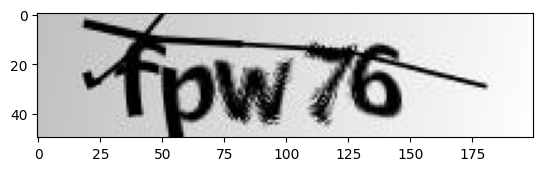

In [169]:
imgfiles=glob.glob(os.path.join(path,'samples/*.png'))
img=Image.open(imgfiles[0])
print(len(imgfiles)*0.8)
plt.imshow(img)
plt.show()

In [125]:
def get_BOW(corpus):
  BOW={"<pad>":0}

  for letter in corpus:
    if letter not in BOW:
      BOW[letter]=len(BOW.keys())

  return BOW

In [191]:
class Captcha(Dataset):
  def __init__(self,pth,train=True):
    self.corpus=string.ascii_lowercase+string.digits #소문자와 숫자만 정답
    self.BOW=get_BOW(self.corpus)

    self.imgs=glob.glob(pth+"/*.png")

    self.train=train
    self.trainset=self.imgs[:int(len(self.imgs)*0.8)]
    self.testset=self.imgs[int(len(self.imgs)*0.8):]

  def get_seq(self,line):
    # 캡챠의 문자를 고유 번호로 치환
    label=[]

    for letter in line:
      label.append(self.BOW[letter]) #BOW에 letter를 대입하여 고유 값 get
      print(self.BOW[letter])
    return label

  def __len__(self):
    if self.train:
      return len(self.trainset)
    else:
      return len(self.testset)

  def __getitem__(self,idx):
    if self.train:
      #이미지
      data=Image.open(self.trainset[idx]).convert('RGB')

      #이미지 파일이름이 label임
      label=self.trainset[idx].split('/')[-1]
      label=label.split('.png')[0]
      label=self.get_seq(label) #글자를 숫자형식의 고유값으로 변환

      data=np.array(data).astype(np.float32)
      data=np.transpose(data,(2,0,1)) #pytorch는 채널이 맨 앞에 와야 함
      label=np.array(label)
      print(label)
      return data,label

    else:
      data=Image.open(self.testset[idx]).convert('RGB')
      label=self.testset[idx].split('/')[-1]
      label=label.split('.png')[0]
      label=self.get_seq(label)

      data=np.array(data).astype(np.float32)
      label=np.array(label)

      return data,label



In [171]:
class BasicBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=(3,5),stride=(2,1)):
    super(BasicBlock,self).__init__()

    self.conv1=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.conv2=nn.Conv2d(in_channels=out_channels,out_channels=out_channels,kernel_size=(3,3),padding=1)
    self.downsampling=nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=kernel_size,stride=stride)
    self.bn1=nn.BatchNorm2d(num_features=out_channels)
    self.bn2=nn.BatchNorm2d(num_features=out_channels)

    self.relu=nn.ReLU()

  def forward(self,x):
    x_=x
    x=self.conv1(x)
    x=self.bn1(x)
    x=self.relu(x)
    x=self.conv2(x)
    x=self.bn2(x)

    x_=self.downsampling(x_)
    x+=x_
    x=self.relu(x)

    return x

In [180]:
class CRNN(nn.Module):
  def __init__(self,output_size):
    super(CRNN,self).__init__()

    self.c1=BasicBlock(in_channels=3,out_channels=64)
    self.c2=BasicBlock(in_channels=64,out_channels=64)
    self.c3=BasicBlock(in_channels=64,out_channels=64)
    self.c4=BasicBlock(in_channels=64,out_channels=64)
    self.c5=nn.Conv2d(64,64,kernel_size=(2,5))

    self.gru=nn.GRU(64,64,batch_first=False)

    self.fc1=nn.Linear(in_features=64,out_features=128)
    self.fc2=nn.Linear(in_features=128,out_features=output_size)
    self.relu=nn.ReLU()

  def forward(self,x):
    x=self.c1(x) # [batch_size, channel, height, width]
    x=self.c2(x)
    x=self.c3(x)
    x=self.c4(x)
    x=self.c5(x)

    x=x.view(x.shape[0],64,-1) # [batch_size, channel, width]
    x=x.permute(2,0,1) # [width, batch_size, channel]
    x,_=self.gru(x)
    x=self.fc1(x)
    x=self.relu(x)
    x=self.fc2(x)  #[width, batch_size, channel(num_class)]
    print(f'fc2: {x.shape}')
    x=F.log_softmax(x,dim=-1) #dim=-1 : 마지막 dimenstion의 softmax값 계산, num_class의 값 계산
    print(f'log_softmax: {x.shape}')
    return x


In [181]:
device='cuda' if torch.cuda.is_available() else 'cpu'
dataset=Captcha(pth=os.path.join(path,'samples'))
loader=DataLoader(dataset,batch_size=8)

model=CRNN(output_size=len(dataset.BOW)).to(device)
optim=Adam(model.parameters(),lr=0.0001)

for epoch in range(100):
  iterator=tqdm.tqdm(loader)
  for data,label in iterator:

    optim.zero_grad()
    preds=model(data.to(device))

    preds_size=torch.IntTensor([preds.size(0)]*8).to(device)
    target_len=torch.IntTensor([len(txt) for txt in label]).to(device)
    loss=nn.CTCLoss(blank=0)(preds,label.to(device),preds_size,target_len)

    loss.backward()
    optim.step()

    iterator.set_description(f"epoch:{epoch+1} loss:{loss.item()}")
  torch.save(model.state_dict(),'CRNN.pth')

  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:116.84941864013672:   1%|          | 1/104 [00:00<01:22,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:112.72723388671875:   2%|▏         | 2/104 [00:01<01:19,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:110.10795593261719:   3%|▎         | 3/104 [00:02<01:19,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:103.30903625488281:   4%|▍         | 4/104 [00:03<01:17,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:107.76707458496094:   5%|▍         | 5/104 [00:03<01:17,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:103.16244506835938:   6%|▌         | 6/104 [00:04<01:16,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:110.68849182128906:   7%|▋         | 7/104 [00:05<01:16,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:104.3153305053711:   8%|▊         | 8/104 [00:06<01:15,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:95.70384216308594:   9%|▊         | 9/104 [00:07<01:14,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:113.21040344238281:  10%|▉         | 10/104 [00:07<01:12,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:103.10423278808594:  11%|█         | 11/104 [00:08<01:16,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:91.4027099609375:  12%|█▏        | 12/104 [00:09<01:26,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:96.3934555053711:  12%|█▎        | 13/104 [00:11<01:33,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:105.18505096435547:  13%|█▎        | 14/104 [00:12<01:28,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:91.11845397949219:  14%|█▍        | 15/104 [00:12<01:21,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:99.45716094970703:  15%|█▌        | 16/104 [00:13<01:16,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:105.43815612792969:  16%|█▋        | 17/104 [00:14<01:12,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:104.15911865234375:  17%|█▋        | 18/104 [00:15<01:10,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:101.86418914794922:  18%|█▊        | 19/104 [00:15<01:08,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:99.11014556884766:  19%|█▉        | 20/104 [00:16<01:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:115.22291564941406:  20%|██        | 21/104 [00:17<01:05,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:105.3856430053711:  21%|██        | 22/104 [00:18<01:04,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:100.55353546142578:  22%|██▏       | 23/104 [00:18<01:03,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:99.253173828125:  23%|██▎       | 24/104 [00:19<01:01,  1.30it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:95.32611083984375:  24%|██▍       | 25/104 [00:20<01:00,  1.30it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:113.26856994628906:  25%|██▌       | 26/104 [00:21<01:00,  1.30it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:90.35163116455078:  26%|██▌       | 27/104 [00:22<01:07,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:86.94254302978516:  27%|██▋       | 28/104 [00:23<01:14,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:94.5077896118164:  28%|██▊       | 29/104 [00:24<01:18,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:100.23784637451172:  29%|██▉       | 30/104 [00:25<01:10,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:95.32888793945312:  30%|██▉       | 31/104 [00:26<01:05,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:78.36864471435547:  31%|███       | 32/104 [00:27<01:01,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:95.8998031616211:  32%|███▏      | 33/104 [00:27<00:58,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:102.08906555175781:  33%|███▎      | 34/104 [00:28<00:56,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:94.66907501220703:  34%|███▎      | 35/104 [00:29<00:55,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:111.68871307373047:  35%|███▍      | 36/104 [00:30<00:53,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:79.08338928222656:  36%|███▌      | 37/104 [00:30<00:52,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:107.05998229980469:  37%|███▋      | 38/104 [00:31<00:51,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:88.74982452392578:  38%|███▊      | 39/104 [00:32<00:50,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:90.9671401977539:  38%|███▊      | 40/104 [00:33<00:49,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:93.07869720458984:  39%|███▉      | 41/104 [00:34<00:48,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:105.54019927978516:  40%|████      | 42/104 [00:34<00:48,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:94.80794525146484:  41%|████▏     | 43/104 [00:35<00:55,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:94.99443817138672:  42%|████▏     | 44/104 [00:37<01:00,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:87.37854766845703:  43%|████▎     | 45/104 [00:38<00:59,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:93.43206787109375:  44%|████▍     | 46/104 [00:39<00:54,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:89.3099594116211:  45%|████▌     | 47/104 [00:39<00:50,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:89.07061767578125:  46%|████▌     | 48/104 [00:40<00:47,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:87.42662048339844:  47%|████▋     | 49/104 [00:41<00:45,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:100.51306915283203:  48%|████▊     | 50/104 [00:42<00:43,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:83.9537353515625:  49%|████▉     | 51/104 [00:42<00:42,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:75.76887512207031:  50%|█████     | 52/104 [00:43<00:40,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:86.59547424316406:  51%|█████     | 53/104 [00:44<00:39,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:104.12538146972656:  52%|█████▏    | 54/104 [00:45<00:38,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:75.0388412475586:  53%|█████▎    | 55/104 [00:45<00:38,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:79.54619598388672:  54%|█████▍    | 56/104 [00:46<00:37,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:80.20365905761719:  55%|█████▍    | 57/104 [00:47<00:36,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:93.006103515625:  56%|█████▌    | 58/104 [00:48<00:38,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:82.78567504882812:  57%|█████▋    | 59/104 [00:49<00:42,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:66.59567260742188:  58%|█████▊    | 60/104 [00:50<00:45,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:71.37962341308594:  59%|█████▊    | 61/104 [00:51<00:41,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:75.42403411865234:  60%|█████▉    | 62/104 [00:52<00:38,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:93.02571105957031:  61%|██████    | 63/104 [00:53<00:36,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:78.57327270507812:  62%|██████▏   | 64/104 [00:54<00:33,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:95.16070556640625:  62%|██████▎   | 65/104 [00:54<00:32,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:76.01837921142578:  63%|██████▎   | 66/104 [00:55<00:30,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:65.68001556396484:  64%|██████▍   | 67/104 [00:56<00:29,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:102.4483871459961:  65%|██████▌   | 68/104 [00:57<00:28,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:86.14696502685547:  66%|██████▋   | 69/104 [00:58<00:27,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:71.67808532714844:  67%|██████▋   | 70/104 [00:58<00:26,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:79.41900634765625:  68%|██████▊   | 71/104 [00:59<00:25,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:94.3915023803711:  69%|██████▉   | 72/104 [01:00<00:24,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:72.2120132446289:  70%|███████   | 73/104 [01:01<00:24,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:76.82355499267578:  71%|███████   | 74/104 [01:02<00:27,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:79.9491958618164:  72%|███████▏  | 75/104 [01:03<00:28,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:84.40837097167969:  73%|███████▎  | 76/104 [01:04<00:28,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:99.98055267333984:  74%|███████▍  | 77/104 [01:05<00:25,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:92.96377563476562:  75%|███████▌  | 78/104 [01:06<00:23,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:78.47100830078125:  76%|███████▌  | 79/104 [01:06<00:21,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:74.57337188720703:  77%|███████▋  | 80/104 [01:07<00:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:88.55618286132812:  78%|███████▊  | 81/104 [01:08<00:18,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:91.19515991210938:  79%|███████▉  | 82/104 [01:09<00:17,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:92.98489379882812:  80%|███████▉  | 83/104 [01:10<00:16,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:80.21345520019531:  81%|████████  | 84/104 [01:10<00:15,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:87.26251983642578:  82%|████████▏ | 85/104 [01:11<00:14,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:85.3741455078125:  83%|████████▎ | 86/104 [01:12<00:14,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:66.55609130859375:  84%|████████▎ | 87/104 [01:13<00:13,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:98.24903106689453:  85%|████████▍ | 88/104 [01:13<00:12,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:71.3480224609375:  86%|████████▌ | 89/104 [01:14<00:12,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:88.56155395507812:  87%|████████▋ | 90/104 [01:16<00:13,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:56.48486328125:  88%|████████▊ | 91/104 [01:17<00:13,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:84.54031372070312:  88%|████████▊ | 92/104 [01:18<00:11,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:97.1620101928711:  89%|████████▉ | 93/104 [01:19<00:10,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:84.7671890258789:  90%|█████████ | 94/104 [01:19<00:08,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:84.78975677490234:  91%|█████████▏| 95/104 [01:20<00:07,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:96.38764190673828:  92%|█████████▏| 96/104 [01:21<00:06,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:89.20533752441406:  93%|█████████▎| 97/104 [01:22<00:05,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:73.35952758789062:  94%|█████████▍| 98/104 [01:22<00:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:54.87068176269531:  95%|█████████▌| 99/104 [01:23<00:03,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:81.5122299194336:  96%|█████████▌| 100/104 [01:24<00:03,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:79.14973449707031:  97%|█████████▋| 101/104 [01:25<00:02,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:78.51814270019531:  98%|█████████▊| 102/104 [01:25<00:01,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:1 loss:104.18290710449219:  99%|█████████▉| 103/104 [01:26<00:00,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:87.41114807128906:   1%|          | 1/104 [00:01<02:03,  1.20s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:64.44611358642578:   2%|▏         | 2/104 [00:02<02:02,  1.21s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:71.90806579589844:   3%|▎         | 3/104 [00:03<01:56,  1.16s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:59.81678771972656:   4%|▍         | 4/104 [00:04<01:41,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:80.09849548339844:   5%|▍         | 5/104 [00:05<01:32,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:71.93666076660156:   6%|▌         | 6/104 [00:05<01:26,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:90.41973876953125:   7%|▋         | 7/104 [00:06<01:31,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:80.76549530029297:   8%|▊         | 8/104 [00:08<01:35,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:61.73868942260742:   9%|▊         | 9/104 [00:09<01:34,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:96.77971649169922:  10%|▉         | 10/104 [00:09<01:26,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:78.22189331054688:  11%|█         | 11/104 [00:10<01:21,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:58.14946365356445:  12%|█▏        | 12/104 [00:11<01:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:69.59699249267578:  12%|█▎        | 13/104 [00:12<01:14,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:84.9499282836914:  13%|█▎        | 14/104 [00:12<01:12,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:61.80537796020508:  14%|█▍        | 15/104 [00:13<01:16,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:77.0313949584961:  15%|█▌        | 16/104 [00:15<01:25,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:85.79629516601562:  16%|█▋        | 17/104 [00:16<01:32,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:85.03923797607422:  17%|█▋        | 18/104 [00:17<01:24,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:81.99259948730469:  18%|█▊        | 19/104 [00:17<01:18,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:76.6238784790039:  19%|█▉        | 20/104 [00:18<01:14,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:102.36124420166016:  20%|██        | 21/104 [00:19<01:10,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:87.5606689453125:  21%|██        | 22/104 [00:20<01:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:80.23676300048828:  22%|██▏       | 23/104 [00:21<01:05,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:77.615234375:  23%|██▎       | 24/104 [00:21<01:03,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:73.63556671142578:  24%|██▍       | 25/104 [00:22<01:02,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:95.21978759765625:  25%|██▌       | 26/104 [00:23<01:00,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:69.13418579101562:  26%|██▌       | 27/104 [00:24<00:59,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:66.63194274902344:  27%|██▋       | 28/104 [00:24<00:59,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:74.90187072753906:  28%|██▊       | 29/104 [00:25<00:58,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:78.9991226196289:  29%|██▉       | 30/104 [00:26<00:57,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:76.67318725585938:  30%|██▉       | 31/104 [00:27<01:05,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:57.372928619384766:  31%|███       | 32/104 [00:28<01:11,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:78.84213256835938:  32%|███▏      | 33/104 [00:29<01:12,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:82.90489959716797:  33%|███▎      | 34/104 [00:30<01:05,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:73.04676055908203:  34%|███▎      | 35/104 [00:31<01:01,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:86.29188537597656:  35%|███▍      | 36/104 [00:32<00:58,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:59.85323715209961:  36%|███▌      | 37/104 [00:33<00:55,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:80.53366088867188:  37%|███▋      | 38/104 [00:33<00:53,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:66.86577606201172:  38%|███▊      | 39/104 [00:34<00:52,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:71.174072265625:  38%|███▊      | 40/104 [00:35<00:51,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:72.4033203125:  39%|███▉      | 41/104 [00:36<00:49,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:79.85537719726562:  40%|████      | 42/104 [00:36<00:48,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:71.42518615722656:  41%|████▏     | 43/104 [00:37<00:47,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:70.7869873046875:  42%|████▏     | 44/104 [00:38<00:46,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:64.41658020019531:  43%|████▎     | 45/104 [00:39<00:45,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:68.9121322631836:  44%|████▍     | 46/104 [00:40<00:48,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:63.584754943847656:  45%|████▌     | 47/104 [00:41<00:53,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:62.424808502197266:  46%|████▌     | 48/104 [00:42<00:57,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:61.557373046875:  47%|████▋     | 49/104 [00:43<00:54,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:69.90265655517578:  48%|████▊     | 50/104 [00:44<00:50,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:60.28436279296875:  49%|████▉     | 51/104 [00:45<00:46,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:55.44915771484375:  50%|█████     | 52/104 [00:45<00:44,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:58.9104118347168:  51%|█████     | 53/104 [00:46<00:42,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:67.04435729980469:  52%|█████▏    | 54/104 [00:47<00:40,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:53.28315734863281:  53%|█████▎    | 55/104 [00:48<00:39,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:56.904998779296875:  54%|█████▍    | 56/104 [00:48<00:38,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:56.16541290283203:  55%|█████▍    | 57/104 [00:49<00:37,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:59.41783905029297:  56%|█████▌    | 58/104 [00:50<00:36,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:54.14875030517578:  57%|█████▋    | 59/104 [00:51<00:35,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:49.407371520996094:  58%|█████▊    | 60/104 [00:52<00:34,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:49.2845344543457:  59%|█████▊    | 61/104 [00:52<00:33,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:52.03923034667969:  60%|█████▉    | 62/104 [00:53<00:36,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:58.64717102050781:  61%|██████    | 63/104 [00:55<00:40,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:50.62087631225586:  62%|██████▏   | 64/104 [00:56<00:41,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:56.70857238769531:  62%|██████▎   | 65/104 [00:57<00:37,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:49.85840606689453:  63%|██████▎   | 66/104 [00:57<00:34,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:46.081546783447266:  64%|██████▍   | 67/104 [00:58<00:32,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:57.70949935913086:  65%|██████▌   | 68/104 [00:59<00:30,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:50.9385986328125:  66%|██████▋   | 69/104 [01:00<00:28,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:45.08510208129883:  67%|██████▋   | 70/104 [01:01<00:27,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:47.20536422729492:  68%|██████▊   | 71/104 [01:01<00:26,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:51.582298278808594:  69%|██████▉   | 72/104 [01:02<00:25,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:45.79412841796875:  70%|███████   | 73/104 [01:03<00:24,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:45.52019119262695:  71%|███████   | 74/104 [01:04<00:23,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:46.71263885498047:  72%|███████▏  | 75/104 [01:04<00:22,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:46.39018630981445:  73%|███████▎  | 76/104 [01:05<00:21,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:47.70551300048828:  74%|███████▍  | 77/104 [01:06<00:21,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:46.93973159790039:  75%|███████▌  | 78/104 [01:07<00:24,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:43.398624420166016:  76%|███████▌  | 79/104 [01:09<00:25,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:43.05290985107422:  77%|███████▋  | 80/104 [01:09<00:23,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:43.82321548461914:  78%|███████▊  | 81/104 [01:10<00:21,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:44.01744079589844:  79%|███████▉  | 82/104 [01:11<00:19,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:43.22456359863281:  80%|███████▉  | 83/104 [01:12<00:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:40.92273712158203:  81%|████████  | 84/104 [01:13<00:16,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:41.06712341308594:  82%|████████▏ | 85/104 [01:13<00:15,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:40.33091735839844:  83%|████████▎ | 86/104 [01:14<00:14,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:38.802608489990234:  84%|████████▎ | 87/104 [01:15<00:13,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:38.81303405761719:  85%|████████▍ | 88/104 [01:16<00:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:37.442054748535156:  86%|████████▌ | 89/104 [01:16<00:11,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:36.81740951538086:  87%|████████▋ | 90/104 [01:17<00:11,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:34.78330612182617:  88%|████████▊ | 91/104 [01:18<00:10,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:34.37765884399414:  88%|████████▊ | 92/104 [01:19<00:09,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:33.40645217895508:  89%|████████▉ | 93/104 [01:20<00:09,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:31.99004364013672:  90%|█████████ | 94/104 [01:21<00:09,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:30.666851043701172:  91%|█████████▏| 95/104 [01:22<00:09,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:29.895404815673828:  92%|█████████▏| 96/104 [01:23<00:07,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:28.617431640625:  93%|█████████▎| 97/104 [01:24<00:06,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:27.24616241455078:  94%|█████████▍| 98/104 [01:25<00:05,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:26.04621696472168:  95%|█████████▌| 99/104 [01:25<00:04,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:25.46154022216797:  96%|█████████▌| 100/104 [01:26<00:03,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:24.486228942871094:  97%|█████████▋| 101/104 [01:27<00:02,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:23.41592788696289:  98%|█████████▊| 102/104 [01:28<00:01,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:2 loss:22.6895694732666:  99%|█████████▉| 103/104 [01:29<00:00,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:20.75596809387207:   1%|          | 1/104 [00:00<01:19,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:19.80755615234375:   2%|▏         | 2/104 [00:01<01:19,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:18.971630096435547:   3%|▎         | 3/104 [00:02<01:18,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:18.168716430664062:   4%|▍         | 4/104 [00:03<01:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:17.988676071166992:   5%|▍         | 5/104 [00:04<01:36,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:16.98981285095215:   6%|▌         | 6/104 [00:05<01:43,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:16.802297592163086:   7%|▋         | 7/104 [00:06<01:38,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:16.067096710205078:   8%|▊         | 8/104 [00:07<01:29,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:15.441978454589844:   9%|▊         | 9/104 [00:08<01:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:15.052144050598145:  10%|▉         | 10/104 [00:08<01:20,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:14.632787704467773:  11%|█         | 11/104 [00:09<01:17,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:13.555943489074707:  12%|█▏        | 12/104 [00:10<01:14,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:13.346635818481445:  12%|█▎        | 13/104 [00:11<01:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:13.030387878417969:  13%|█▎        | 14/104 [00:12<01:10,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:12.894844055175781:  14%|█▍        | 15/104 [00:12<01:09,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:12.383992195129395:  15%|█▌        | 16/104 [00:13<01:08,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:11.932937622070312:  16%|█▋        | 17/104 [00:14<01:07,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:11.57004451751709:  17%|█▋        | 18/104 [00:15<01:07,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:11.35374927520752:  18%|█▊        | 19/104 [00:15<01:06,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:11.026520729064941:  19%|█▉        | 20/104 [00:17<01:14,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:11.010290145874023:  20%|██        | 21/104 [00:18<01:20,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:10.732100486755371:  21%|██        | 22/104 [00:19<01:26,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:10.382904052734375:  22%|██▏       | 23/104 [00:20<01:18,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:10.063743591308594:  23%|██▎       | 24/104 [00:21<01:13,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:9.575201988220215:  24%|██▍       | 25/104 [00:21<01:09,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:9.87606430053711:  25%|██▌       | 26/104 [00:22<01:06,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:9.067469596862793:  26%|██▌       | 27/104 [00:23<01:03,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:9.005681991577148:  27%|██▋       | 28/104 [00:24<01:02,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.76262092590332:  28%|██▊       | 29/104 [00:24<01:00,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.653388023376465:  29%|██▉       | 30/104 [00:25<00:58,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.59760856628418:  30%|██▉       | 31/104 [00:26<00:57,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.29201602935791:  31%|███       | 32/104 [00:27<00:56,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.286401748657227:  32%|███▏      | 33/104 [00:28<00:55,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.985180854797363:  33%|███▎      | 34/104 [00:28<00:54,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.044340133666992:  34%|███▎      | 35/104 [00:29<00:56,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:8.456666946411133:  35%|███▍      | 36/104 [00:30<01:03,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.2902021408081055:  36%|███▌      | 37/104 [00:32<01:08,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.950004577636719:  37%|███▋      | 38/104 [00:33<01:06,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.525099754333496:  38%|███▊      | 39/104 [00:33<01:01,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.425372123718262:  38%|███▊      | 40/104 [00:34<00:58,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.208595275878906:  39%|███▉      | 41/104 [00:35<00:54,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.130661964416504:  40%|████      | 42/104 [00:36<00:52,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:7.098228454589844:  41%|████▏     | 43/104 [00:37<00:50,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.872128009796143:  42%|████▏     | 44/104 [00:37<00:48,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.957001686096191:  43%|████▎     | 45/104 [00:38<00:47,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.705694675445557:  44%|████▍     | 46/104 [00:39<00:46,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.8514299392700195:  45%|████▌     | 47/104 [00:40<00:45,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.641666889190674:  46%|████▌     | 48/104 [00:41<00:44,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.570496559143066:  47%|████▋     | 49/104 [00:41<00:43,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.496549129486084:  48%|████▊     | 50/104 [00:42<00:42,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.519237518310547:  49%|████▉     | 51/104 [00:43<00:47,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.210602283477783:  50%|█████     | 52/104 [00:44<00:51,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.288512706756592:  51%|█████     | 53/104 [00:46<00:53,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.358503341674805:  52%|█████▏    | 54/104 [00:46<00:49,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.001584529876709:  53%|█████▎    | 55/104 [00:47<00:45,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.985590934753418:  54%|█████▍    | 56/104 [00:48<00:42,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.035445213317871:  55%|█████▍    | 57/104 [00:49<00:40,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:6.051601409912109:  56%|█████▌    | 58/104 [00:50<00:38,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.693110942840576:  57%|█████▋    | 59/104 [00:50<00:36,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.629718780517578:  58%|█████▊    | 60/104 [00:51<00:35,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.794229507446289:  59%|█████▊    | 61/104 [00:52<00:34,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.546631813049316:  60%|█████▉    | 62/104 [00:53<00:33,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.872785568237305:  61%|██████    | 63/104 [00:53<00:32,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.420314788818359:  62%|██████▏   | 64/104 [00:54<00:31,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.5226545333862305:  62%|██████▎   | 65/104 [00:55<00:30,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.516819953918457:  63%|██████▎   | 66/104 [00:56<00:31,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.1764421463012695:  64%|██████▍   | 67/104 [00:57<00:34,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.635772228240967:  65%|██████▌   | 68/104 [00:58<00:37,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.444918155670166:  66%|██████▋   | 69/104 [00:59<00:34,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.5286431312561035:  67%|██████▋   | 70/104 [01:00<00:31,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.440843105316162:  68%|██████▊   | 71/104 [01:01<00:29,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.354808807373047:  69%|██████▉   | 72/104 [01:02<00:27,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.090524196624756:  70%|███████   | 73/104 [01:02<00:25,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.234988212585449:  71%|███████   | 74/104 [01:03<00:24,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.0157670974731445:  72%|███████▏  | 75/104 [01:04<00:23,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.234100341796875:  73%|███████▎  | 76/104 [01:05<00:22,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.335096836090088:  74%|███████▍  | 77/104 [01:06<00:21,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.29506778717041:  75%|███████▌  | 78/104 [01:06<00:20,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.331652641296387:  76%|███████▌  | 79/104 [01:07<00:19,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.273584365844727:  77%|███████▋  | 80/104 [01:08<00:18,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.259994029998779:  78%|███████▊  | 81/104 [01:09<00:18,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.075881481170654:  79%|███████▉  | 82/104 [01:10<00:20,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.15653657913208:  80%|███████▉  | 83/104 [01:11<00:21,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.022624969482422:  81%|████████  | 84/104 [01:12<00:20,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.839399814605713:  82%|████████▏ | 85/104 [01:13<00:18,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.156887531280518:  83%|████████▎ | 86/104 [01:14<00:16,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.80311918258667:  84%|████████▎ | 87/104 [01:15<00:14,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.11724853515625:  85%|████████▍ | 88/104 [01:15<00:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.877459526062012:  86%|████████▌ | 89/104 [01:16<00:12,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.155235290527344:  87%|████████▋ | 90/104 [01:17<00:11,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.558145999908447:  88%|████████▊ | 91/104 [01:18<00:10,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.993799209594727:  88%|████████▊ | 92/104 [01:19<00:09,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.056148052215576:  89%|████████▉ | 93/104 [01:19<00:08,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.92841911315918:  90%|█████████ | 94/104 [01:20<00:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.725211143493652:  91%|█████████▏| 95/104 [01:21<00:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:5.0492448806762695:  92%|█████████▏| 96/104 [01:22<00:06,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.860363960266113:  93%|█████████▎| 97/104 [01:23<00:06,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.671785354614258:  94%|█████████▍| 98/104 [01:24<00:05,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.525739669799805:  95%|█████████▌| 99/104 [01:25<00:05,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.781367778778076:  96%|█████████▌| 100/104 [01:26<00:03,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.798874855041504:  97%|█████████▋| 101/104 [01:27<00:02,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.673835754394531:  98%|█████████▊| 102/104 [01:28<00:01,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:3 loss:4.763905048370361:  99%|█████████▉| 103/104 [01:28<00:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.536198616027832:   1%|          | 1/104 [00:00<01:22,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.45522928237915:   2%|▏         | 2/104 [00:01<01:20,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.329626083374023:   3%|▎         | 3/104 [00:02<01:19,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.285467624664307:   4%|▍         | 4/104 [00:03<01:18,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.655050754547119:   5%|▍         | 5/104 [00:03<01:19,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.370305061340332:   6%|▌         | 6/104 [00:04<01:18,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.687825679779053:   7%|▋         | 7/104 [00:05<01:17,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.56587028503418:   8%|▊         | 8/104 [00:06<01:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.500560283660889:   9%|▊         | 9/104 [00:07<01:29,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.595069885253906:  10%|▉         | 10/104 [00:08<01:38,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.639222145080566:  11%|█         | 11/104 [00:09<01:34,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.123546600341797:  12%|█▏        | 12/104 [00:10<01:26,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.343696594238281:  12%|█▎        | 13/104 [00:11<01:21,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.376459121704102:  13%|█▎        | 14/104 [00:12<01:17,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.578465938568115:  14%|█▍        | 15/104 [00:13<01:14,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.441763401031494:  15%|█▌        | 16/104 [00:13<01:12,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.412731647491455:  16%|█▋        | 17/104 [00:14<01:10,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.368753910064697:  17%|█▋        | 18/104 [00:15<01:09,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.429052829742432:  18%|█▊        | 19/104 [00:16<01:07,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.378833770751953:  19%|█▉        | 20/104 [00:16<01:06,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.604711055755615:  20%|██        | 21/104 [00:17<01:05,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.600752830505371:  21%|██        | 22/104 [00:18<01:04,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.531351566314697:  22%|██▏       | 23/104 [00:19<01:04,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.478084564208984:  23%|██▎       | 24/104 [00:20<01:12,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.24274206161499:  24%|██▍       | 25/104 [00:21<01:18,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.671783447265625:  25%|██▌       | 26/104 [00:22<01:22,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.164372444152832:  26%|██▌       | 27/104 [00:23<01:14,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.2433857917785645:  27%|██▋       | 28/104 [00:24<01:09,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.214505195617676:  28%|██▊       | 29/104 [00:25<01:05,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.261949062347412:  29%|██▉       | 30/104 [00:26<01:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.354697227478027:  30%|██▉       | 31/104 [00:26<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.213936805725098:  31%|███       | 32/104 [00:27<00:58,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.37199592590332:  32%|███▏      | 33/104 [00:28<00:57,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.22636604309082:  33%|███▎      | 34/104 [00:29<00:56,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.345987319946289:  34%|███▎      | 35/104 [00:29<00:55,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.75382661819458:  35%|███▍      | 36/104 [00:30<00:53,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9226841926574707:  36%|███▌      | 37/104 [00:31<00:52,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.574034690856934:  37%|███▋      | 38/104 [00:32<00:52,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.321139335632324:  38%|███▊      | 39/104 [00:33<00:54,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.307539939880371:  38%|███▊      | 40/104 [00:34<01:00,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.207646369934082:  39%|███▉      | 41/104 [00:35<01:05,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.251662254333496:  40%|████      | 42/104 [00:36<01:02,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.250584125518799:  41%|████▏     | 43/104 [00:37<00:57,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.159089088439941:  42%|████▏     | 44/104 [00:38<00:53,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.299435138702393:  43%|████▎     | 45/104 [00:38<00:50,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.134720802307129:  44%|████▍     | 46/104 [00:39<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.312349796295166:  45%|████▌     | 47/104 [00:40<00:47,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.2057952880859375:  46%|████▌     | 48/104 [00:41<00:45,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.201202392578125:  47%|████▋     | 49/104 [00:42<00:44,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.2360076904296875:  48%|████▊     | 50/104 [00:42<00:43,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.233155250549316:  49%|████▉     | 51/104 [00:43<00:42,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.042342185974121:  50%|█████     | 52/104 [00:44<00:41,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.149754047393799:  51%|█████     | 53/104 [00:45<00:40,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.2440409660339355:  52%|█████▏    | 54/104 [00:46<00:39,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.032310962677002:  53%|█████▎    | 55/104 [00:47<00:44,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.035085678100586:  54%|█████▍    | 56/104 [00:48<00:48,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.089332580566406:  55%|█████▍    | 57/104 [00:49<00:49,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.1741743087768555:  56%|█████▌    | 58/104 [00:50<00:44,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.912018060684204:  57%|█████▋    | 59/104 [00:51<00:41,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8938615322113037:  58%|█████▊    | 60/104 [00:52<00:38,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.0848069190979:  59%|█████▊    | 61/104 [00:52<00:36,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9150288105010986:  60%|█████▉    | 62/104 [00:53<00:34,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.216845989227295:  61%|██████    | 63/104 [00:54<00:33,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8755478858947754:  62%|██████▏   | 64/104 [00:55<00:32,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.991238594055176:  62%|██████▎   | 65/104 [00:55<00:31,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9704856872558594:  63%|██████▎   | 66/104 [00:56<00:30,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.7570879459381104:  64%|██████▍   | 67/104 [00:57<00:29,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.142889022827148:  65%|██████▌   | 68/104 [00:58<00:28,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.022331237792969:  66%|██████▋   | 69/104 [00:59<00:27,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.0961527824401855:  67%|██████▋   | 70/104 [01:00<00:29,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.033802032470703:  68%|██████▊   | 71/104 [01:01<00:31,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.999624729156494:  69%|██████▉   | 72/104 [01:02<00:34,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8167192935943604:  70%|███████   | 73/104 [01:03<00:31,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9689149856567383:  71%|███████   | 74/104 [01:04<00:28,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.791398525238037:  72%|███████▏  | 75/104 [01:05<00:25,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9756393432617188:  73%|███████▎  | 76/104 [01:05<00:24,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.113035202026367:  74%|███████▍  | 77/104 [01:06<00:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.103065013885498:  75%|███████▌  | 78/104 [01:07<00:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.106437683105469:  76%|███████▌  | 79/104 [01:08<00:20,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.0971903800964355:  77%|███████▋  | 80/104 [01:08<00:19,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.077648639678955:  78%|███████▊  | 81/104 [01:09<00:18,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9893784523010254:  79%|███████▉  | 82/104 [01:10<00:17,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.073629379272461:  80%|███████▉  | 83/104 [01:11<00:16,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9464077949523926:  81%|████████  | 84/104 [01:12<00:15,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8461151123046875:  82%|████████▏ | 85/104 [01:12<00:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.052796840667725:  83%|████████▎ | 86/104 [01:14<00:16,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8419570922851562:  84%|████████▎ | 87/104 [01:15<00:17,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.100562572479248:  85%|████████▍ | 88/104 [01:16<00:16,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8894081115722656:  86%|████████▌ | 89/104 [01:17<00:14,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.144337177276611:  87%|████████▋ | 90/104 [01:17<00:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.6520700454711914:  88%|████████▊ | 91/104 [01:18<00:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.023603439331055:  88%|████████▊ | 92/104 [01:19<00:10,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.094084739685059:  89%|████████▉ | 93/104 [01:20<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.0519490242004395:  90%|█████████ | 94/104 [01:21<00:08,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.8555526733398438:  91%|█████████▏| 95/104 [01:21<00:07,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:4.171177864074707:  92%|█████████▏| 96/104 [01:22<00:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9977149963378906:  93%|█████████▎| 97/104 [01:23<00:05,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.84834623336792:  94%|█████████▍| 98/104 [01:24<00:04,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.7285959720611572:  95%|█████████▌| 99/104 [01:25<00:03,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9339847564697266:  96%|█████████▌| 100/104 [01:25<00:03,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9920566082000732:  97%|█████████▋| 101/104 [01:26<00:02,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.883930206298828:  98%|█████████▊| 102/104 [01:28<00:01,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:4 loss:3.9776971340179443:  99%|█████████▉| 103/104 [01:29<00:01,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8022899627685547:   1%|          | 1/104 [00:00<01:20,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7612483501434326:   2%|▏         | 2/104 [00:01<01:19,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.645413875579834:   3%|▎         | 3/104 [00:02<01:18,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.61759352684021:   4%|▍         | 4/104 [00:03<01:17,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.942321300506592:   5%|▍         | 5/104 [00:03<01:16,  1.29it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.737421751022339:   6%|▌         | 6/104 [00:04<01:16,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.965641975402832:   7%|▋         | 7/104 [00:05<01:15,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.898479461669922:   8%|▊         | 8/104 [00:06<01:15,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.832559585571289:   9%|▊         | 9/104 [00:07<01:13,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.9521796703338623:  10%|▉         | 10/104 [00:07<01:13,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.96541166305542:  11%|█         | 11/104 [00:08<01:12,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.54360294342041:  12%|█▏        | 12/104 [00:09<01:14,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.748086452484131:  12%|█▎        | 13/104 [00:10<01:24,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7700448036193848:  13%|█▎        | 14/104 [00:11<01:31,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.908574342727661:  14%|█▍        | 15/104 [00:12<01:29,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8138861656188965:  15%|█▌        | 16/104 [00:13<01:22,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8450379371643066:  16%|█▋        | 17/104 [00:14<01:17,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7930028438568115:  17%|█▋        | 18/104 [00:15<01:13,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8467609882354736:  18%|█▊        | 19/104 [00:16<01:11,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8013358116149902:  19%|█▉        | 20/104 [00:16<01:08,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:4.006219863891602:  20%|██        | 21/104 [00:17<01:06,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.9841527938842773:  21%|██        | 22/104 [00:18<01:06,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.940333127975464:  22%|██▏       | 23/104 [00:19<01:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.9322898387908936:  23%|██▎       | 24/104 [00:19<01:03,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7464640140533447:  24%|██▍       | 25/104 [00:20<01:02,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:4.088357925415039:  25%|██▌       | 26/104 [00:21<01:01,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.674618721008301:  26%|██▌       | 27/104 [00:22<01:00,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7270569801330566:  27%|██▋       | 28/104 [00:23<01:07,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7403573989868164:  28%|██▊       | 29/104 [00:24<01:13,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7757279872894287:  29%|██▉       | 30/104 [00:25<01:17,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.851017713546753:  30%|██▉       | 31/104 [00:26<01:10,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7115511894226074:  31%|███       | 32/104 [00:27<01:05,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.895641803741455:  32%|███▏      | 33/104 [00:28<01:01,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7940783500671387:  33%|███▎      | 34/104 [00:28<00:58,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.840852975845337:  34%|███▎      | 35/104 [00:29<00:56,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:4.134487152099609:  35%|███▍      | 36/104 [00:30<00:54,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.5104660987854004:  36%|███▌      | 37/104 [00:31<00:53,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:4.043087005615234:  37%|███▋      | 38/104 [00:32<00:52,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8591880798339844:  38%|███▊      | 39/104 [00:32<00:51,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.845609664916992:  38%|███▊      | 40/104 [00:33<00:50,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.769002676010132:  39%|███▉      | 41/104 [00:34<00:49,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8387787342071533:  40%|████      | 42/104 [00:35<00:48,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7993931770324707:  41%|████▏     | 43/104 [00:36<00:49,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7412705421447754:  42%|████▏     | 44/104 [00:37<00:55,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.861459493637085:  43%|████▎     | 45/104 [00:38<01:00,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.72385573387146:  44%|████▍     | 46/104 [00:39<00:58,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8519725799560547:  45%|████▌     | 47/104 [00:40<00:53,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7801921367645264:  46%|████▌     | 48/104 [00:40<00:49,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7895381450653076:  47%|████▋     | 49/104 [00:41<00:47,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8633997440338135:  48%|████▊     | 50/104 [00:42<00:44,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7819104194641113:  49%|████▉     | 51/104 [00:43<00:43,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6576249599456787:  50%|█████     | 52/104 [00:44<00:42,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7352521419525146:  51%|█████     | 53/104 [00:44<00:40,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.816866874694824:  52%|█████▏    | 54/104 [00:45<00:39,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.678480863571167:  53%|█████▎    | 55/104 [00:46<00:38,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.668056011199951:  54%|█████▍    | 56/104 [00:47<00:37,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.688408374786377:  55%|█████▍    | 57/104 [00:48<00:37,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7920796871185303:  56%|█████▌    | 58/104 [00:48<00:36,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.5797626972198486:  57%|█████▋    | 59/104 [00:49<00:39,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.557474374771118:  58%|█████▊    | 60/104 [00:51<00:43,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.735529899597168:  59%|█████▊    | 61/104 [00:52<00:45,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6086864471435547:  60%|█████▉    | 62/104 [00:53<00:41,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8521926403045654:  61%|██████    | 63/104 [00:54<00:37,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.580578327178955:  62%|██████▏   | 64/104 [00:54<00:35,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6831045150756836:  62%|██████▎   | 65/104 [00:55<00:33,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6259920597076416:  63%|██████▎   | 66/104 [00:56<00:31,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.4968621730804443:  64%|██████▍   | 67/104 [00:57<00:30,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7929372787475586:  65%|██████▌   | 68/104 [00:57<00:28,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.702876329421997:  66%|██████▋   | 69/104 [00:58<00:27,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7365148067474365:  67%|██████▋   | 70/104 [00:59<00:26,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.682323932647705:  68%|██████▊   | 71/104 [01:00<00:26,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.675330400466919:  69%|██████▉   | 72/104 [01:01<00:25,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.542484760284424:  70%|███████   | 73/104 [01:01<00:24,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6717653274536133:  71%|███████   | 74/104 [01:02<00:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.522592067718506:  72%|███████▏  | 75/104 [01:04<00:28,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6547329425811768:  73%|███████▎  | 76/104 [01:05<00:30,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8010385036468506:  74%|███████▍  | 77/104 [01:06<00:27,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7919294834136963:  75%|███████▌  | 78/104 [01:07<00:24,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.75278639793396:  76%|███████▌  | 79/104 [01:07<00:22,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7649550437927246:  77%|███████▋  | 80/104 [01:08<00:20,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7371625900268555:  78%|███████▊  | 81/104 [01:09<00:19,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7094995975494385:  79%|███████▉  | 82/104 [01:10<00:18,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7758803367614746:  80%|███████▉  | 83/104 [01:11<00:16,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.639575242996216:  81%|████████  | 84/104 [01:11<00:16,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6046102046966553:  82%|████████▏ | 85/104 [01:12<00:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.6996278762817383:  83%|████████▎ | 86/104 [01:13<00:14,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.590485095977783:  84%|████████▎ | 87/104 [01:14<00:13,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.790121555328369:  85%|████████▍ | 88/104 [01:14<00:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.5970828533172607:  86%|████████▌ | 89/104 [01:15<00:12,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8158838748931885:  87%|████████▋ | 90/104 [01:16<00:12,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.40686297416687:  88%|████████▊ | 91/104 [01:18<00:13,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.708864688873291:  88%|████████▊ | 92/104 [01:19<00:12,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7817420959472656:  89%|████████▉ | 93/104 [01:20<00:10,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.786691665649414:  90%|█████████ | 94/104 [01:20<00:08,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.5959625244140625:  91%|█████████▏| 95/104 [01:21<00:07,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.8805758953094482:  92%|█████████▏| 96/104 [01:22<00:06,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.722902297973633:  93%|█████████▎| 97/104 [01:23<00:05,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.5966005325317383:  94%|█████████▍| 98/104 [01:23<00:04,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.4939768314361572:  95%|█████████▌| 99/104 [01:24<00:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.648726224899292:  96%|█████████▌| 100/104 [01:25<00:03,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.725163221359253:  97%|█████████▋| 101/104 [01:26<00:02,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.622690439224243:  98%|█████████▊| 102/104 [01:27<00:01,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:5 loss:3.7133917808532715:  99%|█████████▉| 103/104 [01:27<00:00,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5706188678741455:   1%|          | 1/104 [00:01<02:03,  1.20s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5497000217437744:   2%|▏         | 2/104 [00:02<02:03,  1.21s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4401590824127197:   3%|▎         | 3/104 [00:03<01:56,  1.15s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4193875789642334:   4%|▍         | 4/104 [00:04<01:40,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.692129611968994:   5%|▍         | 5/104 [00:05<01:31,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.547713041305542:   6%|▌         | 6/104 [00:05<01:26,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6904942989349365:   7%|▋         | 7/104 [00:06<01:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.666008710861206:   8%|▊         | 8/104 [00:07<01:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5927493572235107:   9%|▊         | 9/104 [00:08<01:17,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.726001024246216:  10%|▉         | 10/104 [00:09<01:15,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7064151763916016:  11%|█         | 11/104 [00:09<01:14,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.3654303550720215:  12%|█▏        | 12/104 [00:10<01:13,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.545067310333252:  12%|█▎        | 13/104 [00:11<01:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5565736293792725:  13%|█▎        | 14/104 [00:12<01:11,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6340389251708984:  14%|█▍        | 15/104 [00:12<01:09,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.575080394744873:  15%|█▌        | 16/104 [00:13<01:16,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6396265029907227:  16%|█▋        | 17/104 [00:15<01:24,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5810000896453857:  17%|█▋        | 18/104 [00:16<01:29,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6264021396636963:  18%|█▊        | 19/104 [00:17<01:21,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5865225791931152:  19%|█▉        | 20/104 [00:17<01:16,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7609074115753174:  20%|██        | 21/104 [00:18<01:12,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7194528579711914:  21%|██        | 22/104 [00:19<01:09,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.689457654953003:  22%|██▏       | 23/104 [00:20<01:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7167201042175293:  23%|██▎       | 24/104 [00:21<01:05,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.570701837539673:  24%|██▍       | 25/104 [00:21<01:03,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.827943801879883:  25%|██▌       | 26/104 [00:22<01:02,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.494706153869629:  26%|██▌       | 27/104 [00:23<01:01,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.525482416152954:  27%|██▋       | 28/104 [00:24<01:00,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.568405866622925:  28%|██▊       | 29/104 [00:25<00:59,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5865399837493896:  29%|██▉       | 30/104 [00:25<00:58,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6425609588623047:  30%|██▉       | 31/104 [00:26<01:01,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.500978708267212:  31%|███       | 32/104 [00:27<01:08,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6979215145111084:  32%|███▏      | 33/104 [00:29<01:14,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.633936643600464:  33%|███▎      | 34/104 [00:30<01:08,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.61964750289917:  34%|███▎      | 35/104 [00:30<01:03,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.819289207458496:  35%|███▍      | 36/104 [00:31<00:59,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.363517999649048:  36%|███▌      | 37/104 [00:32<00:56,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7873687744140625:  37%|███▋      | 38/104 [00:33<00:54,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.657231092453003:  38%|███▊      | 39/104 [00:33<00:53,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6452040672302246:  38%|███▊      | 40/104 [00:34<00:51,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5824644565582275:  39%|███▉      | 41/104 [00:35<00:50,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.66609787940979:  40%|████      | 42/104 [00:36<00:49,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6039254665374756:  41%|████▏     | 43/104 [00:37<00:48,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5606448650360107:  42%|████▏     | 44/104 [00:37<00:47,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.660019636154175:  43%|████▎     | 45/104 [00:38<00:46,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5485026836395264:  44%|████▍     | 46/104 [00:39<00:46,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.628955125808716:  45%|████▌     | 47/104 [00:40<00:52,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5827832221984863:  46%|████▌     | 48/104 [00:41<00:57,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6047704219818115:  47%|████▋     | 49/104 [00:42<00:55,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7024052143096924:  48%|████▊     | 50/104 [00:43<00:50,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5613396167755127:  49%|████▉     | 51/104 [00:44<00:47,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4916763305664062:  50%|█████     | 52/104 [00:45<00:44,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5404415130615234:  51%|█████     | 53/104 [00:46<00:42,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.611675262451172:  52%|█████▏    | 54/104 [00:46<00:41,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.523573398590088:  53%|█████▎    | 55/104 [00:47<00:39,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5059187412261963:  54%|█████▍    | 56/104 [00:48<00:38,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.503018379211426:  55%|█████▍    | 57/104 [00:49<00:37,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.612657070159912:  56%|█████▌    | 58/104 [00:49<00:36,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.441514492034912:  57%|█████▋    | 59/104 [00:50<00:35,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4114255905151367:  58%|█████▊    | 60/104 [00:51<00:34,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5734751224517822:  59%|█████▊    | 61/104 [00:52<00:33,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.480534553527832:  60%|█████▉    | 62/104 [00:53<00:37,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.673271894454956:  61%|██████    | 63/104 [00:54<00:41,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.456120729446411:  62%|██████▏   | 64/104 [00:55<00:40,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5471439361572266:  62%|██████▎   | 65/104 [00:56<00:36,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4668197631835938:  63%|██████▎   | 66/104 [00:57<00:34,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.400855541229248:  64%|██████▍   | 67/104 [00:58<00:31,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6237547397613525:  65%|██████▌   | 68/104 [00:58<00:30,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5536985397338867:  66%|██████▋   | 69/104 [00:59<00:28,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.551450252532959:  67%|██████▋   | 70/104 [01:00<00:27,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.507337808609009:  68%|██████▊   | 71/104 [01:01<00:26,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.521310567855835:  69%|██████▉   | 72/104 [01:02<00:25,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4276039600372314:  70%|███████   | 73/104 [01:02<00:24,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5306038856506348:  71%|███████   | 74/104 [01:03<00:23,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4096083641052246:  72%|███████▏  | 75/104 [01:04<00:22,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4997358322143555:  73%|███████▎  | 76/104 [01:05<00:21,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.646615982055664:  74%|███████▍  | 77/104 [01:06<00:23,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6321377754211426:  75%|███████▌  | 78/104 [01:07<00:25,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5646722316741943:  76%|███████▌  | 79/104 [01:08<00:25,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5882296562194824:  77%|███████▋  | 80/104 [01:09<00:23,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.561448574066162:  78%|███████▊  | 81/104 [01:10<00:20,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.575103521347046:  79%|███████▉  | 82/104 [01:10<00:19,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.622769832611084:  80%|███████▉  | 83/104 [01:11<00:17,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4812231063842773:  81%|████████  | 84/104 [01:12<00:16,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.497620105743408:  82%|████████▏ | 85/104 [01:13<00:15,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.508335590362549:  83%|████████▎ | 86/104 [01:14<00:14,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4688854217529297:  84%|████████▎ | 87/104 [01:14<00:13,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.623021364212036:  85%|████████▍ | 88/104 [01:15<00:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4487218856811523:  86%|████████▌ | 89/104 [01:16<00:11,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.6344876289367676:  87%|████████▋ | 90/104 [01:17<00:11,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.2952170372009277:  88%|████████▊ | 91/104 [01:18<00:10,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.538034439086914:  88%|████████▊ | 92/104 [01:19<00:10,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.616466760635376:  89%|████████▉ | 93/104 [01:20<00:10,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.64459228515625:  90%|█████████ | 94/104 [01:21<00:10,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4654929637908936:  91%|█████████▏| 95/104 [01:22<00:08,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.7142508029937744:  92%|█████████▏| 96/104 [01:23<00:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.578289270401001:  93%|█████████▎| 97/104 [01:23<00:06,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.469400405883789:  94%|█████████▍| 98/104 [01:24<00:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.3830013275146484:  95%|█████████▌| 99/104 [01:25<00:04,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4990594387054443:  96%|█████████▌| 100/104 [01:26<00:03,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5820512771606445:  97%|█████████▋| 101/104 [01:27<00:02,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.4844114780426025:  98%|█████████▊| 102/104 [01:27<00:01,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:6 loss:3.5721116065979004:  99%|█████████▉| 103/104 [01:28<00:00,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.455883502960205:   1%|          | 1/104 [00:00<01:23,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.445876359939575:   2%|▏         | 2/104 [00:01<01:21,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.345560312271118:   3%|▎         | 3/104 [00:02<01:26,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3311901092529297:   4%|▍         | 4/104 [00:03<01:40,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.556337833404541:   5%|▍         | 5/104 [00:04<01:48,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4574179649353027:   6%|▌         | 6/104 [00:05<01:40,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.532979726791382:   7%|▋         | 7/104 [00:06<01:32,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5412986278533936:   8%|▊         | 8/104 [00:07<01:25,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4641149044036865:   9%|▊         | 9/104 [00:08<01:21,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.6038856506347656:  10%|▉         | 10/104 [00:09<01:18,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.559913396835327:  11%|█         | 11/104 [00:09<01:16,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.285985231399536:  12%|█▏        | 12/104 [00:10<01:13,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4416491985321045:  12%|█▎        | 13/104 [00:11<01:12,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.446742296218872:  13%|█▎        | 14/104 [00:12<01:11,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4772861003875732:  14%|█▍        | 15/104 [00:12<01:10,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4493038654327393:  15%|█▌        | 16/104 [00:13<01:09,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5275609493255615:  16%|█▋        | 17/104 [00:14<01:08,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4684364795684814:  17%|█▋        | 18/104 [00:15<01:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5082430839538574:  18%|█▊        | 19/104 [00:16<01:17,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4777255058288574:  19%|█▉        | 20/104 [00:17<01:25,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.6203486919403076:  20%|██        | 21/104 [00:18<01:22,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5663089752197266:  21%|██        | 22/104 [00:19<01:16,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.544142007827759:  22%|██▏       | 23/104 [00:20<01:12,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.598045825958252:  23%|██▎       | 24/104 [00:21<01:08,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.483037233352661:  24%|██▍       | 25/104 [00:21<01:06,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.670180320739746:  25%|██▌       | 26/104 [00:22<01:04,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4029173851013184:  26%|██▌       | 27/104 [00:23<01:02,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4206154346466064:  27%|██▋       | 28/104 [00:24<01:00,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.483379602432251:  28%|██▊       | 29/104 [00:24<00:59,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.485111951828003:  29%|██▉       | 30/104 [00:25<00:58,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5260322093963623:  30%|██▉       | 31/104 [00:26<00:57,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.384871482849121:  31%|███       | 32/104 [00:27<00:56,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.584200859069824:  32%|███▏      | 33/104 [00:28<00:55,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5501861572265625:  33%|███▎      | 34/104 [00:29<01:03,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4944334030151367:  34%|███▎      | 35/104 [00:30<01:08,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.627744674682617:  35%|███▍      | 36/104 [00:31<01:09,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.296574354171753:  36%|███▌      | 37/104 [00:32<01:03,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.6329238414764404:  37%|███▋      | 38/104 [00:33<00:59,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.541372776031494:  38%|███▊      | 39/104 [00:33<00:56,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5338847637176514:  38%|███▊      | 40/104 [00:34<00:54,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.478792905807495:  39%|███▉      | 41/104 [00:35<00:52,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.567988395690918:  40%|████      | 42/104 [00:36<00:50,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4997401237487793:  41%|████▏     | 43/104 [00:37<00:49,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.459104061126709:  42%|████▏     | 44/104 [00:37<00:48,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5406179428100586:  43%|████▎     | 45/104 [00:38<00:46,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4534342288970947:  44%|████▍     | 46/104 [00:39<00:45,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4953880310058594:  45%|████▌     | 47/104 [00:40<00:45,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4676594734191895:  46%|████▌     | 48/104 [00:41<00:44,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5006279945373535:  47%|████▋     | 49/104 [00:42<00:48,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.609757661819458:  48%|████▊     | 50/104 [00:43<00:53,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.433061361312866:  49%|████▉     | 51/104 [00:44<00:54,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4041097164154053:  50%|█████     | 52/104 [00:45<00:49,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4302425384521484:  51%|█████     | 53/104 [00:46<00:46,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4944629669189453:  52%|█████▏    | 54/104 [00:46<00:43,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4369120597839355:  53%|█████▎    | 55/104 [00:47<00:41,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.418137788772583:  54%|█████▍    | 56/104 [00:48<00:39,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.404371976852417:  55%|█████▍    | 57/104 [00:49<00:38,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5104475021362305:  56%|█████▌    | 58/104 [00:49<00:37,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.372089147567749:  57%|█████▋    | 59/104 [00:50<00:35,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3351409435272217:  58%|█████▊    | 60/104 [00:51<00:34,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4805119037628174:  59%|█████▊    | 61/104 [00:52<00:34,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4130232334136963:  60%|█████▉    | 62/104 [00:53<00:33,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5668303966522217:  61%|██████    | 63/104 [00:53<00:32,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3890557289123535:  62%|██████▏   | 64/104 [00:54<00:34,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.472137928009033:  62%|██████▎   | 65/104 [00:56<00:37,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3820862770080566:  63%|██████▎   | 66/104 [00:57<00:39,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3590593338012695:  64%|██████▍   | 67/104 [00:58<00:35,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5282726287841797:  65%|██████▌   | 68/104 [00:58<00:32,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.470470905303955:  66%|██████▋   | 69/104 [00:59<00:30,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.441401720046997:  67%|██████▋   | 70/104 [01:00<00:28,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4081499576568604:  68%|██████▊   | 71/104 [01:01<00:27,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4374282360076904:  69%|██████▉   | 72/104 [01:02<00:26,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3722474575042725:  70%|███████   | 73/104 [01:02<00:24,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4499828815460205:  71%|███████   | 74/104 [01:03<00:23,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3552587032318115:  72%|███████▏  | 75/104 [01:04<00:22,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4156863689422607:  73%|███████▎  | 76/104 [01:05<00:22,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.556711435317993:  74%|███████▍  | 77/104 [01:05<00:21,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5350775718688965:  75%|███████▌  | 78/104 [01:06<00:20,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.453904390335083:  76%|███████▌  | 79/104 [01:07<00:20,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.481492757797241:  77%|███████▋  | 80/104 [01:08<00:22,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4622035026550293:  78%|███████▊  | 81/104 [01:10<00:23,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5001697540283203:  79%|███████▉  | 82/104 [01:10<00:21,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.531402111053467:  80%|███████▉  | 83/104 [01:11<00:19,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.389582395553589:  81%|████████  | 84/104 [01:12<00:17,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4422147274017334:  82%|████████▏ | 85/104 [01:13<00:16,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.398590564727783:  83%|████████▎ | 86/104 [01:14<00:15,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3993208408355713:  84%|████████▎ | 87/104 [01:14<00:13,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5217809677124023:  85%|████████▍ | 88/104 [01:15<00:12,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.366894245147705:  86%|████████▌ | 89/104 [01:16<00:12,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.524981737136841:  87%|████████▋ | 90/104 [01:17<00:11,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.241382122039795:  88%|████████▊ | 91/104 [01:18<00:10,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4370954036712646:  88%|████████▊ | 92/104 [01:18<00:09,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.5225887298583984:  89%|████████▉ | 93/104 [01:19<00:08,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.555739402770996:  90%|█████████ | 94/104 [01:20<00:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3927488327026367:  91%|█████████▏| 95/104 [01:21<00:08,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.60565447807312:  92%|█████████▏| 96/104 [01:22<00:07,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4943087100982666:  93%|█████████▎| 97/104 [01:23<00:07,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.398320436477661:  94%|█████████▍| 98/104 [01:24<00:05,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.3262014389038086:  95%|█████████▌| 99/104 [01:25<00:04,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4170494079589844:  96%|█████████▌| 100/104 [01:26<00:03,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4972007274627686:  97%|█████████▋| 101/104 [01:27<00:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.4049174785614014:  98%|█████████▊| 102/104 [01:27<00:01,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:7 loss:3.489349603652954:  99%|█████████▉| 103/104 [01:28<00:00,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3947603702545166:   1%|          | 1/104 [00:00<01:21,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.388554096221924:   2%|▏         | 2/104 [00:01<01:19,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.2994065284729004:   3%|▎         | 3/104 [00:02<01:19,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.290381669998169:   4%|▍         | 4/104 [00:03<01:18,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4757144451141357:   5%|▍         | 5/104 [00:03<01:17,  1.28it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4079649448394775:   6%|▌         | 6/104 [00:05<01:27,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.437450647354126:   7%|▋         | 7/104 [00:06<01:37,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4672672748565674:   8%|▊         | 8/104 [00:07<01:41,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3906426429748535:   9%|▊         | 9/104 [00:08<01:32,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5306379795074463:  10%|▉         | 10/104 [00:08<01:26,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.471543788909912:  11%|█         | 11/104 [00:09<01:21,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.2497353553771973:  12%|█▏        | 12/104 [00:10<01:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3838346004486084:  12%|█▎        | 13/104 [00:11<01:15,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.386812925338745:  13%|█▎        | 14/104 [00:12<01:13,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3851397037506104:  14%|█▍        | 15/104 [00:12<01:11,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.382061004638672:  15%|█▌        | 16/104 [00:13<01:10,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.459242105484009:  16%|█▋        | 17/104 [00:14<01:09,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.403639316558838:  17%|█▋        | 18/104 [00:15<01:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.44122052192688:  18%|█▊        | 19/104 [00:16<01:07,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4216554164886475:  19%|█▉        | 20/104 [00:16<01:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5349512100219727:  20%|██        | 21/104 [00:17<01:11,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.475130081176758:  21%|██        | 22/104 [00:19<01:18,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.456576347351074:  22%|██▏       | 23/104 [00:20<01:24,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.527304172515869:  23%|██▎       | 24/104 [00:21<01:17,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.435460329055786:  24%|██▍       | 25/104 [00:21<01:12,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5699241161346436:  25%|██▌       | 26/104 [00:22<01:08,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3529176712036133:  26%|██▌       | 27/104 [00:23<01:05,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3650269508361816:  27%|██▋       | 28/104 [00:24<01:03,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4388227462768555:  28%|██▊       | 29/104 [00:25<01:01,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4270124435424805:  29%|██▉       | 30/104 [00:25<00:59,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4573440551757812:  30%|██▉       | 31/104 [00:26<00:58,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.31950044631958:  31%|███       | 32/104 [00:27<00:57,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5127415657043457:  32%|███▏      | 33/104 [00:28<00:56,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.500767707824707:  33%|███▎      | 34/104 [00:28<00:55,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4213168621063232:  34%|███▎      | 35/104 [00:29<00:54,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5119621753692627:  35%|███▍      | 36/104 [00:30<00:57,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.266343116760254:  36%|███▌      | 37/104 [00:31<01:03,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5375382900238037:  37%|███▋      | 38/104 [00:33<01:09,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.470454692840576:  38%|███▊      | 39/104 [00:34<01:04,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.469261884689331:  38%|███▊      | 40/104 [00:34<00:59,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4185009002685547:  39%|███▉      | 41/104 [00:35<00:55,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5064284801483154:  40%|████      | 42/104 [00:36<00:53,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.442688226699829:  41%|████▏     | 43/104 [00:37<00:51,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3989899158477783:  42%|████▏     | 44/104 [00:38<00:49,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4651663303375244:  43%|████▎     | 45/104 [00:38<00:48,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.399308204650879:  44%|████▍     | 46/104 [00:39<00:47,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.413330316543579:  45%|████▌     | 47/104 [00:40<00:46,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3983428478240967:  46%|████▌     | 48/104 [00:41<00:45,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4386439323425293:  47%|████▋     | 49/104 [00:42<00:43,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.550025701522827:  48%|████▊     | 50/104 [00:42<00:43,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3589062690734863:  49%|████▉     | 51/104 [00:43<00:43,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3566718101501465:  50%|█████     | 52/104 [00:44<00:48,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.366453170776367:  51%|█████     | 53/104 [00:46<00:52,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.426783800125122:  52%|█████▏    | 54/104 [00:47<00:49,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3854238986968994:  53%|█████▎    | 55/104 [00:47<00:45,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.368842124938965:  54%|█████▍    | 56/104 [00:48<00:42,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.352792739868164:  55%|█████▍    | 57/104 [00:49<00:40,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.449367046356201:  56%|█████▌    | 58/104 [00:50<00:38,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.336378574371338:  57%|█████▋    | 59/104 [00:50<00:36,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.294975519180298:  58%|█████▊    | 60/104 [00:51<00:35,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4234161376953125:  59%|█████▊    | 61/104 [00:52<00:34,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3749899864196777:  60%|█████▉    | 62/104 [00:53<00:33,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.500422954559326:  61%|██████    | 63/104 [00:54<00:32,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3495264053344727:  62%|██████▏   | 64/104 [00:54<00:31,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.427903890609741:  62%|██████▎   | 65/104 [00:55<00:30,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.337103843688965:  63%|██████▎   | 66/104 [00:56<00:30,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3404734134674072:  64%|██████▍   | 67/104 [00:57<00:33,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4729502201080322:  65%|██████▌   | 68/104 [00:58<00:36,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4217817783355713:  66%|██████▋   | 69/104 [00:59<00:35,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.375389814376831:  67%|██████▋   | 70/104 [01:00<00:32,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.351945638656616:  68%|██████▊   | 71/104 [01:01<00:29,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.391942024230957:  69%|██████▉   | 72/104 [01:02<00:27,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3454041481018066:  70%|███████   | 73/104 [01:03<00:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4013164043426514:  71%|███████   | 74/104 [01:03<00:24,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3298451900482178:  72%|███████▏  | 75/104 [01:04<00:23,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3696401119232178:  73%|███████▎  | 76/104 [01:05<00:22,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.5001916885375977:  74%|███████▍  | 77/104 [01:06<00:21,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.473409652709961:  75%|███████▌  | 78/104 [01:07<00:20,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3888204097747803:  76%|███████▌  | 79/104 [01:07<00:19,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4159204959869385:  77%|███████▋  | 80/104 [01:08<00:18,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.406420946121216:  78%|███████▊  | 81/104 [01:09<00:18,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.455759286880493:  79%|███████▉  | 82/104 [01:10<00:19,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4739797115325928:  80%|███████▉  | 83/104 [01:11<00:20,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3357083797454834:  81%|████████  | 84/104 [01:12<00:20,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4116315841674805:  82%|████████▏ | 85/104 [01:13<00:18,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3378279209136963:  83%|████████▎ | 86/104 [01:14<00:16,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3569157123565674:  84%|████████▎ | 87/104 [01:15<00:14,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.457897663116455:  85%|████████▍ | 88/104 [01:15<00:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.322481155395508:  86%|████████▌ | 89/104 [01:16<00:12,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4580090045928955:  87%|████████▋ | 90/104 [01:17<00:11,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.2177422046661377:  88%|████████▊ | 91/104 [01:18<00:10,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3769428730010986:  88%|████████▊ | 92/104 [01:19<00:09,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4676215648651123:  89%|████████▉ | 93/104 [01:19<00:08,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4958813190460205:  90%|█████████ | 94/104 [01:20<00:07,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3515987396240234:  91%|█████████▏| 95/104 [01:21<00:07,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.531507968902588:  92%|█████████▏| 96/104 [01:22<00:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.4439001083374023:  93%|█████████▎| 97/104 [01:23<00:06,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.357438802719116:  94%|█████████▍| 98/104 [01:24<00:05,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.296393394470215:  95%|█████████▌| 99/104 [01:25<00:05,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3735463619232178:  96%|█████████▌| 100/104 [01:26<00:03,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.444788932800293:  97%|█████████▋| 101/104 [01:27<00:02,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.3589186668395996:  98%|█████████▊| 102/104 [01:28<00:01,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:8 loss:3.438908576965332:  99%|█████████▉| 103/104 [01:28<00:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3624958992004395:   1%|          | 1/104 [00:00<01:23,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3553428649902344:   2%|▏         | 2/104 [00:01<01:20,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.277501106262207:   3%|▎         | 3/104 [00:02<01:20,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.271552801132202:   4%|▍         | 4/104 [00:03<01:19,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4258241653442383:   5%|▍         | 5/104 [00:03<01:18,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.377746343612671:   6%|▌         | 6/104 [00:04<01:17,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3801863193511963:   7%|▋         | 7/104 [00:05<01:16,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4206860065460205:   8%|▊         | 8/104 [00:06<01:24,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3483054637908936:   9%|▊         | 9/104 [00:07<01:33,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.483635663986206:  10%|▉         | 10/104 [00:09<01:39,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.41719651222229:  11%|█         | 11/104 [00:09<01:30,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.2344393730163574:  12%|█▏        | 12/104 [00:10<01:25,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3492677211761475:  12%|█▎        | 13/104 [00:11<01:20,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3538782596588135:  13%|█▎        | 14/104 [00:12<01:16,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3316712379455566:  14%|█▍        | 15/104 [00:13<01:13,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.346859931945801:  15%|█▌        | 16/104 [00:13<01:12,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4149904251098633:  16%|█▋        | 17/104 [00:14<01:10,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.364023447036743:  17%|█▋        | 18/104 [00:15<01:08,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4021754264831543:  18%|█▊        | 19/104 [00:16<01:07,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3924319744110107:  19%|█▉        | 20/104 [00:16<01:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.481470823287964:  20%|██        | 21/104 [00:17<01:05,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.420520067214966:  21%|██        | 22/104 [00:18<01:04,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.403360366821289:  22%|██▏       | 23/104 [00:19<01:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.481414318084717:  23%|██▎       | 24/104 [00:20<01:16,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4073307514190674:  24%|██▍       | 25/104 [00:21<01:22,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.5049307346343994:  25%|██▌       | 26/104 [00:22<01:16,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3245673179626465:  26%|██▌       | 27/104 [00:23<01:11,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3359262943267822:  27%|██▋       | 28/104 [00:24<01:06,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.413764476776123:  28%|██▊       | 29/104 [00:25<01:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3927454948425293:  29%|██▉       | 30/104 [00:25<01:01,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.415593147277832:  30%|██▉       | 31/104 [00:26<00:59,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.283146381378174:  31%|███       | 32/104 [00:27<00:57,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4649860858917236:  32%|███▏      | 33/104 [00:28<00:56,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.468362331390381:  33%|███▎      | 34/104 [00:29<00:55,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3780221939086914:  34%|███▎      | 35/104 [00:29<00:54,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4412992000579834:  35%|███▍      | 36/104 [00:30<00:53,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.2530124187469482:  36%|███▌      | 37/104 [00:31<00:53,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4773731231689453:  37%|███▋      | 38/104 [00:32<00:54,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.424412965774536:  38%|███▊      | 39/104 [00:33<01:01,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.429743766784668:  38%|███▊      | 40/104 [00:34<01:07,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3827919960021973:  39%|███▉      | 41/104 [00:35<01:02,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4647889137268066:  40%|████      | 42/104 [00:36<00:57,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.409066915512085:  41%|████▏     | 43/104 [00:37<00:54,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3622446060180664:  42%|████▏     | 44/104 [00:38<00:51,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4150338172912598:  43%|████▎     | 45/104 [00:38<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.366769313812256:  44%|████▍     | 46/104 [00:39<00:48,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3625142574310303:  45%|████▌     | 47/104 [00:40<00:46,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3562350273132324:  46%|████▌     | 48/104 [00:41<00:45,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3994874954223633:  47%|████▋     | 49/104 [00:42<00:43,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.5074732303619385:  48%|████▊     | 50/104 [00:42<00:42,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3169870376586914:  49%|████▉     | 51/104 [00:43<00:41,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.329937219619751:  50%|█████     | 52/104 [00:44<00:41,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3283135890960693:  51%|█████     | 53/104 [00:45<00:41,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3871493339538574:  52%|█████▏    | 54/104 [00:46<00:46,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.353835344314575:  53%|█████▎    | 55/104 [00:47<00:50,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3402516841888428:  54%|█████▍    | 56/104 [00:48<00:47,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3255929946899414:  55%|█████▍    | 57/104 [00:49<00:43,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.410644769668579:  56%|█████▌    | 58/104 [00:50<00:40,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3173141479492188:  57%|█████▋    | 59/104 [00:50<00:38,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.274146795272827:  58%|█████▊    | 60/104 [00:51<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3859503269195557:  59%|█████▊    | 61/104 [00:52<00:35,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3526103496551514:  60%|█████▉    | 62/104 [00:53<00:34,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.457155227661133:  61%|██████    | 63/104 [00:54<00:33,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3248839378356934:  62%|██████▏   | 64/104 [00:54<00:31,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4004876613616943:  62%|██████▎   | 65/104 [00:55<00:31,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3130955696105957:  63%|██████▎   | 66/104 [00:56<00:30,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.331519842147827:  64%|██████▍   | 67/104 [00:57<00:29,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4395203590393066:  65%|██████▌   | 68/104 [00:58<00:28,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.391582489013672:  66%|██████▋   | 69/104 [00:59<00:31,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3357627391815186:  67%|██████▋   | 70/104 [01:00<00:34,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.320078134536743:  68%|██████▊   | 71/104 [01:01<00:33,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3676650524139404:  69%|██████▉   | 72/104 [01:02<00:30,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3318355083465576:  70%|███████   | 73/104 [01:03<00:28,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3704588413238525:  71%|███████   | 74/104 [01:03<00:26,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3189098834991455:  72%|███████▏  | 75/104 [01:04<00:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3433828353881836:  73%|███████▎  | 76/104 [01:05<00:23,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4610888957977295:  74%|███████▍  | 77/104 [01:06<00:22,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.432947874069214:  75%|███████▌  | 78/104 [01:07<00:21,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3502585887908936:  76%|███████▌  | 79/104 [01:07<00:20,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.374931573867798:  77%|███████▋  | 80/104 [01:08<00:19,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.374528169631958:  78%|███████▊  | 81/104 [01:09<00:18,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.427020788192749:  79%|███████▉  | 82/104 [01:10<00:17,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.435762882232666:  80%|███████▉  | 83/104 [01:11<00:16,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3035974502563477:  81%|████████  | 84/104 [01:12<00:18,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3931806087493896:  82%|████████▏ | 85/104 [01:13<00:19,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3051669597625732:  83%|████████▎ | 86/104 [01:14<00:18,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3296608924865723:  84%|████████▎ | 87/104 [01:15<00:16,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4155144691467285:  85%|████████▍ | 88/104 [01:16<00:14,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.2986397743225098:  86%|████████▌ | 89/104 [01:16<00:13,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4158153533935547:  87%|████████▋ | 90/104 [01:17<00:11,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.209502935409546:  88%|████████▊ | 91/104 [01:18<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3407528400421143:  88%|████████▊ | 92/104 [01:19<00:09,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.432732105255127:  89%|████████▉ | 93/104 [01:20<00:08,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.452979803085327:  90%|█████████ | 94/104 [01:20<00:08,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3279571533203125:  91%|█████████▏| 95/104 [01:21<00:07,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.479215145111084:  92%|█████████▏| 96/104 [01:22<00:06,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.412027597427368:  93%|█████████▎| 97/104 [01:23<00:05,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.332890748977661:  94%|█████████▍| 98/104 [01:24<00:04,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.2796037197113037:  95%|█████████▌| 99/104 [01:25<00:04,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.350684881210327:  96%|█████████▌| 100/104 [01:26<00:03,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.4105844497680664:  97%|█████████▋| 101/104 [01:27<00:03,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.3320953845977783:  98%|█████████▊| 102/104 [01:28<00:01,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:9 loss:3.406378984451294:  99%|█████████▉| 103/104 [01:29<00:00,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.345606803894043:   1%|          | 1/104 [00:00<01:22,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3351211547851562:   2%|▏         | 2/104 [00:01<01:20,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.267547369003296:   3%|▎         | 3/104 [00:02<01:20,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2620372772216797:   4%|▍         | 4/104 [00:03<01:20,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3934614658355713:   5%|▍         | 5/104 [00:03<01:18,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.356926202774048:   6%|▌         | 6/104 [00:04<01:17,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.346404790878296:   7%|▋         | 7/104 [00:05<01:17,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3895010948181152:   8%|▊         | 8/104 [00:06<01:16,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3233869075775146:   9%|▊         | 9/104 [00:07<01:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.450986385345459:  10%|▉         | 10/104 [00:08<01:22,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.382904052734375:  11%|█         | 11/104 [00:09<01:31,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2290802001953125:  12%|█▏        | 12/104 [00:10<01:36,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3264710903167725:  12%|█▎        | 13/104 [00:11<01:28,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.335416316986084:  13%|█▎        | 14/104 [00:12<01:22,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3006534576416016:  14%|█▍        | 15/104 [00:13<01:18,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3282203674316406:  15%|█▌        | 16/104 [00:13<01:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.384917736053467:  16%|█▋        | 17/104 [00:14<01:12,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.337815523147583:  17%|█▋        | 18/104 [00:15<01:10,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.378283977508545:  18%|█▊        | 19/104 [00:16<01:08,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3758513927459717:  19%|█▉        | 20/104 [00:16<01:07,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.446438789367676:  20%|██        | 21/104 [00:17<01:06,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3868401050567627:  21%|██        | 22/104 [00:18<01:05,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3704757690429688:  22%|██▏       | 23/104 [00:19<01:04,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4484047889709473:  23%|██▎       | 24/104 [00:20<01:03,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.388544797897339:  24%|██▍       | 25/104 [00:21<01:08,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.461435079574585:  25%|██▌       | 26/104 [00:22<01:15,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.307739496231079:  26%|██▌       | 27/104 [00:23<01:21,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.320557117462158:  27%|██▋       | 28/104 [00:24<01:14,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3975603580474854:  28%|██▊       | 29/104 [00:25<01:09,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3720829486846924:  29%|██▉       | 30/104 [00:26<01:05,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3888609409332275:  30%|██▉       | 31/104 [00:26<01:02,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.262960195541382:  31%|███       | 32/104 [00:27<01:00,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4311439990997314:  32%|███▏      | 33/104 [00:28<00:58,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4447543621063232:  33%|███▎      | 34/104 [00:29<00:57,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3519558906555176:  34%|███▎      | 35/104 [00:30<00:56,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.396353006362915:  35%|███▍      | 36/104 [00:30<00:55,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.246931791305542:  36%|███▌      | 37/104 [00:31<00:54,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.437596559524536:  37%|███▋      | 38/104 [00:32<00:52,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.392707586288452:  38%|███▊      | 39/104 [00:33<00:51,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4036099910736084:  38%|███▊      | 40/104 [00:34<00:54,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.361063241958618:  39%|███▉      | 41/104 [00:35<01:00,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4347288608551025:  40%|████      | 42/104 [00:36<01:05,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3866331577301025:  41%|████▏     | 43/104 [00:37<01:00,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.338857412338257:  42%|████▏     | 44/104 [00:38<00:55,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3802080154418945:  43%|████▎     | 45/104 [00:39<00:52,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.345724105834961:  44%|████▍     | 46/104 [00:39<00:50,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3307273387908936:  45%|████▌     | 47/104 [00:40<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.33036208152771:  46%|████▌     | 48/104 [00:41<00:46,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3730080127716064:  47%|████▋     | 49/104 [00:42<00:44,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.474708080291748:  48%|████▊     | 50/104 [00:43<00:43,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2936453819274902:  49%|████▉     | 51/104 [00:43<00:42,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3136696815490723:  50%|█████     | 52/104 [00:44<00:41,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3043742179870605:  51%|█████     | 53/104 [00:45<00:40,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.363163948059082:  52%|█████▏    | 54/104 [00:46<00:39,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.333787202835083:  53%|█████▎    | 55/104 [00:47<00:41,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3229782581329346:  54%|█████▍    | 56/104 [00:48<00:45,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3102469444274902:  55%|█████▍    | 57/104 [00:49<00:49,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.38437557220459:  56%|█████▌    | 58/104 [00:50<00:45,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.306328058242798:  57%|█████▋    | 59/104 [00:51<00:42,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2636191844940186:  58%|█████▊    | 60/104 [00:52<00:39,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3597958087921143:  59%|█████▊    | 61/104 [00:52<00:37,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3389997482299805:  60%|█████▉    | 62/104 [00:53<00:35,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4274919033050537:  61%|██████    | 63/104 [00:54<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.309145450592041:  62%|██████▏   | 64/104 [00:55<00:32,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.382620334625244:  62%|██████▎   | 65/104 [00:56<00:31,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2998762130737305:  63%|██████▎   | 66/104 [00:56<00:30,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.326266288757324:  64%|██████▍   | 67/104 [00:57<00:29,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4178240299224854:  65%|██████▌   | 68/104 [00:58<00:28,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3713788986206055:  66%|██████▋   | 69/104 [00:59<00:28,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3117878437042236:  67%|██████▋   | 70/104 [01:00<00:28,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3016574382781982:  68%|██████▊   | 71/104 [01:01<00:31,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.354828119277954:  69%|██████▉   | 72/104 [01:02<00:33,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.324110746383667:  70%|███████   | 73/104 [01:03<00:30,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3498287200927734:  71%|███████   | 74/104 [01:04<00:28,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.314854621887207:  72%|███████▏  | 75/104 [01:05<00:25,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3273391723632812:  73%|███████▎  | 76/104 [01:06<00:24,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.431788921356201:  74%|███████▍  | 77/104 [01:06<00:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4054696559906006:  75%|███████▌  | 78/104 [01:07<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3267672061920166:  76%|███████▌  | 79/104 [01:08<00:20,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.348602533340454:  77%|███████▋  | 80/104 [01:09<00:19,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.355386734008789:  78%|███████▊  | 81/104 [01:10<00:18,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4064180850982666:  79%|███████▉  | 82/104 [01:10<00:17,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4087231159210205:  80%|███████▉  | 83/104 [01:11<00:16,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2842931747436523:  81%|████████  | 84/104 [01:12<00:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.380682945251465:  82%|████████▏ | 85/104 [01:13<00:15,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2879111766815186:  83%|████████▎ | 86/104 [01:14<00:16,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3112497329711914:  84%|████████▎ | 87/104 [01:15<00:17,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3859541416168213:  85%|████████▍ | 88/104 [01:16<00:16,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.285743236541748:  86%|████████▌ | 89/104 [01:17<00:14,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.38800048828125:  87%|████████▋ | 90/104 [01:18<00:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.2087252140045166:  88%|████████▊ | 91/104 [01:19<00:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3189353942871094:  88%|████████▊ | 92/104 [01:19<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4084603786468506:  89%|████████▉ | 93/104 [01:20<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4209094047546387:  90%|█████████ | 94/104 [01:21<00:08,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.313943862915039:  91%|█████████▏| 95/104 [01:22<00:07,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.4413845539093018:  92%|█████████▏| 96/104 [01:23<00:06,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3905482292175293:  93%|█████████▎| 97/104 [01:23<00:05,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3173203468322754:  94%|█████████▍| 98/104 [01:24<00:04,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.26920747756958:  95%|█████████▌| 99/104 [01:25<00:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3382256031036377:  96%|█████████▌| 100/104 [01:26<00:03,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.386922597885132:  97%|█████████▋| 101/104 [01:27<00:02,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.3162035942077637:  98%|█████████▊| 102/104 [01:28<00:02,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:10 loss:3.384204864501953:  99%|█████████▉| 103/104 [01:29<00:01,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3366057872772217:   1%|          | 1/104 [00:00<01:22,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.322171688079834:   2%|▏         | 2/104 [00:01<01:21,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2633469104766846:   3%|▎         | 3/104 [00:02<01:20,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2561748027801514:   4%|▍         | 4/104 [00:03<01:19,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3716845512390137:   5%|▍         | 5/104 [00:03<01:18,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3412179946899414:   6%|▌         | 6/104 [00:04<01:17,  1.27it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.326655149459839:   7%|▋         | 7/104 [00:05<01:16,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3675780296325684:   8%|▊         | 8/104 [00:06<01:16,  1.26it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.308225154876709:   9%|▊         | 9/104 [00:07<01:16,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.426685333251953:  10%|▉         | 10/104 [00:07<01:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.360652208328247:  11%|█         | 11/104 [00:08<01:14,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.228233814239502:  12%|█▏        | 12/104 [00:09<01:25,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.30983304977417:  12%|█▎        | 13/104 [00:11<01:32,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3246777057647705:  13%|█▎        | 14/104 [00:12<01:32,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2824394702911377:  14%|█▍        | 15/104 [00:13<01:24,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3178651332855225:  15%|█▌        | 16/104 [00:13<01:19,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.363832473754883:  16%|█▋        | 17/104 [00:14<01:16,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.319211006164551:  17%|█▋        | 18/104 [00:15<01:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.362705945968628:  18%|█▊        | 19/104 [00:16<01:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3651199340820312:  19%|█▉        | 20/104 [00:17<01:08,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4222960472106934:  20%|██        | 21/104 [00:17<01:07,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3651678562164307:  21%|██        | 22/104 [00:18<01:06,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3497185707092285:  22%|██▏       | 23/104 [00:19<01:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4228813648223877:  23%|██▎       | 24/104 [00:20<01:04,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3745267391204834:  24%|██▍       | 25/104 [00:21<01:03,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4311611652374268:  25%|██▌       | 26/104 [00:21<01:02,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2973597049713135:  26%|██▌       | 27/104 [00:23<01:11,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3121511936187744:  27%|██▋       | 28/104 [00:24<01:17,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3853931427001953:  28%|██▊       | 29/104 [00:25<01:18,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3593995571136475:  29%|██▉       | 30/104 [00:26<01:11,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3705501556396484:  30%|██▉       | 31/104 [00:26<01:07,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.251657009124756:  31%|███       | 32/104 [00:27<01:03,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4060580730438232:  32%|███▏      | 33/104 [00:28<01:00,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.426147937774658:  33%|███▎      | 34/104 [00:29<00:58,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3361239433288574:  34%|███▎      | 35/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.366489887237549:  35%|███▍      | 36/104 [00:30<00:55,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2438266277313232:  36%|███▌      | 37/104 [00:31<00:54,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4099225997924805:  37%|███▋      | 38/104 [00:32<00:53,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.37005877494812:  38%|███▊      | 39/104 [00:33<00:52,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.384974479675293:  38%|███▊      | 40/104 [00:34<00:51,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.347301721572876:  39%|███▉      | 41/104 [00:34<00:50,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4119081497192383:  40%|████      | 42/104 [00:36<00:56,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.370060682296753:  41%|████▏     | 43/104 [00:37<01:01,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.323359966278076:  42%|████▏     | 44/104 [00:38<01:02,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3553290367126465:  43%|████▎     | 45/104 [00:39<00:56,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3312249183654785:  44%|████▍     | 46/104 [00:40<00:52,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3106577396392822:  45%|████▌     | 47/104 [00:40<00:50,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3142871856689453:  46%|████▌     | 48/104 [00:41<00:48,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.354095697402954:  47%|████▋     | 49/104 [00:42<00:46,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.448436975479126:  48%|████▊     | 50/104 [00:43<00:44,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2807469367980957:  49%|████▉     | 51/104 [00:44<00:43,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3028900623321533:  50%|█████     | 52/104 [00:44<00:42,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2887234687805176:  51%|█████     | 53/104 [00:45<00:41,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3480746746063232:  52%|█████▏    | 54/104 [00:46<00:40,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3204421997070312:  53%|█████▎    | 55/104 [00:47<00:39,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.31204891204834:  54%|█████▍    | 56/104 [00:48<00:38,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3006346225738525:  55%|█████▍    | 57/104 [00:49<00:42,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.36557674407959:  56%|█████▌    | 58/104 [00:50<00:46,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2993323802948:  57%|█████▋    | 59/104 [00:51<00:46,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.258540630340576:  58%|█████▊    | 60/104 [00:52<00:42,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3407111167907715:  59%|█████▊    | 61/104 [00:53<00:39,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.330474615097046:  60%|█████▉    | 62/104 [00:53<00:36,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.406125545501709:  61%|██████    | 63/104 [00:54<00:34,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2990336418151855:  62%|██████▏   | 64/104 [00:55<00:33,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.370342493057251:  62%|██████▎   | 65/104 [00:56<00:32,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2921690940856934:  63%|██████▎   | 66/104 [00:57<00:31,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.322242498397827:  64%|██████▍   | 67/104 [00:57<00:29,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4024901390075684:  65%|██████▌   | 68/104 [00:58<00:28,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3568222522735596:  66%|██████▋   | 69/104 [00:59<00:28,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2970783710479736:  67%|██████▋   | 70/104 [01:00<00:27,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2906081676483154:  68%|██████▊   | 71/104 [01:01<00:26,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.347987413406372:  69%|██████▉   | 72/104 [01:02<00:28,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.318829298019409:  70%|███████   | 73/104 [01:03<00:30,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3353466987609863:  71%|███████   | 74/104 [01:04<00:31,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3136682510375977:  72%|███████▏  | 75/104 [01:05<00:28,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3167853355407715:  73%|███████▎  | 76/104 [01:06<00:25,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.4088878631591797:  74%|███████▍  | 77/104 [01:07<00:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3861141204833984:  75%|███████▌  | 78/104 [01:07<00:22,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3120017051696777:  76%|███████▌  | 79/104 [01:08<00:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3311805725097656:  77%|███████▋  | 80/104 [01:09<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3430416584014893:  78%|███████▊  | 81/104 [01:10<00:18,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3903965950012207:  79%|███████▉  | 82/104 [01:11<00:17,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3885819911956787:  80%|███████▉  | 83/104 [01:11<00:16,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.272651433944702:  81%|████████  | 84/104 [01:12<00:16,  1.24it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3711416721343994:  82%|████████▏ | 85/104 [01:13<00:15,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2788968086242676:  83%|████████▎ | 86/104 [01:14<00:14,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2982051372528076:  84%|████████▎ | 87/104 [01:15<00:14,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3644967079162598:  85%|████████▍ | 88/104 [01:16<00:15,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2785415649414062:  86%|████████▌ | 89/104 [01:17<00:15,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.368781089782715:  87%|████████▋ | 90/104 [01:18<00:13,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.2111783027648926:  88%|████████▊ | 91/104 [01:19<00:12,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3059186935424805:  88%|████████▊ | 92/104 [01:20<00:10,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.390432357788086:  89%|████████▉ | 93/104 [01:20<00:09,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3964037895202637:  90%|█████████ | 94/104 [01:21<00:08,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.305150032043457:  91%|█████████▏| 95/104 [01:22<00:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.41347074508667:  92%|█████████▏| 96/104 [01:23<00:06,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.375135898590088:  93%|█████████▎| 97/104 [01:24<00:05,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.306872844696045:  94%|█████████▍| 98/104 [01:24<00:04,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.262157917022705:  95%|█████████▌| 99/104 [01:25<00:03,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.330828905105591:  96%|█████████▌| 100/104 [01:26<00:03,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3698043823242188:  97%|█████████▋| 101/104 [01:27<00:02,  1.25it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.306514263153076:  98%|█████████▊| 102/104 [01:28<00:01,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:11 loss:3.3684539794921875:  99%|█████████▉| 103/104 [01:29<00:00,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.331411123275757:   1%|          | 1/104 [00:00<01:37,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.313499689102173:   2%|▏         | 2/104 [00:01<01:28,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.261780023574829:   3%|▎         | 3/104 [00:02<01:26,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2516586780548096:   4%|▍         | 4/104 [00:03<01:25,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.356707811355591:   5%|▍         | 5/104 [00:04<01:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3287737369537354:   6%|▌         | 6/104 [00:05<01:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.315072774887085:   7%|▋         | 7/104 [00:05<01:22,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3516852855682373:   8%|▊         | 8/104 [00:06<01:22,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.298598527908325:   9%|▊         | 9/104 [00:07<01:20,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.407775402069092:  10%|▉         | 10/104 [00:08<01:20,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.345759630203247:  11%|█         | 11/104 [00:09<01:19,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.229184627532959:  12%|█▏        | 12/104 [00:10<01:18,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2967514991760254:  12%|█▎        | 13/104 [00:11<01:29,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.318070411682129:  13%|█▎        | 14/104 [00:12<01:36,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.271493434906006:  14%|█▍        | 15/104 [00:13<01:37,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3116018772125244:  15%|█▌        | 16/104 [00:14<01:30,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3487563133239746:  16%|█▋        | 17/104 [00:15<01:25,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.305346965789795:  17%|█▋        | 18/104 [00:16<01:21,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.351839542388916:  18%|█▊        | 19/104 [00:17<01:18,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3572614192962646:  19%|█▉        | 20/104 [00:18<01:15,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.404796600341797:  20%|██        | 21/104 [00:19<01:13,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.350562810897827:  21%|██        | 22/104 [00:20<01:12,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3362903594970703:  22%|██▏       | 23/104 [00:20<01:11,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.402568817138672:  23%|██▎       | 24/104 [00:21<01:09,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3632802963256836:  24%|██▍       | 25/104 [00:22<01:09,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.4093024730682373:  25%|██▌       | 26/104 [00:23<01:08,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2907235622406006:  26%|██▌       | 27/104 [00:24<01:13,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.30719256401062:  27%|██▋       | 28/104 [00:25<01:20,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.375307321548462:  28%|██▊       | 29/104 [00:27<01:24,  1.13s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3513545989990234:  29%|██▉       | 30/104 [00:28<01:17,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.357142210006714:  30%|██▉       | 31/104 [00:28<01:12,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.245208501815796:  31%|███       | 32/104 [00:29<01:08,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3869340419769287:  32%|███▏      | 33/104 [00:30<01:05,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.410814046859741:  33%|███▎      | 34/104 [00:31<01:02,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3264756202697754:  34%|███▎      | 35/104 [00:32<01:00,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3460533618927:  35%|███▍      | 36/104 [00:33<00:59,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.241878032684326:  36%|███▌      | 37/104 [00:34<00:58,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.389920234680176:  37%|███▋      | 38/104 [00:34<00:57,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.353646993637085:  38%|███▊      | 39/104 [00:35<00:56,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3709657192230225:  38%|███▊      | 40/104 [00:36<00:55,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3381271362304688:  39%|███▉      | 41/104 [00:38<01:13,  1.16s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.393951416015625:  40%|████      | 42/104 [00:40<01:26,  1.39s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.357106924057007:  41%|████▏     | 43/104 [00:42<01:29,  1.47s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.312739133834839:  42%|████▏     | 44/104 [00:43<01:30,  1.50s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.337345600128174:  43%|████▎     | 45/104 [00:45<01:29,  1.51s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3207736015319824:  44%|████▍     | 46/104 [00:46<01:23,  1.44s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.297879219055176:  45%|████▌     | 47/104 [00:47<01:17,  1.36s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3041727542877197:  46%|████▌     | 48/104 [00:48<01:07,  1.21s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3400604724884033:  47%|████▋     | 49/104 [00:49<01:00,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.4271507263183594:  48%|████▊     | 50/104 [00:50<00:55,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2736001014709473:  49%|████▉     | 51/104 [00:51<00:51,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2952330112457275:  50%|█████     | 52/104 [00:51<00:48,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2782249450683594:  51%|█████     | 53/104 [00:52<00:46,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.338160276412964:  52%|█████▏    | 54/104 [00:53<00:44,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3109731674194336:  53%|█████▎    | 55/104 [00:54<00:43,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.304727554321289:  54%|█████▍    | 56/104 [00:55<00:48,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.293912410736084:  55%|█████▍    | 57/104 [00:57<00:51,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.351600408554077:  56%|█████▌    | 58/104 [00:58<00:50,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2943382263183594:  57%|█████▋    | 59/104 [00:59<00:46,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.256270170211792:  58%|█████▊    | 60/104 [00:59<00:42,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3263843059539795:  59%|█████▊    | 61/104 [01:00<00:39,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.324918508529663:  60%|█████▉    | 62/104 [01:01<00:37,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3900811672210693:  61%|██████    | 63/104 [01:02<00:35,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.292471408843994:  62%|██████▏   | 64/104 [01:03<00:34,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3614461421966553:  62%|██████▎   | 65/104 [01:03<00:32,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2872533798217773:  63%|██████▎   | 66/104 [01:04<00:32,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3185064792633057:  64%|██████▍   | 67/104 [01:05<00:31,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3907861709594727:  65%|██████▌   | 68/104 [01:06<00:30,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3457109928131104:  66%|██████▋   | 69/104 [01:07<00:28,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2878527641296387:  67%|██████▋   | 70/104 [01:08<00:28,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2836122512817383:  68%|██████▊   | 71/104 [01:09<00:31,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.344111919403076:  69%|██████▉   | 72/104 [01:10<00:33,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3145041465759277:  70%|███████   | 73/104 [01:11<00:32,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.324780225753784:  71%|███████   | 74/104 [01:12<00:29,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.313347339630127:  72%|███████▏  | 75/104 [01:13<00:26,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.309380531311035:  73%|███████▎  | 76/104 [01:14<00:24,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3907318115234375:  74%|███████▍  | 77/104 [01:14<00:23,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.371999979019165:  75%|███████▌  | 78/104 [01:15<00:22,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.302476406097412:  76%|███████▌  | 79/104 [01:16<00:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.319319486618042:  77%|███████▋  | 80/104 [01:17<00:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3343546390533447:  78%|███████▊  | 81/104 [01:18<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.377346992492676:  79%|███████▉  | 82/104 [01:18<00:18,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.373032331466675:  80%|███████▉  | 83/104 [01:19<00:17,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2655770778656006:  81%|████████  | 84/104 [01:20<00:16,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3631441593170166:  82%|████████▏ | 85/104 [01:21<00:16,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2741904258728027:  83%|████████▎ | 86/104 [01:22<00:17,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.288512706756592:  84%|████████▎ | 87/104 [01:24<00:18,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.348468780517578:  85%|████████▍ | 88/104 [01:25<00:16,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2742249965667725:  86%|████████▌ | 89/104 [01:25<00:14,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.354929208755493:  87%|████████▋ | 90/104 [01:26<00:12,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2146008014678955:  88%|████████▊ | 91/104 [01:27<00:11,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2981956005096436:  88%|████████▊ | 92/104 [01:28<00:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.376511335372925:  89%|████████▉ | 93/104 [01:29<00:09,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.377472162246704:  90%|█████████ | 94/104 [01:29<00:08,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2991504669189453:  91%|█████████▏| 95/104 [01:30<00:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3925960063934326:  92%|█████████▏| 96/104 [01:31<00:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.363468647003174:  93%|█████████▎| 97/104 [01:32<00:05,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.2994885444641113:  94%|█████████▍| 98/104 [01:33<00:04,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.256988525390625:  95%|█████████▌| 99/104 [01:33<00:04,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.3258464336395264:  96%|█████████▌| 100/104 [01:34<00:03,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.357064962387085:  97%|█████████▋| 101/104 [01:36<00:02,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.300335645675659:  98%|█████████▊| 102/104 [01:37<00:02,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:12 loss:3.356938600540161:  99%|█████████▉| 103/104 [01:38<00:01,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3278627395629883:   1%|          | 1/104 [00:00<01:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3074381351470947:   2%|▏         | 2/104 [00:01<01:25,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.261232852935791:   3%|▎         | 3/104 [00:02<01:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2476680278778076:   4%|▍         | 4/104 [00:03<01:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3462719917297363:   5%|▍         | 5/104 [00:04<01:21,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.318678855895996:   6%|▌         | 6/104 [00:04<01:20,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3080952167510986:   7%|▋         | 7/104 [00:05<01:19,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3399336338043213:   8%|▊         | 8/104 [00:06<01:18,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.292156457901001:   9%|▊         | 9/104 [00:07<01:17,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.392728805541992:  10%|▉         | 10/104 [00:08<01:16,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.335404872894287:  11%|█         | 11/104 [00:09<01:24,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2305190563201904:  12%|█▏        | 12/104 [00:10<01:32,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2860519886016846:  12%|█▎        | 13/104 [00:11<01:38,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.313655376434326:  13%|█▎        | 14/104 [00:12<01:30,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.264707088470459:  14%|█▍        | 15/104 [00:13<01:23,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.307330369949341:  15%|█▌        | 16/104 [00:14<01:20,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3378078937530518:  16%|█▋        | 17/104 [00:15<01:16,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2946629524230957:  17%|█▋        | 18/104 [00:15<01:14,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3437814712524414:  18%|█▊        | 19/104 [00:16<01:12,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3509955406188965:  19%|█▉        | 20/104 [00:17<01:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.391547679901123:  20%|██        | 21/104 [00:18<01:09,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3402600288391113:  21%|██        | 22/104 [00:19<01:08,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3273322582244873:  22%|██▏       | 23/104 [00:20<01:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3863954544067383:  23%|██▎       | 24/104 [00:20<01:06,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3539412021636963:  24%|██▍       | 25/104 [00:21<01:05,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3930487632751465:  25%|██▌       | 26/104 [00:22<01:13,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.286271572113037:  26%|██▌       | 27/104 [00:24<01:19,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3038456439971924:  27%|██▋       | 28/104 [00:25<01:20,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.366616725921631:  28%|██▊       | 29/104 [00:26<01:13,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3458847999572754:  29%|██▉       | 30/104 [00:26<01:09,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3467860221862793:  30%|██▉       | 31/104 [00:27<01:05,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2413673400878906:  31%|███       | 32/104 [00:28<01:03,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.372129201889038:  32%|███▏      | 33/104 [00:29<01:00,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.397956609725952:  33%|███▎      | 34/104 [00:30<00:59,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3205013275146484:  34%|███▎      | 35/104 [00:30<00:57,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3317978382110596:  35%|███▍      | 36/104 [00:31<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2403085231781006:  36%|███▌      | 37/104 [00:32<00:55,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3751235008239746:  37%|███▋      | 38/104 [00:33<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3417160511016846:  38%|███▊      | 39/104 [00:34<00:53,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3600828647613525:  38%|███▊      | 40/104 [00:35<00:52,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3316102027893066:  39%|███▉      | 41/104 [00:36<00:59,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3794965744018555:  40%|████      | 42/104 [00:37<01:04,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.346754789352417:  41%|████▏     | 43/104 [00:38<01:04,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3052453994750977:  42%|████▏     | 44/104 [00:39<00:59,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.324291467666626:  43%|████▎     | 45/104 [00:40<00:55,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3130135536193848:  44%|████▍     | 46/104 [00:41<00:53,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2896230220794678:  45%|████▌     | 47/104 [00:42<00:50,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.297675371170044:  46%|████▌     | 48/104 [00:42<00:49,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.329347610473633:  47%|████▋     | 49/104 [00:43<00:47,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.409980535507202:  48%|████▊     | 50/104 [00:44<00:45,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2695298194885254:  49%|████▉     | 51/104 [00:45<00:44,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.289522886276245:  50%|█████     | 52/104 [00:46<00:43,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.271031618118286:  51%|█████     | 53/104 [00:46<00:42,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.331275224685669:  52%|█████▏    | 54/104 [00:47<00:41,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.303788900375366:  53%|█████▎    | 55/104 [00:48<00:41,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2994565963745117:  54%|█████▍    | 56/104 [00:49<00:46,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2887611389160156:  55%|█████▍    | 57/104 [00:51<00:50,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.340938091278076:  56%|█████▌    | 58/104 [00:52<00:47,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2903945446014404:  57%|█████▋    | 59/104 [00:53<00:43,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.255366802215576:  58%|█████▊    | 60/104 [00:53<00:40,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3154397010803223:  59%|█████▊    | 61/104 [00:54<00:38,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.321070909500122:  60%|█████▉    | 62/104 [00:55<00:36,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3776659965515137:  61%|██████    | 63/104 [00:56<00:35,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2880682945251465:  62%|██████▏   | 64/104 [00:57<00:34,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3546812534332275:  62%|██████▎   | 65/104 [00:57<00:32,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2837202548980713:  63%|██████▎   | 66/104 [00:58<00:31,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3147778511047363:  64%|██████▍   | 67/104 [00:59<00:30,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.381342649459839:  65%|██████▌   | 68/104 [01:00<00:29,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.336883783340454:  66%|██████▋   | 69/104 [01:01<00:28,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.281905174255371:  67%|██████▋   | 70/104 [01:02<00:30,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.278862237930298:  68%|██████▊   | 71/104 [01:03<00:33,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.341560125350952:  69%|██████▉   | 72/104 [01:04<00:34,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.310565710067749:  70%|███████   | 73/104 [01:05<00:31,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3168559074401855:  71%|███████   | 74/104 [01:06<00:28,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3129379749298096:  72%|███████▏  | 75/104 [01:07<00:26,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3038768768310547:  73%|███████▎  | 76/104 [01:08<00:25,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3763222694396973:  74%|███████▍  | 77/104 [01:09<00:23,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3613648414611816:  75%|███████▌  | 78/104 [01:09<00:22,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2962052822113037:  76%|███████▌  | 79/104 [01:10<00:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3110241889953613:  77%|███████▋  | 80/104 [01:11<00:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3276946544647217:  78%|███████▊  | 81/104 [01:12<00:19,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3665108680725098:  79%|███████▉  | 82/104 [01:13<00:18,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.36080002784729:  80%|███████▉  | 83/104 [01:14<00:17,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2611451148986816:  81%|████████  | 84/104 [01:14<00:16,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3560702800750732:  82%|████████▏ | 85/104 [01:16<00:18,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2716355323791504:  83%|████████▎ | 86/104 [01:17<00:19,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.281026601791382:  84%|████████▎ | 87/104 [01:18<00:17,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3362457752227783:  85%|████████▍ | 88/104 [01:19<00:15,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.271296739578247:  86%|████████▌ | 89/104 [01:20<00:14,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3446412086486816:  87%|████████▋ | 90/104 [01:20<00:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2178304195404053:  88%|████████▊ | 91/104 [01:21<00:11,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2935547828674316:  88%|████████▊ | 92/104 [01:22<00:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3655035495758057:  89%|████████▉ | 93/104 [01:23<00:09,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3627943992614746:  90%|█████████ | 94/104 [01:24<00:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.2946410179138184:  91%|█████████▏| 95/104 [01:25<00:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3768672943115234:  92%|█████████▏| 96/104 [01:25<00:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.354252576828003:  93%|█████████▎| 97/104 [01:26<00:05,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.294006586074829:  94%|█████████▍| 98/104 [01:27<00:04,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.252943515777588:  95%|█████████▌| 99/104 [01:28<00:04,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3220198154449463:  96%|█████████▌| 100/104 [01:29<00:03,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.347421169281006:  97%|█████████▋| 101/104 [01:30<00:03,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.296119213104248:  98%|█████████▊| 102/104 [01:31<00:02,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:13 loss:3.3483383655548096:  99%|█████████▉| 103/104 [01:32<00:00,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.324887990951538:   1%|          | 1/104 [00:00<01:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.302989959716797:   2%|▏         | 2/104 [00:01<01:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.260885715484619:   3%|▎         | 3/104 [00:02<01:23,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2439424991607666:   4%|▍         | 4/104 [00:03<01:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3388915061950684:   5%|▍         | 5/104 [00:04<01:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.310436487197876:   6%|▌         | 6/104 [00:04<01:20,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3036084175109863:   7%|▋         | 7/104 [00:05<01:19,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.331092119216919:   8%|▊         | 8/104 [00:06<01:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.287550210952759:   9%|▊         | 9/104 [00:07<01:18,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.380641460418701:  10%|▉         | 10/104 [00:08<01:24,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3278698921203613:  11%|█         | 11/104 [00:09<01:32,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.231555700302124:  12%|█▏        | 12/104 [00:11<01:40,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.277169704437256:  12%|█▎        | 13/104 [00:11<01:34,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.31036376953125:  13%|█▎        | 14/104 [00:12<01:27,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2603049278259277:  14%|█▍        | 15/104 [00:13<01:22,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.304023027420044:  15%|█▌        | 16/104 [00:14<01:18,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3297131061553955:  16%|█▋        | 17/104 [00:15<01:15,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.286278009414673:  17%|█▋        | 18/104 [00:16<01:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.33746600151062:  18%|█▊        | 19/104 [00:16<01:11,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.345741033554077:  19%|█▉        | 20/104 [00:17<01:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3811728954315186:  20%|██        | 21/104 [00:18<01:08,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.332646369934082:  21%|██        | 22/104 [00:19<01:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.321117877960205:  22%|██▏       | 23/104 [00:20<01:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3736634254455566:  23%|██▎       | 24/104 [00:20<01:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.346062660217285:  24%|██▍       | 25/104 [00:22<01:12,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3807263374328613:  25%|██▌       | 26/104 [00:23<01:19,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.283061981201172:  26%|██▌       | 27/104 [00:24<01:23,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3011746406555176:  27%|██▋       | 28/104 [00:25<01:16,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3590550422668457:  28%|██▊       | 29/104 [00:26<01:11,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.341742515563965:  29%|██▉       | 30/104 [00:27<01:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3384740352630615:  30%|██▉       | 31/104 [00:27<01:04,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2388834953308105:  31%|███       | 32/104 [00:28<01:02,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.360593557357788:  32%|███▏      | 33/104 [00:29<01:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.387173891067505:  33%|███▎      | 34/104 [00:30<00:58,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3166165351867676:  34%|███▎      | 35/104 [00:31<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3217248916625977:  35%|███▍      | 36/104 [00:31<00:55,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2387754917144775:  36%|███▌      | 37/104 [00:32<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.36403751373291:  37%|███▋      | 38/104 [00:33<00:53,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.333017110824585:  38%|███▊      | 39/104 [00:34<00:53,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3515071868896484:  38%|███▊      | 40/104 [00:35<01:00,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3266639709472656:  39%|███▉      | 41/104 [00:36<01:05,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3677213191986084:  40%|████      | 42/104 [00:37<01:05,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3383870124816895:  41%|████▏     | 43/104 [00:38<01:00,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2997872829437256:  42%|████▏     | 44/104 [00:39<00:55,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3148021697998047:  43%|████▎     | 45/104 [00:40<00:53,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.307105541229248:  44%|████▍     | 46/104 [00:41<00:50,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.284162998199463:  45%|████▌     | 47/104 [00:42<00:49,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.293358087539673:  46%|████▌     | 48/104 [00:42<00:47,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.320977210998535:  47%|████▋     | 49/104 [00:43<00:46,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.396263599395752:  48%|████▊     | 50/104 [00:44<00:44,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2670340538024902:  49%|████▉     | 51/104 [00:45<00:43,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.28509783744812:  50%|█████     | 52/104 [00:46<00:42,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.265965223312378:  51%|█████     | 53/104 [00:46<00:42,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.326148271560669:  52%|█████▏    | 54/104 [00:47<00:41,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2979986667633057:  53%|█████▎    | 55/104 [00:49<00:46,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2953431606292725:  54%|█████▍    | 56/104 [00:50<00:49,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2845396995544434:  55%|█████▍    | 57/104 [00:51<00:49,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.332638740539551:  56%|█████▌    | 58/104 [00:52<00:45,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.28700590133667:  57%|█████▋    | 59/104 [00:53<00:42,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2550134658813477:  58%|█████▊    | 60/104 [00:53<00:39,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.306976795196533:  59%|█████▊    | 61/104 [00:54<00:37,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3181614875793457:  60%|█████▉    | 62/104 [00:55<00:36,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3679027557373047:  61%|██████    | 63/104 [00:56<00:34,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2849183082580566:  62%|██████▏   | 64/104 [00:57<00:33,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.349303722381592:  62%|██████▎   | 65/104 [00:57<00:32,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2808210849761963:  63%|██████▎   | 66/104 [00:58<00:31,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3110244274139404:  64%|██████▍   | 67/104 [00:59<00:30,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.373479127883911:  65%|██████▌   | 68/104 [01:00<00:29,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.329681873321533:  66%|██████▋   | 69/104 [01:01<00:29,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.27791428565979:  67%|██████▋   | 70/104 [01:02<00:32,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2753713130950928:  68%|██████▊   | 71/104 [01:03<00:34,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.339473009109497:  69%|██████▉   | 72/104 [01:04<00:32,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3068346977233887:  70%|███████   | 73/104 [01:05<00:29,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3108017444610596:  71%|███████   | 74/104 [01:06<00:27,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.312091588973999:  72%|███████▏  | 75/104 [01:07<00:25,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2995660305023193:  73%|███████▎  | 76/104 [01:07<00:24,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3649280071258545:  74%|███████▍  | 77/104 [01:08<00:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.353119134902954:  75%|███████▌  | 78/104 [01:09<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.291949987411499:  76%|███████▌  | 79/104 [01:10<00:20,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3050785064697266:  77%|███████▋  | 80/104 [01:11<00:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.322239398956299:  78%|███████▊  | 81/104 [01:12<00:19,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.357473611831665:  79%|███████▉  | 82/104 [01:12<00:18,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3510849475860596:  80%|███████▉  | 83/104 [01:13<00:17,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.258211851119995:  81%|████████  | 84/104 [01:14<00:17,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3496785163879395:  82%|████████▏ | 85/104 [01:15<00:18,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2700884342193604:  83%|████████▎ | 86/104 [01:17<00:19,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.275059223175049:  84%|████████▎ | 87/104 [01:18<00:17,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.326798439025879:  85%|████████▍ | 88/104 [01:19<00:15,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.26898455619812:  86%|████████▌ | 89/104 [01:19<00:13,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.336817741394043:  87%|████████▋ | 90/104 [01:20<00:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2203526496887207:  88%|████████▊ | 91/104 [01:21<00:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2906103134155273:  88%|████████▊ | 92/104 [01:22<00:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3566794395446777:  89%|████████▉ | 93/104 [01:23<00:09,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3514254093170166:  90%|█████████ | 94/104 [01:23<00:08,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2909348011016846:  91%|█████████▏| 95/104 [01:24<00:07,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3649730682373047:  92%|█████████▏| 96/104 [01:25<00:06,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3467392921447754:  93%|█████████▎| 97/104 [01:26<00:05,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.289752960205078:  94%|█████████▍| 98/104 [01:27<00:05,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.2495908737182617:  95%|█████████▌| 99/104 [01:28<00:04,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3187739849090576:  96%|█████████▌| 100/104 [01:29<00:04,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.3400206565856934:  97%|█████████▋| 101/104 [01:31<00:03,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.292980432510376:  98%|█████████▊| 102/104 [01:31<00:02,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:14 loss:3.341768264770508:  99%|█████████▉| 103/104 [01:32<00:00,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3220267295837402:   1%|          | 1/104 [00:00<01:30,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.299548864364624:   2%|▏         | 2/104 [00:01<01:27,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2603421211242676:   3%|▎         | 3/104 [00:02<01:25,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2404377460479736:   4%|▍         | 4/104 [00:03<01:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3335585594177246:   5%|▍         | 5/104 [00:04<01:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.303664207458496:   6%|▌         | 6/104 [00:05<01:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3004112243652344:   7%|▋         | 7/104 [00:05<01:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3243162631988525:   8%|▊         | 8/104 [00:06<01:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2840282917022705:   9%|▊         | 9/104 [00:07<01:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3708691596984863:  10%|▉         | 10/104 [00:08<01:33,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3221359252929688:  11%|█         | 11/104 [00:10<01:41,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2320094108581543:  12%|█▏        | 12/104 [00:11<01:36,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.269801616668701:  12%|█▎        | 13/104 [00:12<01:29,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3076162338256836:  13%|█▎        | 14/104 [00:12<01:24,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2572567462921143:  14%|█▍        | 15/104 [00:13<01:20,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.301164388656616:  15%|█▌        | 16/104 [00:14<01:17,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.323577642440796:  16%|█▋        | 17/104 [00:15<01:15,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2796030044555664:  17%|█▋        | 18/104 [00:16<01:13,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3322930335998535:  18%|█▊        | 19/104 [00:17<01:12,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3412210941314697:  19%|█▉        | 20/104 [00:17<01:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.372842788696289:  20%|██        | 21/104 [00:18<01:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3267977237701416:  21%|██        | 22/104 [00:19<01:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3165996074676514:  22%|██▏       | 23/104 [00:20<01:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3637752532958984:  23%|██▎       | 24/104 [00:21<01:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3393852710723877:  24%|██▍       | 25/104 [00:22<01:18,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.371256113052368:  25%|██▌       | 26/104 [00:23<01:23,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2805392742156982:  26%|██▌       | 27/104 [00:24<01:16,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2987112998962402:  27%|██▋       | 28/104 [00:25<01:11,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.352494239807129:  28%|██▊       | 29/104 [00:26<01:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3382046222686768:  29%|██▉       | 30/104 [00:27<01:05,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.331653356552124:  30%|██▉       | 31/104 [00:27<01:02,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2370567321777344:  31%|███       | 32/104 [00:28<01:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3515610694885254:  32%|███▏      | 33/104 [00:29<00:59,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.378159523010254:  33%|███▎      | 34/104 [00:30<00:58,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3138530254364014:  34%|███▎      | 35/104 [00:31<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3145291805267334:  35%|███▍      | 36/104 [00:32<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.237144708633423:  36%|███▌      | 37/104 [00:32<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3556411266326904:  37%|███▋      | 38/104 [00:33<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3266193866729736:  38%|███▊      | 39/104 [00:34<00:58,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3446805477142334:  38%|███▊      | 40/104 [00:36<01:04,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.322669506072998:  39%|███▉      | 41/104 [00:37<01:08,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.358062267303467:  40%|████      | 42/104 [00:38<01:01,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3315823078155518:  41%|████▏     | 43/104 [00:38<00:57,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.295660972595215:  42%|████▏     | 44/104 [00:39<00:54,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3078789710998535:  43%|████▎     | 45/104 [00:40<00:51,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3024818897247314:  44%|████▍     | 46/104 [00:41<00:49,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2804102897644043:  45%|████▌     | 47/104 [00:42<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2903079986572266:  46%|████▌     | 48/104 [00:42<00:46,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3143186569213867:  47%|████▋     | 49/104 [00:43<00:45,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3853797912597656:  48%|████▊     | 50/104 [00:44<00:44,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2652738094329834:  49%|████▉     | 51/104 [00:45<00:43,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2815613746643066:  50%|█████     | 52/104 [00:46<00:42,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.262253761291504:  51%|█████     | 53/104 [00:47<00:41,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.322038412094116:  52%|█████▏    | 54/104 [00:48<00:46,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2931275367736816:  53%|█████▎    | 55/104 [00:49<00:50,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2918782234191895:  54%|█████▍    | 56/104 [00:50<00:51,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2809300422668457:  55%|█████▍    | 57/104 [00:51<00:46,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3260650634765625:  56%|█████▌    | 58/104 [00:52<00:43,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2839245796203613:  57%|█████▋    | 59/104 [00:53<00:40,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.254781723022461:  58%|█████▊    | 60/104 [00:53<00:38,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3003718852996826:  59%|█████▊    | 61/104 [00:54<00:36,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.315727710723877:  60%|█████▉    | 62/104 [00:55<00:35,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3601341247558594:  61%|██████    | 63/104 [00:56<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.282442808151245:  62%|██████▏   | 64/104 [00:57<00:33,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.344832420349121:  62%|██████▎   | 65/104 [00:57<00:32,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.278204917907715:  63%|██████▎   | 66/104 [00:58<00:31,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3072986602783203:  64%|██████▍   | 67/104 [00:59<00:30,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.366848945617676:  65%|██████▌   | 68/104 [01:00<00:29,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.323702812194824:  66%|██████▋   | 69/104 [01:01<00:33,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.275099992752075:  67%|██████▋   | 70/104 [01:02<00:35,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2726078033447266:  68%|██████▊   | 71/104 [01:03<00:34,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.337463617324829:  69%|██████▉   | 72/104 [01:04<00:31,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3032920360565186:  70%|███████   | 73/104 [01:05<00:28,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.306063175201416:  71%|███████   | 74/104 [01:06<00:26,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3107476234436035:  72%|███████▏  | 75/104 [01:07<00:25,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2960171699523926:  73%|███████▎  | 76/104 [01:08<00:24,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3559439182281494:  74%|███████▍  | 77/104 [01:08<00:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.346547842025757:  75%|███████▌  | 78/104 [01:09<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2889347076416016:  76%|███████▌  | 79/104 [01:10<00:20,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3006675243377686:  77%|███████▋  | 80/104 [01:11<00:19,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3175764083862305:  78%|███████▊  | 81/104 [01:12<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3499467372894287:  79%|███████▉  | 82/104 [01:13<00:18,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.343332529067993:  80%|███████▉  | 83/104 [01:13<00:17,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2560906410217285:  81%|████████  | 84/104 [01:15<00:18,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.343878984451294:  82%|████████▏ | 85/104 [01:16<00:19,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.268951892852783:  83%|████████▎ | 86/104 [01:17<00:19,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2701821327209473:  84%|████████▎ | 87/104 [01:18<00:16,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3194141387939453:  85%|████████▍ | 88/104 [01:19<00:15,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2669100761413574:  86%|████████▌ | 89/104 [01:19<00:13,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3307604789733887:  87%|████████▋ | 90/104 [01:20<00:12,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2219855785369873:  88%|████████▊ | 91/104 [01:21<00:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.288543224334717:  88%|████████▊ | 92/104 [01:22<00:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.349520683288574:  89%|████████▉ | 93/104 [01:23<00:09,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.342623233795166:  90%|█████████ | 94/104 [01:24<00:08,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2877066135406494:  91%|█████████▏| 95/104 [01:24<00:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3559460639953613:  92%|█████████▏| 96/104 [01:25<00:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3404932022094727:  93%|█████████▎| 97/104 [01:26<00:05,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.286309242248535:  94%|█████████▍| 98/104 [01:27<00:05,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2466909885406494:  95%|█████████▌| 99/104 [01:28<00:04,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3158230781555176:  96%|█████████▌| 100/104 [01:29<00:04,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.3342459201812744:  97%|█████████▋| 101/104 [01:30<00:03,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.2904207706451416:  98%|█████████▊| 102/104 [01:31<00:01,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:15 loss:3.336639881134033:  99%|█████████▉| 103/104 [01:32<00:00,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.319136381149292:   1%|          | 1/104 [00:00<01:27,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.29670786857605:   2%|▏         | 2/104 [00:01<01:24,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.259464740753174:   3%|▎         | 3/104 [00:02<01:22,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.237166404724121:   4%|▍         | 4/104 [00:03<01:21,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.329543352127075:   5%|▍         | 5/104 [00:04<01:22,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2980668544769287:   6%|▌         | 6/104 [00:04<01:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.297844409942627:   7%|▋         | 7/104 [00:05<01:20,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.319010019302368:   8%|▊         | 8/104 [00:06<01:18,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.281141757965088:   9%|▊         | 9/104 [00:07<01:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.362938404083252:  10%|▉         | 10/104 [00:08<01:33,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3175785541534424:  11%|█         | 11/104 [00:10<01:40,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2318379878997803:  12%|█▏        | 12/104 [00:10<01:32,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.263704538345337:  12%|█▎        | 13/104 [00:11<01:25,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.30511474609375:  13%|█▎        | 14/104 [00:12<01:21,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.254981517791748:  14%|█▍        | 15/104 [00:13<01:18,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.298537492752075:  15%|█▌        | 16/104 [00:14<01:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3187830448150635:  16%|█▋        | 17/104 [00:15<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.274214506149292:  17%|█▋        | 18/104 [00:15<01:12,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.327921152114868:  18%|█▊        | 19/104 [00:16<01:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.337251901626587:  19%|█▉        | 20/104 [00:17<01:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3660573959350586:  20%|██        | 21/104 [00:18<01:08,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.322145938873291:  21%|██        | 22/104 [00:19<01:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.313140869140625:  22%|██▏       | 23/104 [00:19<01:06,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.356163740158081:  23%|██▎       | 24/104 [00:21<01:12,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.333725690841675:  24%|██▍       | 25/104 [00:22<01:18,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.363914966583252:  25%|██▌       | 26/104 [00:23<01:24,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.278369665145874:  26%|██▌       | 27/104 [00:24<01:17,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.296268939971924:  27%|██▋       | 28/104 [00:25<01:12,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3468174934387207:  28%|██▊       | 29/104 [00:26<01:08,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3349251747131348:  29%|██▉       | 30/104 [00:26<01:05,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.325988531112671:  30%|██▉       | 31/104 [00:27<01:03,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2355196475982666:  31%|███       | 32/104 [00:28<01:01,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.344465494155884:  32%|███▏      | 33/104 [00:29<00:59,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3706536293029785:  33%|███▎      | 34/104 [00:30<00:58,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3116605281829834:  34%|███▎      | 35/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.309316635131836:  35%|███▍      | 36/104 [00:31<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2353806495666504:  36%|███▌      | 37/104 [00:32<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.349217653274536:  37%|███▋      | 38/104 [00:33<00:54,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.321829319000244:  38%|███▊      | 39/104 [00:34<01:00,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.339215040206909:  38%|███▊      | 40/104 [00:35<01:04,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3192737102508545:  39%|███▉      | 41/104 [00:36<01:07,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.350116014480591:  40%|████      | 42/104 [00:37<01:01,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.326003074645996:  41%|████▏     | 43/104 [00:38<00:57,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2924044132232666:  42%|████▏     | 44/104 [00:39<00:54,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3027710914611816:  43%|████▎     | 45/104 [00:40<00:55,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.298755407333374:  44%|████▍     | 46/104 [00:41<00:55,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.277679204940796:  45%|████▌     | 47/104 [00:42<00:55,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2879772186279297:  46%|████▌     | 48/104 [00:43<00:55,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.308941125869751:  47%|████▋     | 49/104 [00:44<00:53,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3767735958099365:  48%|████▊     | 50/104 [00:45<00:51,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2638189792633057:  49%|████▉     | 51/104 [00:46<00:50,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2786200046539307:  50%|█████     | 52/104 [00:47<00:52,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2593820095062256:  51%|█████     | 53/104 [00:48<00:54,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.318530797958374:  52%|█████▏    | 54/104 [00:49<00:57,  1.14s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2889044284820557:  53%|█████▎    | 55/104 [00:50<00:52,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2888143062591553:  54%|█████▍    | 56/104 [00:51<00:47,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.277754068374634:  55%|█████▍    | 57/104 [00:52<00:44,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3207786083221436:  56%|█████▌    | 58/104 [00:53<00:41,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.281040668487549:  57%|█████▋    | 59/104 [00:54<00:39,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.254451274871826:  58%|█████▊    | 60/104 [00:54<00:37,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.295158863067627:  59%|█████▊    | 61/104 [00:55<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3135039806365967:  60%|█████▉    | 62/104 [00:56<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3539140224456787:  61%|██████    | 63/104 [00:57<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2803030014038086:  62%|██████▏   | 64/104 [00:58<00:33,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.340982675552368:  62%|██████▎   | 65/104 [00:58<00:32,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.275705575942993:  63%|██████▎   | 66/104 [00:59<00:31,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.303684949874878:  64%|██████▍   | 67/104 [01:00<00:33,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3612422943115234:  65%|██████▌   | 68/104 [01:02<00:36,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3186721801757812:  66%|██████▋   | 69/104 [01:03<00:37,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2729876041412354:  67%|██████▋   | 70/104 [01:04<00:34,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2702667713165283:  68%|██████▊   | 71/104 [01:05<00:31,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3353981971740723:  69%|██████▉   | 72/104 [01:05<00:29,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2999536991119385:  70%|███████   | 73/104 [01:06<00:27,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.302265167236328:  71%|███████   | 74/104 [01:07<00:26,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.308960199356079:  72%|███████▏  | 75/104 [01:08<00:24,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.292968511581421:  73%|███████▎  | 76/104 [01:09<00:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.348886251449585:  74%|███████▍  | 77/104 [01:10<00:22,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3411827087402344:  75%|███████▌  | 78/104 [01:10<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.286655902862549:  76%|███████▌  | 79/104 [01:11<00:20,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2972757816314697:  77%|███████▋  | 80/104 [01:12<00:19,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3134958744049072:  78%|███████▊  | 81/104 [01:13<00:18,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.343698024749756:  79%|███████▉  | 82/104 [01:14<00:20,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3371355533599854:  80%|███████▉  | 83/104 [01:15<00:21,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.254401683807373:  81%|████████  | 84/104 [01:16<00:21,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3386313915252686:  82%|████████▏ | 85/104 [01:17<00:18,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2679474353790283:  83%|████████▎ | 86/104 [01:18<00:16,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2661213874816895:  84%|████████▎ | 87/104 [01:19<00:15,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3135931491851807:  85%|████████▍ | 88/104 [01:20<00:14,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.264909505844116:  86%|████████▌ | 89/104 [01:20<00:12,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3259999752044678:  87%|████████▋ | 90/104 [01:21<00:11,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2227771282196045:  88%|████████▊ | 91/104 [01:22<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.286895513534546:  88%|████████▊ | 92/104 [01:23<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3436741828918457:  89%|████████▉ | 93/104 [01:24<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3358116149902344:  90%|█████████ | 94/104 [01:25<00:08,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.284796953201294:  91%|█████████▏| 95/104 [01:25<00:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.349074363708496:  92%|█████████▏| 96/104 [01:26<00:06,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.335235118865967:  93%|█████████▎| 97/104 [01:27<00:06,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.283414363861084:  94%|█████████▍| 98/104 [01:29<00:06,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.244093894958496:  95%|█████████▌| 99/104 [01:30<00:05,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.313070058822632:  96%|█████████▌| 100/104 [01:31<00:04,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.3296635150909424:  97%|█████████▋| 101/104 [01:32<00:02,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.2881641387939453:  98%|█████████▊| 102/104 [01:32<00:01,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:16 loss:3.332537889480591:  99%|█████████▉| 103/104 [01:33<00:00,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.316216230392456:   1%|          | 1/104 [00:00<01:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2942216396331787:   2%|▏         | 2/104 [00:01<01:26,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.258242607116699:   3%|▎         | 3/104 [00:02<01:24,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2341341972351074:   4%|▍         | 4/104 [00:03<01:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3263912200927734:   5%|▍         | 5/104 [00:04<01:21,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.293402671813965:   6%|▌         | 6/104 [00:04<01:19,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.295574903488159:   7%|▋         | 7/104 [00:05<01:18,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.314760446548462:   8%|▊         | 8/104 [00:06<01:31,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.278639078140259:   9%|▊         | 9/104 [00:08<01:37,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.356468915939331:  10%|▉         | 10/104 [00:09<01:39,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.313847064971924:  11%|█         | 11/104 [00:10<01:31,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2311015129089355:  12%|█▏        | 12/104 [00:10<01:24,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.258662700653076:  12%|█▎        | 13/104 [00:11<01:21,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3027358055114746:  13%|█▎        | 14/104 [00:12<01:18,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2531349658966064:  14%|█▍        | 15/104 [00:13<01:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.296041250228882:  15%|█▌        | 16/104 [00:14<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.314915180206299:  16%|█▋        | 17/104 [00:14<01:11,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.269819974899292:  17%|█▋        | 18/104 [00:15<01:11,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3241353034973145:  18%|█▊        | 19/104 [00:16<01:09,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3337316513061523:  19%|█▉        | 20/104 [00:17<01:08,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.360477924346924:  20%|██        | 21/104 [00:18<01:07,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.318345308303833:  21%|██        | 22/104 [00:19<01:06,  1.23it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.310360908508301:  22%|██▏       | 23/104 [00:20<01:15,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3503246307373047:  23%|██▎       | 24/104 [00:21<01:21,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3289146423339844:  24%|██▍       | 25/104 [00:22<01:22,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3581864833831787:  25%|██▌       | 26/104 [00:23<01:16,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2763779163360596:  26%|██▌       | 27/104 [00:24<01:11,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2937963008880615:  27%|██▋       | 28/104 [00:25<01:07,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3419158458709717:  28%|██▊       | 29/104 [00:25<01:05,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3317625522613525:  29%|██▉       | 30/104 [00:26<01:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3212521076202393:  30%|██▉       | 31/104 [00:27<01:01,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.234084129333496:  31%|███       | 32/104 [00:28<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.338857650756836:  32%|███▏      | 33/104 [00:29<00:58,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3644235134124756:  33%|███▎      | 34/104 [00:29<00:58,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.309727191925049:  34%|███▎      | 35/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.305501937866211:  35%|███▍      | 36/104 [00:31<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2335078716278076:  36%|███▌      | 37/104 [00:32<00:55,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.344240188598633:  37%|███▋      | 38/104 [00:33<01:02,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3181426525115967:  38%|███▊      | 39/104 [00:34<01:06,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.334796667098999:  38%|███▊      | 40/104 [00:35<01:07,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.316270112991333:  39%|███▉      | 41/104 [00:36<01:01,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3435802459716797:  40%|████      | 42/104 [00:37<00:57,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.321392059326172:  41%|████▏     | 43/104 [00:38<00:54,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.289710760116577:  42%|████▏     | 44/104 [00:39<00:52,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2989375591278076:  43%|████▎     | 45/104 [00:40<00:50,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2956483364105225:  44%|████▍     | 46/104 [00:40<00:48,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.275571346282959:  45%|████▌     | 47/104 [00:41<00:47,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2860398292541504:  46%|████▌     | 48/104 [00:42<00:46,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3045473098754883:  47%|████▋     | 49/104 [00:43<00:45,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.369961738586426:  48%|████▊     | 50/104 [00:44<00:44,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.262444019317627:  49%|████▉     | 51/104 [00:44<00:43,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2760956287384033:  50%|█████     | 52/104 [00:45<00:44,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2570271492004395:  51%|█████     | 53/104 [00:47<00:48,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3154125213623047:  52%|█████▏    | 54/104 [00:48<00:52,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2851901054382324:  53%|█████▎    | 55/104 [00:49<00:50,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.286015033721924:  54%|█████▍    | 56/104 [00:50<00:46,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.274914264678955:  55%|█████▍    | 57/104 [00:50<00:43,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.316477060317993:  56%|█████▌    | 58/104 [00:51<00:40,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.278303384780884:  57%|█████▋    | 59/104 [00:52<00:39,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.253925085067749:  58%|█████▊    | 60/104 [00:53<00:37,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.29099440574646:  59%|█████▊    | 61/104 [00:54<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3113601207733154:  60%|█████▉    | 62/104 [00:54<00:35,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3489091396331787:  61%|██████    | 63/104 [00:55<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.278317451477051:  62%|██████▏   | 64/104 [00:56<00:32,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.337585210800171:  62%|██████▎   | 65/104 [00:57<00:31,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.273268699645996:  63%|██████▎   | 66/104 [00:58<00:31,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.300239086151123:  64%|██████▍   | 67/104 [00:59<00:32,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3565316200256348:  65%|██████▌   | 68/104 [01:00<00:34,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.314394950866699:  66%|██████▋   | 69/104 [01:01<00:36,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2712929248809814:  67%|██████▋   | 70/104 [01:02<00:34,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2681894302368164:  68%|██████▊   | 71/104 [01:03<00:31,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.333259105682373:  69%|██████▉   | 72/104 [01:04<00:29,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.296832799911499:  70%|███████   | 73/104 [01:05<00:27,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.299135446548462:  71%|███████   | 74/104 [01:05<00:25,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.30686354637146:  72%|███████▏  | 75/104 [01:06<00:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.290264129638672:  73%|███████▎  | 76/104 [01:07<00:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3433263301849365:  74%|███████▍  | 77/104 [01:08<00:22,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3367292881011963:  75%|███████▌  | 78/104 [01:09<00:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.284799575805664:  76%|███████▌  | 79/104 [01:09<00:20,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2945659160614014:  77%|███████▋  | 80/104 [01:10<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.309908151626587:  78%|███████▊  | 81/104 [01:11<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3385093212127686:  79%|███████▉  | 82/104 [01:12<00:19,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.332156181335449:  80%|███████▉  | 83/104 [01:13<00:20,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2529382705688477:  81%|████████  | 84/104 [01:15<00:21,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.333927631378174:  82%|████████▏ | 85/104 [01:16<00:19,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2669496536254883:  83%|████████▎ | 86/104 [01:16<00:17,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.262666702270508:  84%|████████▎ | 87/104 [01:17<00:15,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.308962345123291:  85%|████████▍ | 88/104 [01:18<00:14,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2629404067993164:  86%|████████▌ | 89/104 [01:19<00:13,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3222134113311768:  87%|████████▋ | 90/104 [01:20<00:12,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2228357791900635:  88%|████████▊ | 91/104 [01:21<00:11,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2854318618774414:  88%|████████▊ | 92/104 [01:21<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3388731479644775:  89%|████████▉ | 93/104 [01:22<00:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3305206298828125:  90%|█████████ | 94/104 [01:23<00:08,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2821338176727295:  91%|█████████▏| 95/104 [01:24<00:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.34381103515625:  92%|█████████▏| 96/104 [01:25<00:06,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.330782175064087:  93%|█████████▎| 97/104 [01:26<00:06,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.2808918952941895:  94%|█████████▍| 98/104 [01:27<00:06,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.241729259490967:  95%|█████████▌| 99/104 [01:28<00:05,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3104724884033203:  96%|█████████▌| 100/104 [01:29<00:04,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.3259429931640625:  97%|█████████▋| 101/104 [01:30<00:02,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.28607177734375:  98%|█████████▊| 102/104 [01:31<00:01,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:17 loss:3.329176425933838:  99%|█████████▉| 103/104 [01:32<00:00,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.313321352005005:   1%|          | 1/104 [00:00<01:28,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2919540405273438:   2%|▏         | 2/104 [00:01<01:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2567405700683594:   3%|▎         | 3/104 [00:02<01:24,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2313365936279297:   4%|▍         | 4/104 [00:03<01:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.323791265487671:   5%|▍         | 5/104 [00:04<01:21,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2894630432128906:   6%|▌         | 6/104 [00:04<01:20,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2934558391571045:   7%|▋         | 7/104 [00:05<01:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3112850189208984:   8%|▊         | 8/104 [00:07<01:31,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2763912677764893:   9%|▊         | 9/104 [00:08<01:40,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.351162910461426:  10%|▉         | 10/104 [00:09<01:37,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.310698986053467:  11%|█         | 11/104 [00:10<01:30,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.229921340942383:  12%|█▏        | 12/104 [00:10<01:25,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2544751167297363:  12%|█▎        | 13/104 [00:11<01:21,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.300431251525879:  13%|█▎        | 14/104 [00:12<01:17,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2515382766723633:  14%|█▍        | 15/104 [00:13<01:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2936573028564453:  15%|█▌        | 16/104 [00:14<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3116836547851562:  16%|█▋        | 17/104 [00:15<01:12,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2661805152893066:  17%|█▋        | 18/104 [00:15<01:10,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.320827007293701:  18%|█▊        | 19/104 [00:16<01:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.330578327178955:  19%|█▉        | 20/104 [00:17<01:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.355863332748413:  20%|██        | 21/104 [00:18<01:08,  1.22it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.315180778503418:  21%|██        | 22/104 [00:19<01:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3080086708068848:  22%|██▏       | 23/104 [00:20<01:18,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.345815658569336:  23%|██▎       | 24/104 [00:21<01:25,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3248138427734375:  24%|██▍       | 25/104 [00:22<01:22,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3536922931671143:  25%|██▌       | 26/104 [00:23<01:15,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.27447247505188:  26%|██▌       | 27/104 [00:24<01:11,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.291306972503662:  27%|██▋       | 28/104 [00:25<01:07,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3376779556274414:  28%|██▊       | 29/104 [00:25<01:04,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.328674793243408:  29%|██▉       | 30/104 [00:26<01:02,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.317275285720825:  30%|██▉       | 31/104 [00:27<01:02,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.232680320739746:  31%|███       | 32/104 [00:28<01:00,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3343937397003174:  32%|███▏      | 33/104 [00:29<00:59,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.359250783920288:  33%|███▎      | 34/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3079183101654053:  34%|███▎      | 35/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3026676177978516:  35%|███▍      | 36/104 [00:31<00:56,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2315666675567627:  36%|███▌      | 37/104 [00:32<00:58,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3403398990631104:  37%|███▋      | 38/104 [00:33<01:05,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.315213441848755:  38%|███▊      | 39/104 [00:35<01:09,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3311731815338135:  38%|███▊      | 40/104 [00:36<01:05,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3135569095611572:  39%|███▉      | 41/104 [00:36<01:00,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.33817982673645:  40%|████      | 42/104 [00:37<00:57,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.317523241043091:  41%|████▏     | 43/104 [00:38<00:54,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2873940467834473:  42%|████▏     | 44/104 [00:39<00:52,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2960007190704346:  43%|████▎     | 45/104 [00:40<00:50,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2929790019989014:  44%|████▍     | 46/104 [00:41<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2738356590270996:  45%|████▌     | 47/104 [00:41<00:47,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.284327745437622:  46%|████▌     | 48/104 [00:42<00:46,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3009190559387207:  47%|████▋     | 49/104 [00:43<00:45,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.364544153213501:  48%|████▊     | 50/104 [00:44<00:44,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2610740661621094:  49%|████▉     | 51/104 [00:45<00:43,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2738547325134277:  50%|█████     | 52/104 [00:46<00:47,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2549991607666016:  51%|█████     | 53/104 [00:47<00:50,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3125784397125244:  52%|█████▏    | 54/104 [00:48<00:54,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2818801403045654:  53%|█████▎    | 55/104 [00:49<00:49,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.283431053161621:  54%|█████▍    | 56/104 [00:50<00:45,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2723469734191895:  55%|█████▍    | 57/104 [00:51<00:42,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.312929630279541:  56%|█████▌    | 58/104 [00:52<00:40,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.275709867477417:  57%|█████▋    | 59/104 [00:52<00:38,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2531673908233643:  58%|█████▊    | 60/104 [00:53<00:37,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2875938415527344:  59%|█████▊    | 61/104 [00:54<00:36,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.30922794342041:  60%|█████▉    | 62/104 [00:55<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3448522090911865:  61%|██████    | 63/104 [00:56<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2763941287994385:  62%|██████▏   | 64/104 [00:56<00:33,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3345489501953125:  62%|██████▎   | 65/104 [00:57<00:32,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2709035873413086:  63%|██████▎   | 66/104 [00:58<00:31,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2969882488250732:  64%|██████▍   | 67/104 [00:59<00:34,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3525891304016113:  65%|██████▌   | 68/104 [01:01<00:36,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.31074595451355:  66%|██████▋   | 69/104 [01:02<00:37,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.269850254058838:  67%|██████▋   | 70/104 [01:03<00:33,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.266261577606201:  68%|██████▊   | 71/104 [01:03<00:31,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3310582637786865:  69%|██████▉   | 72/104 [01:04<00:28,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2939364910125732:  70%|███████   | 73/104 [01:05<00:27,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2964730262756348:  71%|███████   | 74/104 [01:06<00:25,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3045694828033447:  72%|███████▏  | 75/104 [01:07<00:24,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2878143787384033:  73%|███████▎  | 76/104 [01:08<00:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3389341831207275:  74%|███████▍  | 77/104 [01:08<00:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3329691886901855:  75%|███████▌  | 78/104 [01:09<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.283189535140991:  76%|███████▌  | 79/104 [01:10<00:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2923238277435303:  77%|███████▋  | 80/104 [01:11<00:19,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.306735038757324:  78%|███████▊  | 81/104 [01:12<00:19,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3341798782348633:  79%|███████▉  | 82/104 [01:13<00:20,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3281197547912598:  80%|███████▉  | 83/104 [01:14<00:21,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2515881061553955:  81%|████████  | 84/104 [01:15<00:21,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.329719305038452:  82%|████████▏ | 85/104 [01:16<00:18,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2659108638763428:  83%|████████▎ | 86/104 [01:17<00:17,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2596869468688965:  84%|████████▎ | 87/104 [01:18<00:15,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.305234432220459:  85%|████████▍ | 88/104 [01:19<00:14,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2610058784484863:  86%|████████▌ | 89/104 [01:19<00:12,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.319166898727417:  87%|████████▋ | 90/104 [01:20<00:12,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.222318649291992:  88%|████████▊ | 91/104 [01:21<00:11,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2840306758880615:  88%|████████▊ | 92/104 [01:22<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3348922729492188:  89%|████████▉ | 93/104 [01:23<00:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3263988494873047:  90%|█████████ | 94/104 [01:24<00:08,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2796595096588135:  91%|█████████▏| 95/104 [01:24<00:07,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.339712619781494:  92%|█████████▏| 96/104 [01:25<00:06,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.327009439468384:  93%|█████████▎| 97/104 [01:26<00:06,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2786238193511963:  94%|█████████▍| 98/104 [01:28<00:06,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2395219802856445:  95%|█████████▌| 99/104 [01:29<00:05,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.3080079555511475:  96%|█████████▌| 100/104 [01:30<00:03,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.322852373123169:  97%|█████████▋| 101/104 [01:30<00:02,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.2840378284454346:  98%|█████████▊| 102/104 [01:31<00:01,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:18 loss:3.326357364654541:  99%|█████████▉| 103/104 [01:32<00:00,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.310523271560669:   1%|          | 1/104 [00:00<01:31,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.289809465408325:   2%|▏         | 2/104 [00:01<01:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2550559043884277:   3%|▎         | 3/104 [00:02<01:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2287395000457764:   4%|▍         | 4/104 [00:03<01:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.321540594100952:   5%|▍         | 5/104 [00:04<01:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2860419750213623:   6%|▌         | 6/104 [00:04<01:20,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2914223670959473:   7%|▋         | 7/104 [00:05<01:25,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3084306716918945:   8%|▊         | 8/104 [00:07<01:34,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2743372917175293:   9%|▊         | 9/104 [00:08<01:43,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3467729091644287:  10%|▉         | 10/104 [00:09<01:38,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3079817295074463:  11%|█         | 11/104 [00:10<01:30,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2283902168273926:  12%|█▏        | 12/104 [00:11<01:25,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2509162425994873:  12%|█▎        | 13/104 [00:11<01:21,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2982101440429688:  13%|█▎        | 14/104 [00:12<01:19,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2500925064086914:  14%|█▍        | 15/104 [00:13<01:17,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.291400909423828:  15%|█▌        | 16/104 [00:14<01:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.308892250061035:  16%|█▋        | 17/104 [00:15<01:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2631022930145264:  17%|█▋        | 18/104 [00:16<01:11,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.317899465560913:  18%|█▊        | 19/104 [00:16<01:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3276920318603516:  19%|█▉        | 20/104 [00:17<01:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3520188331604004:  20%|██        | 21/104 [00:18<01:08,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.31247615814209:  21%|██        | 22/104 [00:19<01:14,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.305837631225586:  22%|██▏       | 23/104 [00:20<01:21,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3422698974609375:  23%|██▎       | 24/104 [00:22<01:27,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3212997913360596:  24%|██▍       | 25/104 [00:22<01:19,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3502063751220703:  25%|██▌       | 26/104 [00:23<01:14,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2726216316223145:  26%|██▌       | 27/104 [00:24<01:11,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2887251377105713:  27%|██▋       | 28/104 [00:25<01:08,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3340282440185547:  28%|██▊       | 29/104 [00:26<01:05,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.325514793395996:  29%|██▉       | 30/104 [00:27<01:04,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3139939308166504:  30%|██▉       | 31/104 [00:28<01:02,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.231419086456299:  31%|███       | 32/104 [00:28<01:01,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3308234214782715:  32%|███▏      | 33/104 [00:29<01:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3549623489379883:  33%|███▎      | 34/104 [00:30<00:58,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.306154727935791:  34%|███▎      | 35/104 [00:31<00:57,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.300581932067871:  35%|███▍      | 36/104 [00:32<00:57,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.229607343673706:  36%|███▌      | 37/104 [00:33<01:04,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.337268829345703:  37%|███▋      | 38/104 [00:34<01:09,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.312838554382324:  38%|███▊      | 39/104 [00:35<01:10,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.32808256149292:  38%|███▊      | 40/104 [00:36<01:04,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3110949993133545:  39%|███▉      | 41/104 [00:37<01:00,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3336217403411865:  40%|████      | 42/104 [00:38<00:57,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3141391277313232:  41%|████▏     | 43/104 [00:39<00:54,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2853081226348877:  42%|████▏     | 44/104 [00:40<00:52,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2937746047973633:  43%|████▎     | 45/104 [00:40<00:50,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2906241416931152:  44%|████▍     | 46/104 [00:41<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.272423505783081:  45%|████▌     | 47/104 [00:42<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.282848358154297:  46%|████▌     | 48/104 [00:43<00:47,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2978837490081787:  47%|████▋     | 49/104 [00:44<00:45,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3602590560913086:  48%|████▊     | 50/104 [00:45<00:45,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2596611976623535:  49%|████▉     | 51/104 [00:46<00:46,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2718505859375:  50%|█████     | 52/104 [00:47<00:51,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.253248691558838:  51%|█████     | 53/104 [00:48<00:54,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.309903860092163:  52%|█████▏    | 54/104 [00:49<00:52,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.278794527053833:  53%|█████▎    | 55/104 [00:50<00:47,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2810046672821045:  54%|█████▍    | 56/104 [00:51<00:44,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2700130939483643:  55%|█████▍    | 57/104 [00:51<00:42,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3099639415740967:  56%|█████▌    | 58/104 [00:52<00:40,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2732112407684326:  57%|█████▋    | 59/104 [00:53<00:38,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.252077102661133:  58%|█████▊    | 60/104 [00:54<00:37,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2846994400024414:  59%|█████▊    | 61/104 [00:55<00:36,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3069241046905518:  60%|█████▉    | 62/104 [00:56<00:35,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3415451049804688:  61%|██████    | 63/104 [00:56<00:34,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.274531364440918:  62%|██████▏   | 64/104 [00:57<00:33,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.331958532333374:  62%|██████▎   | 65/104 [00:58<00:32,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2687058448791504:  63%|██████▎   | 66/104 [00:59<00:34,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2937541007995605:  64%|██████▍   | 67/104 [01:00<00:37,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.349323272705078:  65%|██████▌   | 68/104 [01:02<00:39,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3077080249786377:  66%|██████▋   | 69/104 [01:03<00:35,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2685835361480713:  67%|██████▋   | 70/104 [01:03<00:32,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2642102241516113:  68%|██████▊   | 71/104 [01:04<00:30,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3285367488861084:  69%|██████▉   | 72/104 [01:05<00:28,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2911698818206787:  70%|███████   | 73/104 [01:06<00:27,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.294074535369873:  71%|███████   | 74/104 [01:07<00:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3020575046539307:  72%|███████▏  | 75/104 [01:08<00:24,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2855570316314697:  73%|███████▎  | 76/104 [01:08<00:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.335505485534668:  74%|███████▍  | 77/104 [01:09<00:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.329587936401367:  75%|███████▌  | 78/104 [01:10<00:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.282013177871704:  76%|███████▌  | 79/104 [01:11<00:21,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2906999588012695:  77%|███████▋  | 80/104 [01:12<00:20,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3038418292999268:  78%|███████▊  | 81/104 [01:13<00:21,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3302555084228516:  79%|███████▉  | 82/104 [01:14<00:22,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3247082233428955:  80%|███████▉  | 83/104 [01:15<00:22,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2501180171966553:  81%|████████  | 84/104 [01:16<00:20,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3257572650909424:  82%|████████▏ | 85/104 [01:17<00:18,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2645437717437744:  83%|████████▎ | 86/104 [01:18<00:16,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.256943941116333:  84%|████████▎ | 87/104 [01:19<00:15,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3018388748168945:  85%|████████▍ | 88/104 [01:20<00:13,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2590696811676025:  86%|████████▌ | 89/104 [01:20<00:12,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3168513774871826:  87%|████████▋ | 90/104 [01:21<00:11,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.221424102783203:  88%|████████▊ | 91/104 [01:22<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2823245525360107:  88%|████████▊ | 92/104 [01:23<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3311657905578613:  89%|████████▉ | 93/104 [01:24<00:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3235106468200684:  90%|█████████ | 94/104 [01:24<00:08,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2764360904693604:  91%|█████████▏| 95/104 [01:25<00:07,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3357017040252686:  92%|█████████▏| 96/104 [01:27<00:07,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3242886066436768:  93%|█████████▎| 97/104 [01:28<00:07,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2758331298828125:  94%|█████████▍| 98/104 [01:29<00:06,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.2367136478424072:  95%|█████████▌| 99/104 [01:30<00:05,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.304936170578003:  96%|█████████▌| 100/104 [01:31<00:03,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.319535732269287:  97%|█████████▋| 101/104 [01:31<00:02,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.280205011367798:  98%|█████████▊| 102/104 [01:32<00:01,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:19 loss:3.3242671489715576:  99%|█████████▉| 103/104 [01:33<00:00,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.307781219482422:   1%|          | 1/104 [00:00<01:32,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2857298851013184:   2%|▏         | 2/104 [00:01<01:28,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.255192279815674:   3%|▎         | 3/104 [00:02<01:25,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2246105670928955:   4%|▍         | 4/104 [00:03<01:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3176119327545166:   5%|▍         | 5/104 [00:04<01:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2775065898895264:   6%|▌         | 6/104 [00:05<01:27,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2886831760406494:   7%|▋         | 7/104 [00:06<01:36,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.310154676437378:   8%|▊         | 8/104 [00:07<01:45,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2745957374572754:   9%|▊         | 9/104 [00:08<01:40,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.342029571533203:  10%|▉         | 10/104 [00:09<01:32,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.303384304046631:  11%|█         | 11/104 [00:10<01:27,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2228658199310303:  12%|█▏        | 12/104 [00:11<01:23,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2426977157592773:  12%|█▎        | 13/104 [00:12<01:20,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2968528270721436:  13%|█▎        | 14/104 [00:12<01:17,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2484936714172363:  14%|█▍        | 15/104 [00:13<01:16,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.288703441619873:  15%|█▌        | 16/104 [00:14<01:14,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.304687976837158:  16%|█▋        | 17/104 [00:15<01:14,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.258117198944092:  17%|█▋        | 18/104 [00:16<01:12,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3171000480651855:  18%|█▊        | 19/104 [00:17<01:11,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3205721378326416:  19%|█▉        | 20/104 [00:17<01:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.347136974334717:  20%|██        | 21/104 [00:19<01:17,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3129665851593018:  21%|██        | 22/104 [00:20<01:23,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2996327877044678:  22%|██▏       | 23/104 [00:21<01:29,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.340099334716797:  23%|██▎       | 24/104 [00:22<01:22,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3160133361816406:  24%|██▍       | 25/104 [00:23<01:16,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.34847354888916:  25%|██▌       | 26/104 [00:24<01:12,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.268112897872925:  26%|██▌       | 27/104 [00:24<01:09,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2792444229125977:  27%|██▋       | 28/104 [00:25<01:06,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.331606388092041:  28%|██▊       | 29/104 [00:26<01:04,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3113057613372803:  29%|██▉       | 30/104 [00:27<01:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3153152465820312:  30%|██▉       | 31/104 [00:28<01:01,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2399520874023438:  31%|███       | 32/104 [00:29<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3310070037841797:  32%|███▏      | 33/104 [00:29<00:59,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.35213041305542:  33%|███▎      | 34/104 [00:30<00:58,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.301251173019409:  34%|███▎      | 35/104 [00:31<00:57,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.303718090057373:  35%|███▍      | 36/104 [00:32<01:05,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2278308868408203:  36%|███▌      | 37/104 [00:34<01:09,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3401505947113037:  37%|███▋      | 38/104 [00:35<01:10,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.309763193130493:  38%|███▊      | 39/104 [00:36<01:04,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3252508640289307:  38%|███▊      | 40/104 [00:36<01:00,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3109776973724365:  39%|███▉      | 41/104 [00:37<00:57,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3248472213745117:  40%|████      | 42/104 [00:38<00:54,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3075525760650635:  41%|████▏     | 43/104 [00:39<00:52,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2829172611236572:  42%|████▏     | 44/104 [00:40<00:51,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2944552898406982:  43%|████▎     | 45/104 [00:40<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.286817789077759:  44%|████▍     | 46/104 [00:41<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.274031162261963:  45%|████▌     | 47/104 [00:42<00:47,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.285059690475464:  46%|████▌     | 48/104 [00:43<00:46,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2942094802856445:  47%|████▋     | 49/104 [00:44<00:45,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3584775924682617:  48%|████▊     | 50/104 [00:45<00:46,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2599496841430664:  49%|████▉     | 51/104 [00:46<00:51,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.27061128616333:  50%|█████     | 52/104 [00:47<00:55,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2541232109069824:  51%|█████     | 53/104 [00:48<00:53,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.306074380874634:  52%|█████▏    | 54/104 [00:49<00:49,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.268796443939209:  53%|█████▎    | 55/104 [00:50<00:46,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.274644374847412:  54%|█████▍    | 56/104 [00:51<00:43,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2674195766448975:  55%|█████▍    | 57/104 [00:52<00:41,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3100850582122803:  56%|█████▌    | 58/104 [00:52<00:39,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.268064260482788:  57%|█████▋    | 59/104 [00:53<00:38,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.247076988220215:  58%|█████▊    | 60/104 [00:54<00:37,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2798678874969482:  59%|█████▊    | 61/104 [00:55<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3012678623199463:  60%|█████▉    | 62/104 [00:56<00:35,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.338956594467163:  61%|██████    | 63/104 [00:57<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.270779848098755:  62%|██████▏   | 64/104 [00:57<00:33,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.332186698913574:  62%|██████▎   | 65/104 [00:58<00:35,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2666289806365967:  63%|██████▎   | 66/104 [01:00<00:38,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2855753898620605:  64%|██████▍   | 67/104 [01:01<00:40,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3425261974334717:  65%|██████▌   | 68/104 [01:02<00:37,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3064651489257812:  66%|██████▋   | 69/104 [01:03<00:33,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.266329526901245:  67%|██████▋   | 70/104 [01:04<00:31,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.259310483932495:  68%|██████▊   | 71/104 [01:04<00:29,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3182058334350586:  69%|██████▉   | 72/104 [01:05<00:28,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2864677906036377:  70%|███████   | 73/104 [01:06<00:26,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2899839878082275:  71%|███████   | 74/104 [01:07<00:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2956924438476562:  72%|███████▏  | 75/104 [01:08<00:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.281352996826172:  73%|███████▎  | 76/104 [01:09<00:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.332512378692627:  74%|███████▍  | 77/104 [01:09<00:22,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3234429359436035:  75%|███████▌  | 78/104 [01:10<00:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2850279808044434:  76%|███████▌  | 79/104 [01:11<00:20,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2900846004486084:  77%|███████▋  | 80/104 [01:12<00:22,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.301603317260742:  78%|███████▊  | 81/104 [01:13<00:23,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.323248863220215:  79%|███████▉  | 82/104 [01:15<00:23,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3221263885498047:  80%|███████▉  | 83/104 [01:15<00:20,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.247621536254883:  81%|████████  | 84/104 [01:16<00:18,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3182356357574463:  82%|████████▏ | 85/104 [01:17<00:17,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.261986017227173:  83%|████████▎ | 86/104 [01:18<00:15,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.253840208053589:  84%|████████▎ | 87/104 [01:19<00:14,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.297074317932129:  85%|████████▍ | 88/104 [01:20<00:13,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.25547194480896:  86%|████████▌ | 89/104 [01:20<00:12,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3141403198242188:  87%|████████▋ | 90/104 [01:21<00:11,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2188267707824707:  88%|████████▊ | 91/104 [01:22<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2816972732543945:  88%|████████▊ | 92/104 [01:23<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.327667474746704:  89%|████████▉ | 93/104 [01:24<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3222782611846924:  90%|█████████ | 94/104 [01:25<00:08,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.27215313911438:  91%|█████████▏| 95/104 [01:26<00:08,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.334306478500366:  92%|█████████▏| 96/104 [01:27<00:08,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.320882797241211:  93%|█████████▎| 97/104 [01:28<00:07,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2744333744049072:  94%|█████████▍| 98/104 [01:29<00:05,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2341535091400146:  95%|█████████▌| 99/104 [01:30<00:04,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3022332191467285:  96%|█████████▌| 100/104 [01:31<00:03,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.317064046859741:  97%|█████████▋| 101/104 [01:31<00:02,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.2772953510284424:  98%|█████████▊| 102/104 [01:32<00:01,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:20 loss:3.3212549686431885:  99%|█████████▉| 103/104 [01:33<00:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.304764747619629:   1%|          | 1/104 [00:00<01:31,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.283583164215088:   2%|▏         | 2/104 [00:01<01:26,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2523562908172607:   3%|▎         | 3/104 [00:02<01:24,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2222015857696533:   4%|▍         | 4/104 [00:03<01:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3168983459472656:   5%|▍         | 5/104 [00:04<01:28,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2765350341796875:   6%|▌         | 6/104 [00:05<01:38,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2865662574768066:   7%|▋         | 7/104 [00:06<01:47,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3057212829589844:   8%|▊         | 8/104 [00:07<01:41,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2701852321624756:   9%|▊         | 9/104 [00:08<01:33,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3377389907836914:  10%|▉         | 10/104 [00:09<01:27,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3010740280151367:  11%|█         | 11/104 [00:10<01:24,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.222524881362915:  12%|█▏        | 12/104 [00:11<01:20,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.242835283279419:  12%|█▎        | 13/104 [00:11<01:18,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.294491767883301:  13%|█▎        | 14/104 [00:12<01:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.247880458831787:  14%|█▍        | 15/104 [00:13<01:14,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.285707473754883:  15%|█▌        | 16/104 [00:14<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3029990196228027:  16%|█▋        | 17/104 [00:15<01:12,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.256852388381958:  17%|█▋        | 18/104 [00:16<01:11,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.313196897506714:  18%|█▊        | 19/104 [00:16<01:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3199968338012695:  19%|█▉        | 20/104 [00:18<01:16,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3454456329345703:  20%|██        | 21/104 [00:19<01:22,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3083481788635254:  21%|██        | 22/104 [00:20<01:29,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2998690605163574:  22%|██▏       | 23/104 [00:21<01:21,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3365752696990967:  23%|██▎       | 24/104 [00:22<01:16,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3147504329681396:  24%|██▍       | 25/104 [00:23<01:12,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.344818115234375:  25%|██▌       | 26/104 [00:23<01:09,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.267897844314575:  26%|██▌       | 27/104 [00:24<01:07,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2800042629241943:  27%|██▋       | 28/104 [00:25<01:05,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3274738788604736:  28%|██▊       | 29/104 [00:26<01:03,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3138716220855713:  29%|██▉       | 30/104 [00:27<01:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.309443712234497:  30%|██▉       | 31/104 [00:27<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2314343452453613:  31%|███       | 32/104 [00:28<00:59,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3275043964385986:  32%|███▏      | 33/104 [00:29<00:58,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3488781452178955:  33%|███▎      | 34/104 [00:30<00:57,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3007004261016846:  34%|███▎      | 35/104 [00:31<01:05,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2997870445251465:  35%|███▍      | 36/104 [00:32<01:10,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2251977920532227:  36%|███▌      | 37/104 [00:34<01:12,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3334949016571045:  37%|███▋      | 38/104 [00:34<01:06,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.30781626701355:  38%|███▊      | 39/104 [00:35<01:01,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.322871685028076:  38%|███▊      | 40/104 [00:36<00:58,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3073859214782715:  39%|███▉      | 41/104 [00:37<00:56,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3243765830993652:  40%|████      | 42/104 [00:38<00:54,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.305851459503174:  41%|████▏     | 43/104 [00:39<00:52,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.280930519104004:  42%|████▏     | 44/104 [00:39<00:50,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2909858226776123:  43%|████▎     | 45/104 [00:40<00:49,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2856285572052:  44%|████▍     | 46/104 [00:41<00:48,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2715988159179688:  45%|████▌     | 47/104 [00:42<00:47,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.280761480331421:  46%|████▌     | 48/104 [00:43<00:46,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2928719520568848:  47%|████▋     | 49/104 [00:44<00:46,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3535561561584473:  48%|████▊     | 50/104 [00:45<00:51,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2573294639587402:  49%|████▉     | 51/104 [00:46<00:55,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.268742322921753:  50%|█████     | 52/104 [00:47<00:55,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.250136613845825:  51%|█████     | 53/104 [00:48<00:50,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3034985065460205:  52%|█████▏    | 54/104 [00:49<00:47,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.270524740219116:  53%|█████▎    | 55/104 [00:50<00:44,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2749102115631104:  54%|█████▍    | 56/104 [00:50<00:42,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.265099048614502:  55%|█████▍    | 57/104 [00:51<00:40,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3068292140960693:  56%|█████▌    | 58/104 [00:52<00:38,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2675323486328125:  57%|█████▋    | 59/104 [00:53<00:38,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2468082904815674:  58%|█████▊    | 60/104 [00:54<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2785258293151855:  59%|█████▊    | 61/104 [00:55<00:35,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.300659656524658:  60%|█████▉    | 62/104 [00:55<00:35,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.335606575012207:  61%|██████    | 63/104 [00:56<00:34,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.269399642944336:  62%|██████▏   | 64/104 [00:57<00:34,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.328063726425171:  62%|██████▎   | 65/104 [00:58<00:38,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.264194965362549:  63%|██████▎   | 66/104 [01:00<00:41,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.28413462638855:  64%|██████▍   | 67/104 [01:01<00:38,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3413941860198975:  65%|██████▌   | 68/104 [01:02<00:35,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.302349805831909:  66%|██████▋   | 69/104 [01:02<00:32,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.265720844268799:  67%|██████▋   | 70/104 [01:03<00:30,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.259490966796875:  68%|██████▊   | 71/104 [01:04<00:28,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.319070339202881:  69%|██████▉   | 72/104 [01:05<00:27,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.28415584564209:  70%|███████   | 73/104 [01:06<00:26,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.288857936859131:  71%|███████   | 74/104 [01:07<00:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2949042320251465:  72%|███████▏  | 75/104 [01:07<00:24,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2794830799102783:  73%|███████▎  | 76/104 [01:08<00:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.32963228225708:  74%|███████▍  | 77/104 [01:09<00:22,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3223397731781006:  75%|███████▌  | 78/104 [01:10<00:21,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2804813385009766:  76%|███████▌  | 79/104 [01:11<00:22,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.287172794342041:  77%|███████▋  | 80/104 [01:12<00:23,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2991485595703125:  78%|███████▊  | 81/104 [01:13<00:25,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3221096992492676:  79%|███████▉  | 82/104 [01:14<00:22,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.319612979888916:  80%|███████▉  | 83/104 [01:15<00:20,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2471630573272705:  81%|████████  | 84/104 [01:16<00:18,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3170104026794434:  82%|████████▏ | 85/104 [01:17<00:17,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.261428117752075:  83%|████████▎ | 86/104 [01:18<00:15,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.252267837524414:  84%|████████▎ | 87/104 [01:18<00:14,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.296689510345459:  85%|████████▍ | 88/104 [01:19<00:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2544782161712646:  86%|████████▌ | 89/104 [01:20<00:12,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3121871948242188:  87%|████████▋ | 90/104 [01:21<00:11,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2168478965759277:  88%|████████▊ | 91/104 [01:22<00:10,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2802507877349854:  88%|████████▊ | 92/104 [01:23<00:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3251357078552246:  89%|████████▉ | 93/104 [01:23<00:09,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3187673091888428:  90%|█████████ | 94/104 [01:25<00:09,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.272127151489258:  91%|█████████▏| 95/104 [01:26<00:09,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.33201265335083:  92%|█████████▏| 96/104 [01:27<00:08,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3180389404296875:  93%|█████████▎| 97/104 [01:28<00:07,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.2732813358306885:  94%|█████████▍| 98/104 [01:29<00:05,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.233074188232422:  95%|█████████▌| 99/104 [01:30<00:04,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3002684116363525:  96%|█████████▌| 100/104 [01:30<00:03,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3154385089874268:  97%|█████████▋| 101/104 [01:31<00:02,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.27620792388916:  98%|█████████▊| 102/104 [01:32<00:01,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:21 loss:3.3191614151000977:  99%|█████████▉| 103/104 [01:33<00:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3025271892547607:   1%|          | 1/104 [00:00<01:30,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2824978828430176:   2%|▏         | 2/104 [00:01<01:27,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2494146823883057:   3%|▎         | 3/104 [00:02<01:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.221196174621582:   4%|▍         | 4/104 [00:03<01:25,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3154029846191406:   5%|▍         | 5/104 [00:04<01:39,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.275763988494873:   6%|▌         | 6/104 [00:05<01:48,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2846479415893555:   7%|▋         | 7/104 [00:07<01:47,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.302743434906006:   8%|▊         | 8/104 [00:07<01:37,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2675976753234863:   9%|▊         | 9/104 [00:08<01:31,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.335395336151123:  10%|▉         | 10/104 [00:09<01:26,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3000025749206543:  11%|█         | 11/104 [00:10<01:22,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2215576171875:  12%|█▏        | 12/104 [00:11<01:20,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2417709827423096:  12%|█▎        | 13/104 [00:12<01:18,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.292304277420044:  13%|█▎        | 14/104 [00:12<01:16,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.246548891067505:  14%|█▍        | 15/104 [00:13<01:15,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2838938236236572:  15%|█▌        | 16/104 [00:14<01:14,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.301297664642334:  16%|█▋        | 17/104 [00:15<01:12,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2553791999816895:  17%|█▋        | 18/104 [00:16<01:11,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.310621738433838:  18%|█▊        | 19/104 [00:17<01:15,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.318873405456543:  19%|█▉        | 20/104 [00:18<01:22,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3435399532318115:  20%|██        | 21/104 [00:19<01:28,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.305997610092163:  21%|██        | 22/104 [00:20<01:24,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.299175500869751:  22%|██▏       | 23/104 [00:21<01:18,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3343634605407715:  23%|██▎       | 24/104 [00:22<01:14,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.312957763671875:  24%|██▍       | 25/104 [00:23<01:11,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3425180912017822:  25%|██▌       | 26/104 [00:23<01:08,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.26656436920166:  26%|██▌       | 27/104 [00:24<01:06,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2795000076293945:  27%|██▋       | 28/104 [00:25<01:04,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3248279094696045:  28%|██▊       | 29/104 [00:26<01:03,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3139264583587646:  29%|██▉       | 30/104 [00:27<01:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3064234256744385:  30%|██▉       | 31/104 [00:28<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2278215885162354:  31%|███       | 32/104 [00:28<00:59,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.324660301208496:  32%|███▏      | 33/104 [00:29<00:58,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3460500240325928:  33%|███▎      | 34/104 [00:30<01:03,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.299652338027954:  34%|███▎      | 35/104 [00:32<01:09,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2975127696990967:  35%|███▍      | 36/104 [00:33<01:14,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2233831882476807:  36%|███▌      | 37/104 [00:34<01:07,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3305675983428955:  37%|███▋      | 38/104 [00:35<01:03,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3061678409576416:  38%|███▊      | 39/104 [00:35<00:59,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3209283351898193:  38%|███▊      | 40/104 [00:36<00:57,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.304840087890625:  39%|███▉      | 41/104 [00:37<00:55,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3228917121887207:  40%|████      | 42/104 [00:38<00:53,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3045616149902344:  41%|████▏     | 43/104 [00:39<00:51,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.279282569885254:  42%|████▏     | 44/104 [00:40<00:51,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2887444496154785:  43%|████▎     | 45/104 [00:40<00:50,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2840933799743652:  44%|████▍     | 46/104 [00:41<00:48,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2695069313049316:  45%|████▌     | 47/104 [00:42<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2783210277557373:  46%|████▌     | 48/104 [00:43<00:47,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2911694049835205:  47%|████▋     | 49/104 [00:44<00:52,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.350645065307617:  48%|████▊     | 50/104 [00:45<00:55,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2554662227630615:  49%|████▉     | 51/104 [00:47<00:57,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2667102813720703:  50%|█████     | 52/104 [00:47<00:52,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.247926950454712:  51%|█████     | 53/104 [00:48<00:48,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.301950216293335:  52%|█████▏    | 54/104 [00:49<00:45,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2700626850128174:  53%|█████▎    | 55/104 [00:50<00:43,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2739369869232178:  54%|█████▍    | 56/104 [00:51<00:42,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.263373851776123:  55%|█████▍    | 57/104 [00:52<00:40,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3043274879455566:  56%|█████▌    | 58/104 [00:52<00:39,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2661266326904297:  57%|█████▋    | 59/104 [00:53<00:38,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.246290445327759:  58%|█████▊    | 60/104 [00:54<00:37,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2772133350372314:  59%|█████▊    | 61/104 [00:55<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2994496822357178:  60%|█████▉    | 62/104 [00:56<00:35,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3335773944854736:  61%|██████    | 63/104 [00:57<00:35,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.267904758453369:  62%|██████▏   | 64/104 [00:58<00:39,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.325152635574341:  62%|██████▎   | 65/104 [00:59<00:41,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2621021270751953:  63%|██████▎   | 66/104 [01:00<00:39,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2831742763519287:  64%|██████▍   | 67/104 [01:01<00:36,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3403615951538086:  65%|██████▌   | 68/104 [01:02<00:33,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2998046875:  66%|██████▋   | 69/104 [01:03<00:31,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2646589279174805:  67%|██████▋   | 70/104 [01:03<00:29,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2587149143218994:  68%|██████▊   | 71/104 [01:04<00:28,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3190879821777344:  69%|██████▉   | 72/104 [01:05<00:27,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.282571792602539:  70%|███████   | 73/104 [01:06<00:26,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.287430763244629:  71%|███████   | 74/104 [01:07<00:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2935633659362793:  72%|███████▏  | 75/104 [01:08<00:24,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2780730724334717:  73%|███████▎  | 76/104 [01:08<00:23,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3276259899139404:  74%|███████▍  | 77/104 [01:09<00:22,  1.21it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.320922374725342:  75%|███████▌  | 78/104 [01:10<00:23,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.277864456176758:  76%|███████▌  | 79/104 [01:12<00:25,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2852416038513184:  77%|███████▋  | 80/104 [01:13<00:26,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2972395420074463:  78%|███████▊  | 81/104 [01:14<00:23,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3208439350128174:  79%|███████▉  | 82/104 [01:15<00:21,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3175652027130127:  80%|███████▉  | 83/104 [01:15<00:19,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2462868690490723:  81%|████████  | 84/104 [01:16<00:17,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.315424919128418:  82%|████████▏ | 85/104 [01:17<00:16,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.260756731033325:  83%|████████▎ | 86/104 [01:18<00:15,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2504866123199463:  84%|████████▎ | 87/104 [01:19<00:14,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2954933643341064:  85%|████████▍ | 88/104 [01:20<00:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2532687187194824:  86%|████████▌ | 89/104 [01:20<00:12,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3106768131256104:  87%|████████▋ | 90/104 [01:21<00:11,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.215549945831299:  88%|████████▊ | 91/104 [01:22<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2788021564483643:  88%|████████▊ | 92/104 [01:23<00:09,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.3234827518463135:  89%|████████▉ | 93/104 [01:24<00:10,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.316502332687378:  90%|█████████ | 94/104 [01:25<00:10,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.271090269088745:  91%|█████████▏| 95/104 [01:27<00:09,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.33021879196167:  92%|█████████▏| 96/104 [01:27<00:08,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.315985918045044:  93%|█████████▎| 97/104 [01:28<00:06,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.271574020385742:  94%|█████████▍| 98/104 [01:29<00:05,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2317018508911133:  95%|█████████▌| 99/104 [01:30<00:04,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.2987048625946045:  96%|█████████▌| 100/104 [01:31<00:03,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.313755989074707:  97%|█████████▋| 101/104 [01:32<00:02,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.275190591812134:  98%|█████████▊| 102/104 [01:32<00:01,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:22 loss:3.317495346069336:  99%|█████████▉| 103/104 [01:33<00:00,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.300586223602295:   1%|          | 1/104 [00:00<01:32,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2810962200164795:   2%|▏         | 2/104 [00:01<01:27,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2473304271698:   3%|▎         | 3/104 [00:02<01:27,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.219701051712036:   4%|▍         | 4/104 [00:03<01:42,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.313920021057129:   5%|▍         | 5/104 [00:05<01:50,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.274595022201538:   6%|▌         | 6/104 [00:06<01:48,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.283215284347534:   7%|▋         | 7/104 [00:07<01:38,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.300494432449341:   8%|▊         | 8/104 [00:07<01:31,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2659833431243896:   9%|▊         | 9/104 [00:08<01:27,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3337817192077637:  10%|▉         | 10/104 [00:09<01:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.298941135406494:  11%|█         | 11/104 [00:10<01:20,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2201790809631348:  12%|█▏        | 12/104 [00:11<01:18,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.240375280380249:  12%|█▎        | 13/104 [00:12<01:17,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2903435230255127:  13%|█▎        | 14/104 [00:12<01:16,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2450857162475586:  14%|█▍        | 15/104 [00:13<01:15,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.282433271408081:  15%|█▌        | 16/104 [00:14<01:14,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2997493743896484:  16%|█▋        | 17/104 [00:15<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2538647651672363:  17%|█▋        | 18/104 [00:16<01:16,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.308645725250244:  18%|█▊        | 19/104 [00:17<01:24,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.31754207611084:  19%|█▉        | 20/104 [00:18<01:31,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.341773509979248:  20%|██        | 21/104 [00:19<01:27,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.304434061050415:  21%|██        | 22/104 [00:20<01:20,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.298229694366455:  22%|██▏       | 23/104 [00:21<01:15,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3327372074127197:  23%|██▎       | 24/104 [00:22<01:12,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.311122179031372:  24%|██▍       | 25/104 [00:23<01:09,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.340869903564453:  25%|██▌       | 26/104 [00:24<01:07,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2650349140167236:  26%|██▌       | 27/104 [00:24<01:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2784860134124756:  27%|██▋       | 28/104 [00:25<01:04,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.322749137878418:  28%|██▊       | 29/104 [00:26<01:03,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.313154697418213:  29%|██▉       | 30/104 [00:27<01:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.304347276687622:  30%|██▉       | 31/104 [00:28<01:00,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.225773334503174:  31%|███       | 32/104 [00:29<00:59,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3223490715026855:  32%|███▏      | 33/104 [00:30<01:04,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3436338901519775:  33%|███▎      | 34/104 [00:31<01:11,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.298516035079956:  34%|███▎      | 35/104 [00:32<01:15,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2959647178649902:  35%|███▍      | 36/104 [00:33<01:09,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2217154502868652:  36%|███▌      | 37/104 [00:34<01:04,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3288722038269043:  37%|███▋      | 38/104 [00:35<01:01,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3048081398010254:  38%|███▊      | 39/104 [00:36<00:58,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3192172050476074:  38%|███▊      | 40/104 [00:36<00:56,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3027403354644775:  39%|███▉      | 41/104 [00:37<00:54,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3212788105010986:  40%|████      | 42/104 [00:38<00:53,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.303344964981079:  41%|████▏     | 43/104 [00:39<00:51,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.277836322784424:  42%|████▏     | 44/104 [00:40<00:50,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.287085771560669:  43%|████▎     | 45/104 [00:41<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.282581090927124:  44%|████▍     | 46/104 [00:41<00:48,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2678279876708984:  45%|████▌     | 47/104 [00:42<00:48,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2766005992889404:  46%|████▌     | 48/104 [00:44<00:54,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.289541482925415:  47%|████▋     | 49/104 [00:45<00:58,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.348625421524048:  48%|████▊     | 50/104 [00:46<00:58,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2539613246917725:  49%|████▉     | 51/104 [00:47<00:53,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2648067474365234:  50%|█████     | 52/104 [00:48<00:50,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2463631629943848:  51%|█████     | 53/104 [00:48<00:47,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3006696701049805:  52%|█████▏    | 54/104 [00:49<00:44,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.268993854522705:  53%|█████▎    | 55/104 [00:50<00:43,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2727174758911133:  54%|█████▍    | 56/104 [00:51<00:41,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2618706226348877:  55%|█████▍    | 57/104 [00:52<00:40,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3022825717926025:  56%|█████▌    | 58/104 [00:53<00:38,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2645387649536133:  57%|█████▋    | 59/104 [00:53<00:37,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2455573081970215:  58%|█████▊    | 60/104 [00:54<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2759430408477783:  59%|█████▊    | 61/104 [00:55<00:36,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2980892658233643:  60%|█████▉    | 62/104 [00:56<00:37,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3320345878601074:  61%|██████    | 63/104 [00:57<00:41,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.266449451446533:  62%|██████▏   | 64/104 [00:59<00:43,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3228800296783447:  62%|██████▎   | 65/104 [01:00<00:40,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.260254383087158:  63%|██████▎   | 66/104 [01:00<00:37,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.282209634780884:  64%|██████▍   | 67/104 [01:01<00:34,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3394131660461426:  65%|██████▌   | 68/104 [01:02<00:32,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2978575229644775:  66%|██████▋   | 69/104 [01:03<00:30,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2635648250579834:  67%|██████▋   | 70/104 [01:04<00:29,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.257678270339966:  68%|██████▊   | 71/104 [01:05<00:28,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.318632125854492:  69%|██████▉   | 72/104 [01:05<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.281116008758545:  70%|███████   | 73/104 [01:06<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2860260009765625:  71%|███████   | 74/104 [01:07<00:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.292065143585205:  72%|███████▏  | 75/104 [01:08<00:24,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2768330574035645:  73%|███████▎  | 76/104 [01:09<00:23,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3260605335235596:  74%|███████▍  | 77/104 [01:10<00:24,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3195595741271973:  75%|███████▌  | 78/104 [01:11<00:26,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2760210037231445:  76%|███████▌  | 79/104 [01:12<00:27,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.283759117126465:  77%|███████▋  | 80/104 [01:13<00:24,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.295597791671753:  78%|███████▊  | 81/104 [01:14<00:22,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3195929527282715:  79%|███████▉  | 82/104 [01:15<00:20,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.31584095954895:  80%|███████▉  | 83/104 [01:16<00:18,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2453114986419678:  81%|████████  | 84/104 [01:17<00:17,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3137712478637695:  82%|████████▏ | 85/104 [01:17<00:16,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2600204944610596:  83%|████████▎ | 86/104 [01:18<00:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2487568855285645:  84%|████████▎ | 87/104 [01:19<00:14,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2942166328430176:  85%|████████▍ | 88/104 [01:20<00:13,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2520198822021484:  86%|████████▌ | 89/104 [01:21<00:12,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3094160556793213:  87%|████████▋ | 90/104 [01:22<00:11,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2143471240997314:  88%|████████▊ | 91/104 [01:22<00:10,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2774877548217773:  88%|████████▊ | 92/104 [01:24<00:11,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3221700191497803:  89%|████████▉ | 93/104 [01:25<00:11,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3148231506347656:  90%|█████████ | 94/104 [01:26<00:10,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.269804000854492:  91%|█████████▏| 95/104 [01:27<00:09,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3288040161132812:  92%|█████████▏| 96/104 [01:28<00:07,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.314283847808838:  93%|█████████▎| 97/104 [01:29<00:06,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.269878625869751:  94%|█████████▍| 98/104 [01:29<00:05,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2302887439727783:  95%|█████████▌| 99/104 [01:30<00:04,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2973148822784424:  96%|█████████▌| 100/104 [01:31<00:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3122644424438477:  97%|█████████▋| 101/104 [01:32<00:02,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.2741892337799072:  98%|█████████▊| 102/104 [01:33<00:01,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:23 loss:3.3161089420318604:  99%|█████████▉| 103/104 [01:34<00:00,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.298809766769409:   1%|          | 1/104 [00:00<01:32,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2796664237976074:   2%|▏         | 2/104 [00:01<01:38,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.245579481124878:   3%|▎         | 3/104 [00:03<01:51,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2180769443511963:   4%|▍         | 4/104 [00:04<01:59,  1.19s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3126063346862793:   5%|▍         | 5/104 [00:05<01:48,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.273338556289673:   6%|▌         | 6/104 [00:06<01:38,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.281989097595215:   7%|▋         | 7/104 [00:07<01:32,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.298691987991333:   8%|▊         | 8/104 [00:07<01:28,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2646806240081787:   9%|▊         | 9/104 [00:08<01:24,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.332482099533081:  10%|▉         | 10/104 [00:09<01:21,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.29793119430542:  11%|█         | 11/104 [00:10<01:19,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.218665838241577:  12%|█▏        | 12/104 [00:11<01:18,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2389369010925293:  12%|█▎        | 13/104 [00:12<01:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.28859806060791:  13%|█▎        | 14/104 [00:12<01:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.243724822998047:  14%|█▍        | 15/104 [00:13<01:14,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.281115770339966:  15%|█▌        | 16/104 [00:14<01:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2983837127685547:  16%|█▋        | 17/104 [00:15<01:21,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2524290084838867:  17%|█▋        | 18/104 [00:16<01:27,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.306994676589966:  18%|█▊        | 19/104 [00:18<01:34,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3162128925323486:  19%|█▉        | 20/104 [00:19<01:25,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.340238332748413:  20%|██        | 21/104 [00:19<01:20,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.303189516067505:  21%|██        | 22/104 [00:20<01:15,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2972681522369385:  22%|██▏       | 23/104 [00:21<01:12,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3314385414123535:  23%|██▎       | 24/104 [00:22<01:10,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.309426784515381:  24%|██▍       | 25/104 [00:23<01:08,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.339582920074463:  25%|██▌       | 26/104 [00:24<01:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.26353120803833:  26%|██▌       | 27/104 [00:24<01:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.27730655670166:  27%|██▋       | 28/104 [00:25<01:04,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3209776878356934:  28%|██▊       | 29/104 [00:26<01:03,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3121285438537598:  29%|██▉       | 30/104 [00:27<01:01,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3026864528656006:  30%|██▉       | 31/104 [00:28<01:01,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.224269390106201:  31%|███       | 32/104 [00:29<01:09,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3204782009124756:  32%|███▏      | 33/104 [00:30<01:14,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.341578245162964:  33%|███▎      | 34/104 [00:31<01:16,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2974047660827637:  34%|███▎      | 35/104 [00:32<01:10,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2948246002197266:  35%|███▍      | 36/104 [00:33<01:06,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.220118284225464:  36%|███▌      | 37/104 [00:34<01:02,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3276751041412354:  37%|███▋      | 38/104 [00:35<00:59,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3036558628082275:  38%|███▊      | 39/104 [00:36<00:57,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3177084922790527:  38%|███▊      | 40/104 [00:37<00:55,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3009450435638428:  39%|███▉      | 41/104 [00:37<00:53,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.319766044616699:  40%|████      | 42/104 [00:38<00:52,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.302183151245117:  41%|████▏     | 43/104 [00:39<00:51,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.276526689529419:  42%|████▏     | 44/104 [00:40<00:50,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2857604026794434:  43%|████▎     | 45/104 [00:41<00:49,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.281189441680908:  44%|████▍     | 46/104 [00:42<00:50,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.266465187072754:  45%|████▌     | 47/104 [00:43<00:55,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.275209903717041:  46%|████▌     | 48/104 [00:44<00:59,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.288078546524048:  47%|████▋     | 49/104 [00:45<00:58,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3470618724823:  48%|████▊     | 50/104 [00:46<00:53,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2526676654815674:  49%|████▉     | 51/104 [00:47<00:49,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2630903720855713:  50%|█████     | 52/104 [00:48<00:47,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2450788021087646:  51%|█████     | 53/104 [00:49<00:45,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2995288372039795:  52%|█████▏    | 54/104 [00:49<00:43,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2677958011627197:  53%|█████▎    | 55/104 [00:50<00:42,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2715046405792236:  54%|█████▍    | 56/104 [00:51<00:41,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.260500907897949:  55%|█████▍    | 57/104 [00:52<00:40,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3005871772766113:  56%|█████▌    | 58/104 [00:53<00:38,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.26298189163208:  57%|█████▋    | 59/104 [00:54<00:37,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.244694948196411:  58%|█████▊    | 60/104 [00:54<00:36,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2747488021850586:  59%|█████▊    | 61/104 [00:55<00:37,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2967514991760254:  60%|█████▉    | 62/104 [00:57<00:41,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3307578563690186:  61%|██████    | 63/104 [00:58<00:43,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2650563716888428:  62%|██████▏   | 64/104 [00:59<00:41,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.320998191833496:  62%|██████▎   | 65/104 [01:00<00:37,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.258589744567871:  63%|██████▎   | 66/104 [01:00<00:35,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.28117036819458:  64%|██████▍   | 67/104 [01:01<00:33,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.338529586791992:  65%|██████▌   | 68/104 [01:02<00:31,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2962143421173096:  66%|██████▋   | 69/104 [01:03<00:30,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2625293731689453:  67%|██████▋   | 70/104 [01:04<00:29,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2566192150115967:  68%|██████▊   | 71/104 [01:05<00:27,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3179478645324707:  69%|██████▉   | 72/104 [01:05<00:26,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2797138690948486:  70%|███████   | 73/104 [01:06<00:25,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2847092151641846:  71%|███████   | 74/104 [01:07<00:25,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2905545234680176:  72%|███████▏  | 75/104 [01:08<00:24,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2756760120391846:  73%|███████▎  | 76/104 [01:09<00:25,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3247597217559814:  74%|███████▍  | 77/104 [01:10<00:26,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.318319320678711:  75%|███████▌  | 78/104 [01:11<00:28,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2745532989501953:  76%|███████▌  | 79/104 [01:12<00:25,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2825229167938232:  77%|███████▋  | 80/104 [01:13<00:23,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2941627502441406:  78%|███████▊  | 81/104 [01:14<00:21,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.318413257598877:  79%|███████▉  | 82/104 [01:15<00:19,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.314364194869995:  80%|███████▉  | 83/104 [01:16<00:18,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.244344711303711:  81%|████████  | 84/104 [01:17<00:17,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.312185764312744:  82%|████████▏ | 85/104 [01:17<00:16,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2592577934265137:  83%|████████▎ | 86/104 [01:18<00:15,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.247161626815796:  84%|████████▎ | 87/104 [01:19<00:14,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2930562496185303:  85%|████████▍ | 88/104 [01:20<00:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2508232593536377:  86%|████████▌ | 89/104 [01:21<00:12,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3083267211914062:  87%|████████▋ | 90/104 [01:21<00:11,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.213118076324463:  88%|████████▊ | 91/104 [01:23<00:12,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2763218879699707:  88%|████████▊ | 92/104 [01:24<00:12,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.321046829223633:  89%|████████▉ | 93/104 [01:25<00:12,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3134660720825195:  90%|█████████ | 94/104 [01:26<00:10,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.268526554107666:  91%|█████████▏| 95/104 [01:27<00:08,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3276615142822266:  92%|█████████▏| 96/104 [01:28<00:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.312819004058838:  93%|█████████▎| 97/104 [01:28<00:06,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2683420181274414:  94%|█████████▍| 98/104 [01:29<00:05,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.228928804397583:  95%|█████████▌| 99/104 [01:30<00:04,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2960357666015625:  96%|█████████▌| 100/104 [01:31<00:03,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3109686374664307:  97%|█████████▋| 101/104 [01:32<00:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.2731893062591553:  98%|█████████▊| 102/104 [01:33<00:01,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:24 loss:3.3149194717407227:  99%|█████████▉| 103/104 [01:33<00:00,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.297201156616211:   1%|          | 1/104 [00:00<01:37,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.278303861618042:   2%|▏         | 2/104 [00:02<01:53,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.244011163711548:   3%|▎         | 3/104 [00:03<01:57,  1.16s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2164855003356934:   4%|▍         | 4/104 [00:04<01:55,  1.16s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.311455249786377:   5%|▍         | 5/104 [00:05<01:42,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.272089958190918:   6%|▌         | 6/104 [00:06<01:35,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2808868885040283:   7%|▋         | 7/104 [00:07<01:29,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.297203540802002:   8%|▊         | 8/104 [00:07<01:25,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2634994983673096:   9%|▊         | 9/104 [00:08<01:23,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.331359386444092:  10%|▉         | 10/104 [00:09<01:21,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.296973705291748:  11%|█         | 11/104 [00:10<01:19,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.217151403427124:  12%|█▏        | 12/104 [00:11<01:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2375617027282715:  12%|█▎        | 13/104 [00:12<01:16,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2870514392852783:  13%|█▎        | 14/104 [00:12<01:15,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.24249529838562:  14%|█▍        | 15/104 [00:13<01:15,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.279895305633545:  15%|█▌        | 16/104 [00:14<01:17,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2971718311309814:  16%|█▋        | 17/104 [00:15<01:26,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.251099109649658:  17%|█▋        | 18/104 [00:17<01:32,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.305567979812622:  18%|█▊        | 19/104 [00:18<01:30,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3149521350860596:  19%|█▉        | 20/104 [00:19<01:23,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.338921308517456:  20%|██        | 21/104 [00:19<01:18,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3021223545074463:  21%|██        | 22/104 [00:20<01:14,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2963459491729736:  22%|██▏       | 23/104 [00:21<01:12,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3303446769714355:  23%|██▎       | 24/104 [00:22<01:09,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.307917833328247:  24%|██▍       | 25/104 [00:23<01:08,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.338514804840088:  25%|██▌       | 26/104 [00:24<01:06,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.262110948562622:  26%|██▌       | 27/104 [00:24<01:04,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.276111364364624:  27%|██▋       | 28/104 [00:25<01:04,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3194339275360107:  28%|██▊       | 29/104 [00:26<01:02,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.311041831970215:  29%|██▉       | 30/104 [00:27<01:01,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3012683391571045:  30%|██▉       | 31/104 [00:28<01:05,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2230005264282227:  31%|███       | 32/104 [00:29<01:12,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3189499378204346:  32%|███▏      | 33/104 [00:31<01:17,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3398380279541016:  33%|███▎      | 34/104 [00:31<01:13,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2963569164276123:  34%|███▎      | 35/104 [00:32<01:07,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.293945550918579:  35%|███▍      | 36/104 [00:33<01:03,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2186145782470703:  36%|███▌      | 37/104 [00:34<01:01,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.326726198196411:  37%|███▋      | 38/104 [00:35<00:58,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.302631139755249:  38%|███▊      | 39/104 [00:36<00:56,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3163745403289795:  38%|███▊      | 40/104 [00:36<00:55,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2993946075439453:  39%|███▉      | 41/104 [00:37<00:54,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3184094429016113:  40%|████      | 42/104 [00:38<00:53,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.301086902618408:  41%|████▏     | 43/104 [00:39<00:52,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.275336265563965:  42%|████▏     | 44/104 [00:40<00:51,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2846498489379883:  43%|████▎     | 45/104 [00:41<00:49,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2799301147460938:  44%|████▍     | 46/104 [00:42<00:55,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2653145790100098:  45%|████▌     | 47/104 [00:43<01:00,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2739903926849365:  46%|████▌     | 48/104 [00:44<01:01,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.286794900894165:  47%|████▋     | 49/104 [00:45<00:55,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.345778226852417:  48%|████▊     | 50/104 [00:46<00:51,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2515227794647217:  49%|████▉     | 51/104 [00:47<00:48,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2615654468536377:  50%|█████     | 52/104 [00:48<00:46,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2439424991607666:  51%|█████     | 53/104 [00:49<00:44,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2984845638275146:  52%|█████▏    | 54/104 [00:49<00:43,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.266618013381958:  53%|█████▎    | 55/104 [00:50<00:41,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2703757286071777:  54%|█████▍    | 56/104 [00:51<00:40,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2592556476593018:  55%|█████▍    | 57/104 [00:52<00:39,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.299168109893799:  56%|█████▌    | 58/104 [00:53<00:38,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.261536121368408:  57%|█████▋    | 59/104 [00:54<00:38,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.243769884109497:  58%|█████▊    | 60/104 [00:55<00:38,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2736265659332275:  59%|█████▊    | 61/104 [00:56<00:42,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2954752445220947:  60%|█████▉    | 62/104 [00:57<00:45,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3296494483947754:  61%|██████    | 63/104 [00:58<00:44,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2637534141540527:  62%|██████▏   | 64/104 [00:59<00:40,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.319394111633301:  62%|██████▎   | 65/104 [01:00<00:37,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.257100820541382:  63%|██████▎   | 66/104 [01:01<00:34,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2801008224487305:  64%|██████▍   | 67/104 [01:01<00:32,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.337707281112671:  65%|██████▌   | 68/104 [01:02<00:31,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2947754859924316:  66%|██████▋   | 69/104 [01:03<00:30,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2615606784820557:  67%|██████▋   | 70/104 [01:04<00:29,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2556047439575195:  68%|██████▊   | 71/104 [01:05<00:28,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.317155599594116:  69%|██████▉   | 72/104 [01:06<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2783758640289307:  70%|███████   | 73/104 [01:06<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2834959030151367:  71%|███████   | 74/104 [01:07<00:25,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.28912353515625:  72%|███████▏  | 75/104 [01:08<00:26,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2745893001556396:  73%|███████▎  | 76/104 [01:10<00:28,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.323638916015625:  74%|███████▍  | 77/104 [01:11<00:29,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.317190408706665:  75%|███████▌  | 78/104 [01:12<00:27,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2732861042022705:  76%|███████▌  | 79/104 [01:13<00:24,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2814369201660156:  77%|███████▋  | 80/104 [01:14<00:22,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.292903184890747:  78%|███████▊  | 81/104 [01:14<00:20,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.317319869995117:  79%|███████▉  | 82/104 [01:15<00:19,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3130903244018555:  80%|███████▉  | 83/104 [01:16<00:18,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2434241771698:  81%|████████  | 84/104 [01:17<00:17,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.310715675354004:  82%|████████▏ | 85/104 [01:18<00:16,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2585079669952393:  83%|████████▎ | 86/104 [01:19<00:15,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2457189559936523:  84%|████████▎ | 87/104 [01:19<00:14,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.292029857635498:  85%|████████▍ | 88/104 [01:20<00:13,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2497060298919678:  86%|████████▌ | 89/104 [01:21<00:12,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.307371139526367:  87%|████████▋ | 90/104 [01:22<00:13,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.211878776550293:  88%|████████▊ | 91/104 [01:23<00:13,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2752838134765625:  88%|████████▊ | 92/104 [01:25<00:13,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.320046901702881:  89%|████████▉ | 93/104 [01:26<00:11,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3123247623443604:  90%|█████████ | 94/104 [01:26<00:09,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.267334461212158:  91%|█████████▏| 95/104 [01:27<00:08,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.326690673828125:  92%|█████████▏| 96/104 [01:28<00:07,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3115413188934326:  93%|█████████▎| 97/104 [01:29<00:06,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2669756412506104:  94%|█████████▍| 98/104 [01:30<00:05,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2276530265808105:  95%|█████████▌| 99/104 [01:31<00:04,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.2948594093322754:  96%|█████████▌| 100/104 [01:31<00:03,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3098349571228027:  97%|█████████▋| 101/104 [01:32<00:02,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.272202491760254:  98%|█████████▊| 102/104 [01:33<00:01,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:25 loss:3.3138654232025146:  99%|█████████▉| 103/104 [01:34<00:00,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.295758008956909:   1%|          | 1/104 [00:01<02:09,  1.25s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.277033805847168:   2%|▏         | 2/104 [00:02<02:07,  1.25s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.242583990097046:   3%|▎         | 3/104 [00:03<02:06,  1.25s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.214995861053467:   4%|▍         | 4/104 [00:04<01:48,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.310434579849243:   5%|▍         | 5/104 [00:05<01:39,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.270892858505249:   6%|▌         | 6/104 [00:06<01:32,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2798681259155273:   7%|▋         | 7/104 [00:07<01:28,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2959444522857666:   8%|▊         | 8/104 [00:07<01:25,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.262399673461914:   9%|▊         | 9/104 [00:08<01:22,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.330357074737549:  10%|▉         | 10/104 [00:09<01:22,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2960758209228516:  11%|█         | 11/104 [00:10<01:21,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.215703010559082:  12%|█▏        | 12/104 [00:11<01:19,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.236281156539917:  12%|█▎        | 13/104 [00:12<01:17,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.285684585571289:  13%|█▎        | 14/104 [00:13<01:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.241391897201538:  14%|█▍        | 15/104 [00:14<01:18,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.278757333755493:  15%|█▌        | 16/104 [00:15<01:27,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.296074151992798:  16%|█▋        | 17/104 [00:16<01:34,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2498865127563477:  17%|█▋        | 18/104 [00:17<01:32,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3043160438537598:  18%|█▊        | 19/104 [00:18<01:25,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3137905597686768:  19%|█▉        | 20/104 [00:19<01:20,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.337796688079834:  20%|██        | 21/104 [00:20<01:16,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3011701107025146:  21%|██        | 22/104 [00:20<01:12,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.29547381401062:  22%|██▏       | 23/104 [00:21<01:10,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3293862342834473:  23%|██▎       | 24/104 [00:22<01:09,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.306572675704956:  24%|██▍       | 25/104 [00:23<01:07,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3375980854034424:  25%|██▌       | 26/104 [00:24<01:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2608120441436768:  26%|██▌       | 27/104 [00:25<01:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.274951934814453:  27%|██▋       | 28/104 [00:25<01:03,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3180720806121826:  28%|██▊       | 29/104 [00:26<01:03,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.309971570968628:  29%|██▉       | 30/104 [00:27<01:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.300041675567627:  30%|██▉       | 31/104 [00:29<01:13,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.221857786178589:  31%|███       | 32/104 [00:30<01:18,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3176844120025635:  32%|███▏      | 33/104 [00:31<01:14,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.33836030960083:  33%|███▎      | 34/104 [00:32<01:08,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.295363426208496:  34%|███▎      | 35/104 [00:33<01:04,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2932252883911133:  35%|███▍      | 36/104 [00:33<01:01,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2172203063964844:  36%|███▌      | 37/104 [00:34<00:58,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3259143829345703:  37%|███▋      | 38/104 [00:35<00:57,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3017098903656006:  38%|███▊      | 39/104 [00:36<00:55,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.315187931060791:  38%|███▊      | 40/104 [00:37<00:54,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2980427742004395:  39%|███▉      | 41/104 [00:38<00:53,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.317201852798462:  40%|████      | 42/104 [00:38<00:52,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.300043821334839:  41%|████▏     | 43/104 [00:39<00:51,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2742366790771484:  42%|████▏     | 44/104 [00:40<00:50,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.283679485321045:  43%|████▎     | 45/104 [00:41<00:55,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.278789758682251:  44%|████▍     | 46/104 [00:42<00:59,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.264333486557007:  45%|████▌     | 47/104 [00:44<01:02,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.272907257080078:  46%|████▌     | 48/104 [00:45<00:56,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2856569290161133:  47%|████▋     | 49/104 [00:45<00:53,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3446743488311768:  48%|████▊     | 50/104 [00:46<00:50,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.250487804412842:  49%|████▉     | 51/104 [00:47<00:47,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.260204315185547:  50%|█████     | 52/104 [00:48<00:46,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2429111003875732:  51%|█████     | 53/104 [00:49<00:44,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.297524929046631:  52%|█████▏    | 54/104 [00:50<00:42,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2655184268951416:  53%|█████▎    | 55/104 [00:50<00:41,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.269343376159668:  54%|█████▍    | 56/104 [00:51<00:40,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2581191062927246:  55%|█████▍    | 57/104 [00:52<00:39,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.297956705093384:  56%|█████▌    | 58/104 [00:53<00:38,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.260215997695923:  57%|█████▋    | 59/104 [00:54<00:38,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.242828369140625:  58%|█████▊    | 60/104 [00:55<00:42,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.272589683532715:  59%|█████▊    | 61/104 [00:56<00:45,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.294281005859375:  60%|█████▉    | 62/104 [00:57<00:45,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3286709785461426:  61%|██████    | 63/104 [00:58<00:41,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2625372409820557:  62%|██████▏   | 64/104 [00:59<00:37,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3179996013641357:  62%|██████▎   | 65/104 [01:00<00:35,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.255760431289673:  63%|██████▎   | 66/104 [01:01<00:33,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2790470123291016:  64%|██████▍   | 67/104 [01:02<00:32,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.336946964263916:  65%|██████▌   | 68/104 [01:02<00:31,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.293497323989868:  66%|██████▋   | 69/104 [01:03<00:29,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2606635093688965:  67%|██████▋   | 70/104 [01:04<00:28,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2546534538269043:  68%|██████▊   | 71/104 [01:05<00:27,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3163321018218994:  69%|██████▉   | 72/104 [01:06<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.277128219604492:  70%|███████   | 73/104 [01:07<00:26,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2823753356933594:  71%|███████   | 74/104 [01:08<00:26,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2877871990203857:  72%|███████▏  | 75/104 [01:09<00:29,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.273564338684082:  73%|███████▎  | 76/104 [01:10<00:30,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.322654962539673:  74%|███████▍  | 77/104 [01:11<00:28,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.316162109375:  75%|███████▌  | 78/104 [01:12<00:25,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.272160053253174:  76%|███████▌  | 79/104 [01:13<00:23,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.280466318130493:  77%|███████▋  | 80/104 [01:14<00:21,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2918031215667725:  78%|███████▊  | 81/104 [01:14<00:20,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3163013458251953:  79%|███████▉  | 82/104 [01:15<00:19,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3119874000549316:  80%|███████▉  | 83/104 [01:16<00:18,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.242553949356079:  81%|████████  | 84/104 [01:17<00:17,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3093864917755127:  82%|████████▏ | 85/104 [01:18<00:16,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2577908039093018:  83%|████████▎ | 86/104 [01:19<00:15,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.244417190551758:  84%|████████▎ | 87/104 [01:20<00:14,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.291128396987915:  85%|████████▍ | 88/104 [01:21<00:14,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2486801147460938:  86%|████████▌ | 89/104 [01:22<00:15,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.306523084640503:  87%|████████▋ | 90/104 [01:23<00:15,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.210662364959717:  88%|████████▊ | 91/104 [01:25<00:14,  1.15s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.274359703063965:  88%|████████▊ | 92/104 [01:25<00:12,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3191566467285156:  89%|████████▉ | 93/104 [01:26<00:11,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3113296031951904:  90%|█████████ | 94/104 [01:27<00:09,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2662501335144043:  91%|█████████▏| 95/104 [01:28<00:08,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3258538246154785:  92%|█████████▏| 96/104 [01:29<00:07,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3104207515716553:  93%|█████████▎| 97/104 [01:30<00:06,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2657692432403564:  94%|█████████▍| 98/104 [01:31<00:05,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.226475954055786:  95%|█████████▌| 99/104 [01:32<00:04,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.293781042098999:  96%|█████████▌| 100/104 [01:32<00:03,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3088319301605225:  97%|█████████▋| 101/104 [01:33<00:02,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.2712435722351074:  98%|█████████▊| 102/104 [01:34<00:01,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:26 loss:3.3129148483276367:  99%|█████████▉| 103/104 [01:35<00:00,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2944719791412354:   1%|          | 1/104 [00:01<02:23,  1.39s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.275872230529785:   2%|▏         | 2/104 [00:02<01:59,  1.17s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2412939071655273:   3%|▎         | 3/104 [00:03<01:43,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2136194705963135:   4%|▍         | 4/104 [00:04<01:36,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3095173835754395:   5%|▍         | 5/104 [00:05<01:32,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2697649002075195:   6%|▌         | 6/104 [00:05<01:29,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2789306640625:   7%|▋         | 7/104 [00:06<01:27,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.294856309890747:   8%|▊         | 8/104 [00:07<01:26,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.261366605758667:   9%|▊         | 9/104 [00:08<01:24,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.329446792602539:  10%|▉         | 10/104 [00:09<01:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.295233726501465:  11%|█         | 11/104 [00:10<01:22,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2143523693084717:  12%|█▏        | 12/104 [00:11<01:21,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2351105213165283:  12%|█▎        | 13/104 [00:12<01:22,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2844786643981934:  13%|█▎        | 14/104 [00:13<01:32,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2403993606567383:  14%|█▍        | 15/104 [00:14<01:38,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2777042388916016:  15%|█▌        | 16/104 [00:15<01:38,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.295074224472046:  16%|█▋        | 17/104 [00:16<01:29,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2487828731536865:  17%|█▋        | 18/104 [00:17<01:23,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.303201675415039:  18%|█▊        | 19/104 [00:18<01:19,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.312723159790039:  19%|█▉        | 20/104 [00:19<01:15,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.336826801300049:  20%|██        | 21/104 [00:20<01:13,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3003149032592773:  21%|██        | 22/104 [00:20<01:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2946574687957764:  22%|██▏       | 23/104 [00:21<01:09,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3285295963287354:  23%|██▎       | 24/104 [00:22<01:08,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3053858280181885:  24%|██▍       | 25/104 [00:23<01:07,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3367867469787598:  25%|██▌       | 26/104 [00:24<01:06,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2596092224121094:  26%|██▌       | 27/104 [00:25<01:04,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.273859977722168:  27%|██▋       | 28/104 [00:26<01:06,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3168675899505615:  28%|██▊       | 29/104 [00:27<01:13,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.308936834335327:  29%|██▉       | 30/104 [00:28<01:19,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2989649772644043:  30%|██▉       | 31/104 [00:29<01:18,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2208268642425537:  31%|███       | 32/104 [00:30<01:11,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.316610097885132:  32%|███▏      | 33/104 [00:31<01:07,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.33709979057312:  33%|███▎      | 34/104 [00:32<01:03,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2944366931915283:  34%|███▎      | 35/104 [00:32<01:01,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.292623281478882:  35%|███▍      | 36/104 [00:33<00:59,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.215938091278076:  36%|███▌      | 37/104 [00:34<00:57,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3252036571502686:  37%|███▋      | 38/104 [00:35<00:56,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.300855875015259:  38%|███▊      | 39/104 [00:36<00:55,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.314119338989258:  38%|███▊      | 40/104 [00:37<00:54,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2968575954437256:  39%|███▉      | 41/104 [00:37<00:53,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3161299228668213:  40%|████      | 42/104 [00:38<00:52,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.299067497253418:  41%|████▏     | 43/104 [00:39<00:55,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2732279300689697:  42%|████▏     | 44/104 [00:41<01:00,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2828266620635986:  43%|████▎     | 45/104 [00:42<01:04,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2777624130249023:  44%|████▍     | 46/104 [00:43<01:00,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2634711265563965:  45%|████▌     | 47/104 [00:44<00:55,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.271919012069702:  46%|████▌     | 48/104 [00:44<00:52,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.284648895263672:  47%|████▋     | 49/104 [00:45<00:49,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.343698740005493:  48%|████▊     | 50/104 [00:46<00:47,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2495548725128174:  49%|████▉     | 51/104 [00:47<00:46,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.258991241455078:  50%|█████     | 52/104 [00:48<00:44,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2419610023498535:  51%|█████     | 53/104 [00:49<00:43,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2966434955596924:  52%|█████▏    | 54/104 [00:50<00:42,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.264509677886963:  53%|█████▎    | 55/104 [00:50<00:41,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.26840877532959:  54%|█████▍    | 56/104 [00:51<00:40,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2570815086364746:  55%|█████▍    | 57/104 [00:52<00:39,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.296905279159546:  56%|█████▌    | 58/104 [00:53<00:43,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2590184211730957:  57%|█████▋    | 59/104 [00:55<00:47,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.241908311843872:  58%|█████▊    | 60/104 [00:56<00:48,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2716376781463623:  59%|█████▊    | 61/104 [00:57<00:43,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.293170213699341:  60%|█████▉    | 62/104 [00:57<00:40,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3278019428253174:  61%|██████    | 63/104 [00:58<00:37,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2614076137542725:  62%|██████▏   | 64/104 [00:59<00:35,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3167765140533447:  62%|██████▎   | 65/104 [01:00<00:34,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2545523643493652:  63%|██████▎   | 66/104 [01:01<00:32,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.278031826019287:  64%|██████▍   | 67/104 [01:02<00:31,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.336257219314575:  65%|██████▌   | 68/104 [01:02<00:30,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.292349100112915:  66%|██████▋   | 69/104 [01:03<00:29,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.259826421737671:  67%|██████▋   | 70/104 [01:04<00:28,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2537765502929688:  68%|██████▊   | 71/104 [01:05<00:27,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.315516710281372:  69%|██████▉   | 72/104 [01:06<00:27,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2759768962860107:  70%|███████   | 73/104 [01:07<00:30,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2813382148742676:  71%|███████   | 74/104 [01:08<00:32,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2865593433380127:  72%|███████▏  | 75/104 [01:09<00:30,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.272604465484619:  73%|███████▎  | 76/104 [01:10<00:27,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.321775436401367:  74%|███████▍  | 77/104 [01:11<00:25,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.315211534500122:  75%|███████▌  | 78/104 [01:12<00:23,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.271143913269043:  76%|███████▌  | 79/104 [01:13<00:22,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.279573917388916:  77%|███████▋  | 80/104 [01:14<00:21,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.290835380554199:  78%|███████▊  | 81/104 [01:14<00:19,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3153700828552246:  79%|███████▉  | 82/104 [01:15<00:19,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3110198974609375:  80%|███████▉  | 83/104 [01:16<00:17,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2417502403259277:  81%|████████  | 84/104 [01:17<00:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3081724643707275:  82%|████████▏ | 85/104 [01:18<00:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2571170330047607:  83%|████████▎ | 86/104 [01:19<00:15,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.24324369430542:  84%|████████▎ | 87/104 [01:20<00:15,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2903337478637695:  85%|████████▍ | 88/104 [01:21<00:15,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.24774432182312:  86%|████████▌ | 89/104 [01:22<00:16,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3057641983032227:  87%|████████▋ | 90/104 [01:23<00:14,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2094945907592773:  88%|████████▊ | 91/104 [01:24<00:12,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2735350131988525:  88%|████████▊ | 92/104 [01:25<00:11,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3183560371398926:  89%|████████▉ | 93/104 [01:26<00:10,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.310452938079834:  90%|█████████ | 94/104 [01:26<00:08,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2652671337127686:  91%|█████████▏| 95/104 [01:27<00:07,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3251092433929443:  92%|█████████▏| 96/104 [01:28<00:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3094351291656494:  93%|█████████▎| 97/104 [01:29<00:05,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2646915912628174:  94%|█████████▍| 98/104 [01:30<00:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2253916263580322:  95%|█████████▌| 99/104 [01:31<00:04,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.2927908897399902:  96%|█████████▌| 100/104 [01:31<00:03,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3079328536987305:  97%|█████████▋| 101/104 [01:32<00:02,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.27032208442688:  98%|█████████▊| 102/104 [01:33<00:01,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:27 loss:3.3120527267456055:  99%|█████████▉| 103/104 [01:35<00:01,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2933263778686523:   1%|          | 1/104 [00:00<01:33,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2748045921325684:   2%|▏         | 2/104 [00:01<01:28,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2401204109191895:   3%|▎         | 3/104 [00:02<01:26,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2123665809631348:   4%|▍         | 4/104 [00:03<01:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3086862564086914:   5%|▍         | 5/104 [00:04<01:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2687032222747803:   6%|▌         | 6/104 [00:05<01:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2780632972717285:   7%|▋         | 7/104 [00:05<01:21,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.293902635574341:   8%|▊         | 8/104 [00:06<01:20,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.260396718978882:   9%|▊         | 9/104 [00:07<01:19,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3286187648773193:  10%|▉         | 10/104 [00:08<01:18,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.294440269470215:  11%|█         | 11/104 [00:09<01:17,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2131025791168213:  12%|█▏        | 12/104 [00:10<01:18,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.234032392501831:  12%|█▎        | 13/104 [00:11<01:30,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.283406972885132:  13%|█▎        | 14/104 [00:12<01:35,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2395007610321045:  14%|█▍        | 15/104 [00:13<01:35,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.276737689971924:  15%|█▌        | 16/104 [00:14<01:28,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2941644191741943:  16%|█▋        | 17/104 [00:15<01:23,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2477686405181885:  17%|█▋        | 18/104 [00:16<01:18,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3022093772888184:  18%|█▊        | 19/104 [00:17<01:16,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.31174635887146:  19%|█▉        | 20/104 [00:17<01:13,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.335973024368286:  20%|██        | 21/104 [00:18<01:12,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2995383739471436:  21%|██        | 22/104 [00:19<01:10,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2938947677612305:  22%|██▏       | 23/104 [00:20<01:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.327751874923706:  23%|██▎       | 24/104 [00:21<01:07,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.304327964782715:  24%|██▍       | 25/104 [00:22<01:06,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3360726833343506:  25%|██▌       | 26/104 [00:23<01:06,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.258521795272827:  26%|██▌       | 27/104 [00:24<01:08,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2728424072265625:  27%|██▋       | 28/104 [00:25<01:15,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3157949447631836:  28%|██▊       | 29/104 [00:26<01:21,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3079617023468018:  29%|██▉       | 30/104 [00:27<01:18,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2980194091796875:  30%|██▉       | 31/104 [00:28<01:12,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2198808193206787:  31%|███       | 32/104 [00:29<01:08,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3156890869140625:  32%|███▏      | 33/104 [00:30<01:04,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.336005210876465:  33%|███▎      | 34/104 [00:30<01:01,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2935662269592285:  34%|███▎      | 35/104 [00:31<01:00,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.292098045349121:  35%|███▍      | 36/104 [00:32<00:58,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2147669792175293:  36%|███▌      | 37/104 [00:33<00:57,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3245630264282227:  37%|███▋      | 38/104 [00:34<00:55,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3000776767730713:  38%|███▊      | 39/104 [00:35<00:54,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3131589889526367:  38%|███▊      | 40/104 [00:35<00:53,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.295813798904419:  39%|███▉      | 41/104 [00:36<00:53,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.315164566040039:  40%|████      | 42/104 [00:37<00:56,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2981486320495605:  41%|████▏     | 43/104 [00:39<01:01,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.272294044494629:  42%|████▏     | 44/104 [00:40<01:05,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2820515632629395:  43%|████▎     | 45/104 [00:41<01:01,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2768266201019287:  44%|████▍     | 46/104 [00:42<00:56,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.262709856033325:  45%|████▌     | 47/104 [00:42<00:53,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.271024465560913:  46%|████▌     | 48/104 [00:43<00:50,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.283755302429199:  47%|████▋     | 49/104 [00:44<00:48,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.342827081680298:  48%|████▊     | 50/104 [00:45<00:47,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.248704671859741:  49%|████▉     | 51/104 [00:46<00:45,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2579026222229004:  50%|█████     | 52/104 [00:47<00:44,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2410802841186523:  51%|█████     | 53/104 [00:47<00:43,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.295827865600586:  52%|█████▏    | 54/104 [00:48<00:42,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2635834217071533:  53%|█████▎    | 55/104 [00:49<00:41,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2675650119781494:  54%|█████▍    | 56/104 [00:50<00:40,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2561399936676025:  55%|█████▍    | 57/104 [00:51<00:45,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2959866523742676:  56%|█████▌    | 58/104 [00:52<00:48,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.257939100265503:  57%|█████▋    | 59/104 [00:54<00:49,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2410290241241455:  58%|█████▊    | 60/104 [00:55<00:44,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2707509994506836:  59%|█████▊    | 61/104 [00:55<00:41,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.292140483856201:  60%|█████▉    | 62/104 [00:56<00:39,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3270137310028076:  61%|██████    | 63/104 [00:57<00:37,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2603671550750732:  62%|██████▏   | 64/104 [00:58<00:35,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3156898021698:  62%|██████▎   | 65/104 [00:59<00:33,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2534608840942383:  63%|██████▎   | 66/104 [01:00<00:32,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2770793437957764:  64%|██████▍   | 67/104 [01:00<00:31,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3356363773345947:  65%|██████▌   | 68/104 [01:01<00:30,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2913167476654053:  66%|██████▋   | 69/104 [01:02<00:29,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.259061098098755:  67%|██████▋   | 70/104 [01:03<00:28,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2529690265655518:  68%|██████▊   | 71/104 [01:04<00:28,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3147311210632324:  69%|██████▉   | 72/104 [01:05<00:31,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.274919271469116:  70%|███████   | 73/104 [01:06<00:33,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2803831100463867:  71%|███████   | 74/104 [01:07<00:32,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2854361534118652:  72%|███████▏  | 75/104 [01:08<00:29,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.271710157394409:  73%|███████▎  | 76/104 [01:09<00:26,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.32098388671875:  74%|███████▍  | 77/104 [01:10<00:24,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3143374919891357:  75%|███████▌  | 78/104 [01:11<00:23,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.270211935043335:  76%|███████▌  | 79/104 [01:12<00:21,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2787599563598633:  77%|███████▋  | 80/104 [01:12<00:20,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2899818420410156:  78%|███████▊  | 81/104 [01:13<00:19,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3145058155059814:  79%|███████▉  | 82/104 [01:14<00:18,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3101677894592285:  80%|███████▉  | 83/104 [01:15<00:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.240999937057495:  81%|████████  | 84/104 [01:16<00:16,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.307084321975708:  82%|████████▏ | 85/104 [01:17<00:15,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.256486654281616:  83%|████████▎ | 86/104 [01:18<00:16,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2421875:  84%|████████▎ | 87/104 [01:19<00:16,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.289619207382202:  85%|████████▍ | 88/104 [01:20<00:17,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.246903419494629:  86%|████████▌ | 89/104 [01:21<00:15,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.305079698562622:  87%|████████▋ | 90/104 [01:22<00:13,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.208387851715088:  88%|████████▊ | 91/104 [01:23<00:12,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2727954387664795:  88%|████████▊ | 92/104 [01:24<00:10,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3176255226135254:  89%|████████▉ | 93/104 [01:25<00:09,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3096730709075928:  90%|█████████ | 94/104 [01:25<00:08,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.264375925064087:  91%|█████████▏| 95/104 [01:26<00:07,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3244314193725586:  92%|█████████▏| 96/104 [01:27<00:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.3085575103759766:  93%|█████████▎| 97/104 [01:28<00:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2637338638305664:  94%|█████████▍| 98/104 [01:29<00:05,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.224398374557495:  95%|█████████▌| 99/104 [01:30<00:04,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.2918848991394043:  96%|█████████▌| 100/104 [01:30<00:03,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.307116746902466:  97%|█████████▋| 101/104 [01:32<00:02,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.269447088241577:  98%|█████████▊| 102/104 [01:33<00:02,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:28 loss:3.311267852783203:  99%|█████████▉| 103/104 [01:34<00:01,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2923059463500977:   1%|          | 1/104 [00:00<01:35,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.273827075958252:   2%|▏         | 2/104 [00:01<01:29,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.23905873298645:   3%|▎         | 3/104 [00:02<01:27,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2112133502960205:   4%|▍         | 4/104 [00:03<01:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.307929754257202:   5%|▍         | 5/104 [00:04<01:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.267716407775879:   6%|▌         | 6/104 [00:05<01:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.277266263961792:   7%|▋         | 7/104 [00:05<01:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2930636405944824:   8%|▊         | 8/104 [00:06<01:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.259493827819824:   9%|▊         | 9/104 [00:07<01:19,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.327868700027466:  10%|▉         | 10/104 [00:08<01:18,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.293700933456421:  11%|█         | 11/104 [00:09<01:20,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2119550704956055:  12%|█▏        | 12/104 [00:10<01:29,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2330477237701416:  12%|█▎        | 13/104 [00:11<01:37,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.282456636428833:  13%|█▎        | 14/104 [00:12<01:35,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.238685369491577:  14%|█▍        | 15/104 [00:13<01:29,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2758378982543945:  15%|█▌        | 16/104 [00:14<01:23,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2933270931243896:  16%|█▋        | 17/104 [00:15<01:20,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2468478679656982:  17%|█▋        | 18/104 [00:16<01:16,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3013198375701904:  18%|█▊        | 19/104 [00:17<01:14,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3108534812927246:  19%|█▉        | 20/104 [00:18<01:12,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.335223436355591:  20%|██        | 21/104 [00:18<01:11,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2988407611846924:  21%|██        | 22/104 [00:19<01:09,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2931933403015137:  22%|██▏       | 23/104 [00:20<01:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3270444869995117:  23%|██▎       | 24/104 [00:21<01:07,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3033804893493652:  24%|██▍       | 25/104 [00:22<01:06,  1.20it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.335423231124878:  25%|██▌       | 26/104 [00:23<01:11,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.257512331008911:  26%|██▌       | 27/104 [00:24<01:18,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2719013690948486:  27%|██▋       | 28/104 [00:25<01:24,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.314845323562622:  28%|██▊       | 29/104 [00:26<01:17,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.307044506072998:  29%|██▉       | 30/104 [00:27<01:12,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.297187089920044:  30%|██▉       | 31/104 [00:28<01:08,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2190170288085938:  31%|███       | 32/104 [00:29<01:05,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3148953914642334:  32%|███▏      | 33/104 [00:30<01:02,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3350472450256348:  33%|███▎      | 34/104 [00:30<01:01,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.292759418487549:  34%|███▎      | 35/104 [00:31<01:00,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2916479110717773:  35%|███▍      | 36/104 [00:32<00:58,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2136964797973633:  36%|███▌      | 37/104 [00:33<00:56,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.323991298675537:  37%|███▋      | 38/104 [00:34<00:55,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2993507385253906:  38%|███▊      | 39/104 [00:35<00:54,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3122854232788086:  38%|███▊      | 40/104 [00:36<00:54,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2948851585388184:  39%|███▉      | 41/104 [00:37<01:01,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3142993450164795:  40%|████      | 42/104 [00:38<01:05,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2972943782806396:  41%|████▏     | 43/104 [00:39<01:06,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.271437644958496:  42%|████▏     | 44/104 [00:40<01:00,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2813525199890137:  43%|████▎     | 45/104 [00:41<00:56,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2759816646575928:  44%|████▍     | 46/104 [00:42<00:53,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.262030839920044:  45%|████▌     | 47/104 [00:43<00:51,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2701990604400635:  46%|████▌     | 48/104 [00:43<00:49,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2829504013061523:  47%|████▋     | 49/104 [00:44<00:47,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3420376777648926:  48%|████▊     | 50/104 [00:45<00:46,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.247929334640503:  49%|████▉     | 51/104 [00:46<00:45,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2569217681884766:  50%|█████     | 52/104 [00:47<00:44,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.240273952484131:  51%|█████     | 53/104 [00:48<00:43,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2950847148895264:  52%|█████▏    | 54/104 [00:48<00:42,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2627475261688232:  53%|█████▎    | 55/104 [00:49<00:43,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2668066024780273:  54%|█████▍    | 56/104 [00:51<00:47,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2552788257598877:  55%|█████▍    | 57/104 [00:52<00:51,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2951602935791016:  56%|█████▌    | 58/104 [00:53<00:49,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.256967306137085:  57%|█████▋    | 59/104 [00:54<00:45,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.240201711654663:  58%|█████▊    | 60/104 [00:55<00:41,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.26993727684021:  59%|█████▊    | 61/104 [00:55<00:39,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2911930084228516:  60%|█████▉    | 62/104 [00:56<00:37,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.326305389404297:  61%|██████    | 63/104 [00:57<00:36,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.259415626525879:  62%|██████▏   | 64/104 [00:58<00:34,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.314725637435913:  62%|██████▎   | 65/104 [00:59<00:33,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2524800300598145:  63%|██████▎   | 66/104 [01:00<00:32,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.276188611984253:  64%|██████▍   | 67/104 [01:01<00:31,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3350777626037598:  65%|██████▌   | 68/104 [01:01<00:30,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2903902530670166:  66%|██████▋   | 69/104 [01:02<00:29,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2583541870117188:  67%|██████▋   | 70/104 [01:03<00:31,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2522315979003906:  68%|██████▊   | 71/104 [01:05<00:34,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3139984607696533:  69%|██████▉   | 72/104 [01:06<00:35,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.27394700050354:  70%|███████   | 73/104 [01:07<00:32,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2794997692108154:  71%|███████   | 74/104 [01:08<00:29,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.284393072128296:  72%|███████▏  | 75/104 [01:08<00:27,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2708733081817627:  73%|███████▎  | 76/104 [01:09<00:25,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3202614784240723:  74%|███████▍  | 77/104 [01:10<00:23,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3135287761688232:  75%|███████▌  | 78/104 [01:11<00:22,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2693734169006348:  76%|███████▌  | 79/104 [01:12<00:21,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2780237197875977:  77%|███████▋  | 80/104 [01:13<00:20,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2892332077026367:  78%|███████▊  | 81/104 [01:13<00:19,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3137073516845703:  79%|███████▉  | 82/104 [01:14<00:18,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3094186782836914:  80%|███████▉  | 83/104 [01:15<00:17,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2403151988983154:  81%|████████  | 84/104 [01:16<00:16,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.306086778640747:  82%|████████▏ | 85/104 [01:17<00:18,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.255915641784668:  83%|████████▎ | 86/104 [01:19<00:18,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.241217613220215:  84%|████████▎ | 87/104 [01:20<00:18,  1.10s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2889721393585205:  85%|████████▍ | 88/104 [01:21<00:16,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2461435794830322:  86%|████████▌ | 89/104 [01:21<00:14,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.304466962814331:  87%|████████▋ | 90/104 [01:22<00:13,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2073402404785156:  88%|████████▊ | 91/104 [01:23<00:11,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2721426486968994:  88%|████████▊ | 92/104 [01:24<00:10,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3169567584991455:  89%|████████▉ | 93/104 [01:25<00:09,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.308962821960449:  90%|█████████ | 94/104 [01:26<00:08,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.263577938079834:  91%|█████████▏| 95/104 [01:27<00:07,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3238227367401123:  92%|█████████▏| 96/104 [01:27<00:06,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3077778816223145:  93%|█████████▎| 97/104 [01:28<00:05,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2628743648529053:  94%|█████████▍| 98/104 [01:29<00:05,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.22347092628479:  95%|█████████▌| 99/104 [01:30<00:04,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2910709381103516:  96%|█████████▌| 100/104 [01:31<00:03,  1.00it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3063700199127197:  97%|█████████▋| 101/104 [01:33<00:03,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.2686357498168945:  98%|█████████▊| 102/104 [01:34<00:02,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:29 loss:3.3105568885803223:  99%|█████████▉| 103/104 [01:34<00:00,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.291386604309082:   1%|          | 1/104 [00:00<01:35,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.272937297821045:   2%|▏         | 2/104 [00:01<01:29,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2380928993225098:   3%|▎         | 3/104 [00:02<01:26,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2101354598999023:   4%|▍         | 4/104 [00:03<01:24,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3072469234466553:   5%|▍         | 5/104 [00:04<01:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2667887210845947:   6%|▌         | 6/104 [00:05<01:22,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2765331268310547:   7%|▋         | 7/104 [00:05<01:21,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2923262119293213:   8%|▊         | 8/104 [00:06<01:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2586276531219482:   9%|▊         | 9/104 [00:07<01:20,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.327204704284668:  10%|▉         | 10/104 [00:08<01:30,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2929811477661133:  11%|█         | 11/104 [00:10<01:36,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2108712196350098:  12%|█▏        | 12/104 [00:11<01:43,  1.12s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.23210072517395:  12%|█▎        | 13/104 [00:12<01:34,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2816483974456787:  13%|█▎        | 14/104 [00:13<01:27,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.237982749938965:  14%|█▍        | 15/104 [00:13<01:22,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2749390602111816:  15%|█▌        | 16/104 [00:14<01:19,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.292508840560913:  16%|█▋        | 17/104 [00:15<01:16,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.246054172515869:  17%|█▋        | 18/104 [00:16<01:15,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.300445318222046:  18%|█▊        | 19/104 [00:17<01:13,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3100287914276123:  19%|█▉        | 20/104 [00:18<01:11,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.334584951400757:  20%|██        | 21/104 [00:18<01:10,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.29832124710083:  21%|██        | 22/104 [00:19<01:09,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2927346229553223:  22%|██▏       | 23/104 [00:20<01:07,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3264992237091064:  23%|██▎       | 24/104 [00:21<01:09,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.30245304107666:  24%|██▍       | 25/104 [00:22<01:16,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.334911823272705:  25%|██▌       | 26/104 [00:23<01:21,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.256530284881592:  26%|██▌       | 27/104 [00:25<01:23,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2710728645324707:  27%|██▋       | 28/104 [00:25<01:16,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.314042806625366:  28%|██▊       | 29/104 [00:26<01:11,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3061606884002686:  29%|██▉       | 30/104 [00:27<01:08,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.296447515487671:  30%|██▉       | 31/104 [00:28<01:05,  1.11it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.218210458755493:  31%|███       | 32/104 [00:29<01:03,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3141889572143555:  32%|███▏      | 33/104 [00:30<01:01,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3341948986053467:  33%|███▎      | 34/104 [00:30<01:00,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2920093536376953:  34%|███▎      | 35/104 [00:31<00:58,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2912161350250244:  35%|███▍      | 36/104 [00:32<00:58,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.212728500366211:  36%|███▌      | 37/104 [00:33<00:57,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3234410285949707:  37%|███▋      | 38/104 [00:34<00:55,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2986998558044434:  38%|███▊      | 39/104 [00:35<00:56,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.311466693878174:  38%|███▊      | 40/104 [00:36<01:03,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2940256595611572:  39%|███▉      | 41/104 [00:37<01:07,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.313528299331665:  40%|████      | 42/104 [00:38<01:06,  1.07s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2964727878570557:  41%|████▏     | 43/104 [00:39<01:01,  1.00s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.270658493041992:  42%|████▏     | 44/104 [00:40<00:57,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.280693769454956:  43%|████▎     | 45/104 [00:41<00:54,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2752206325531006:  44%|████▍     | 46/104 [00:42<00:51,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.261425256729126:  45%|████▌     | 47/104 [00:43<00:50,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2694485187530518:  46%|████▌     | 48/104 [00:43<00:48,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2822489738464355:  47%|████▋     | 49/104 [00:44<00:47,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3413267135620117:  48%|████▊     | 50/104 [00:45<00:46,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.247196674346924:  49%|████▉     | 51/104 [00:46<00:44,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2560298442840576:  50%|█████     | 52/104 [00:47<00:44,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.239539861679077:  51%|█████     | 53/104 [00:48<00:43,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.29436993598938:  52%|█████▏    | 54/104 [00:49<00:46,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.262033224105835:  53%|█████▎    | 55/104 [00:50<00:49,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2661585807800293:  54%|█████▍    | 56/104 [00:51<00:53,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2545042037963867:  55%|█████▍    | 57/104 [00:52<00:49,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.294424295425415:  56%|█████▌    | 58/104 [00:53<00:45,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.25610089302063:  57%|█████▋    | 59/104 [00:54<00:42,  1.06it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2394559383392334:  58%|█████▊    | 60/104 [00:55<00:40,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2691879272460938:  59%|█████▊    | 61/104 [00:56<00:38,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2903261184692383:  60%|█████▉    | 62/104 [00:56<00:36,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.325641632080078:  61%|██████    | 63/104 [00:57<00:35,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2585792541503906:  62%|██████▏   | 64/104 [00:58<00:34,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3138811588287354:  62%|██████▎   | 65/104 [00:59<00:33,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2516019344329834:  63%|██████▎   | 66/104 [01:00<00:32,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2754385471343994:  64%|██████▍   | 67/104 [01:01<00:31,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3345842361450195:  65%|██████▌   | 68/104 [01:01<00:30,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.289539098739624:  66%|██████▋   | 69/104 [01:03<00:33,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.257723569869995:  67%|██████▋   | 70/104 [01:04<00:35,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.251542568206787:  68%|██████▊   | 71/104 [01:05<00:36,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.313291549682617:  69%|██████▉   | 72/104 [01:06<00:32,  1.02s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2730908393859863:  70%|███████   | 73/104 [01:07<00:30,  1.03it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2787013053894043:  71%|███████   | 74/104 [01:08<00:28,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.283496379852295:  72%|███████▏  | 75/104 [01:09<00:26,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2701122760772705:  73%|███████▎  | 76/104 [01:09<00:24,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3196046352386475:  74%|███████▍  | 77/104 [01:10<00:23,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3127963542938232:  75%|███████▌  | 78/104 [01:11<00:22,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.268521785736084:  76%|███████▌  | 79/104 [01:12<00:21,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2773118019104004:  77%|███████▋  | 80/104 [01:13<00:20,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2885289192199707:  78%|███████▊  | 81/104 [01:14<00:19,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.312995672225952:  79%|███████▉  | 82/104 [01:14<00:18,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3087029457092285:  80%|███████▉  | 83/104 [01:15<00:18,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.239697217941284:  81%|████████  | 84/104 [01:17<00:19,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3052170276641846:  82%|████████▏ | 85/104 [01:18<00:19,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2553608417510986:  83%|████████▎ | 86/104 [01:19<00:19,  1.09s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2403955459594727:  84%|████████▎ | 87/104 [01:20<00:17,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2884130477905273:  85%|████████▍ | 88/104 [01:21<00:15,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2454404830932617:  86%|████████▌ | 89/104 [01:21<00:13,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.303889274597168:  87%|████████▋ | 90/104 [01:22<00:12,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2064266204833984:  88%|████████▊ | 91/104 [01:23<00:11,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2715063095092773:  88%|████████▊ | 92/104 [01:24<00:10,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3163609504699707:  89%|████████▉ | 93/104 [01:25<00:09,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.308324098587036:  90%|█████████ | 94/104 [01:26<00:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2628397941589355:  91%|█████████▏| 95/104 [01:26<00:07,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3232553005218506:  92%|█████████▏| 96/104 [01:27<00:06,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.307061195373535:  93%|█████████▎| 97/104 [01:28<00:05,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2620980739593506:  94%|█████████▍| 98/104 [01:29<00:05,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2226855754852295:  95%|█████████▌| 99/104 [01:30<00:04,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2902817726135254:  96%|█████████▌| 100/104 [01:31<00:04,  1.05s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3057076930999756:  97%|█████████▋| 101/104 [01:33<00:03,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.2678439617156982:  98%|█████████▊| 102/104 [01:33<00:02,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:30 loss:3.3098738193511963:  99%|█████████▉| 103/104 [01:34<00:00,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


  0%|          | 0/104 [00:00<?, ?it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2905731201171875:   1%|          | 1/104 [00:00<01:34,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2721214294433594:   2%|▏         | 2/104 [00:01<01:28,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.237238883972168:   3%|▎         | 3/104 [00:02<01:26,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2092337608337402:   4%|▍         | 4/104 [00:03<01:25,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3065974712371826:   5%|▍         | 5/104 [00:04<01:23,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2659871578216553:   6%|▌         | 6/104 [00:05<01:22,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2758524417877197:   7%|▋         | 7/104 [00:05<01:21,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2916457653045654:   8%|▊         | 8/104 [00:06<01:21,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2579023838043213:   9%|▊         | 9/104 [00:07<01:27,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3265607357025146:  10%|▉         | 10/104 [00:09<01:36,  1.03s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.292393684387207:  11%|█         | 11/104 [00:10<01:44,  1.13s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2099814414978027:  12%|█▏        | 12/104 [00:11<01:37,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2313435077667236:  12%|█▎        | 13/104 [00:12<01:30,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2808260917663574:  13%|█▎        | 14/104 [00:13<01:25,  1.05it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.237246036529541:  14%|█▍        | 15/104 [00:13<01:21,  1.09it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.274251937866211:  15%|█▌        | 16/104 [00:14<01:18,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2918694019317627:  16%|█▋        | 17/104 [00:15<01:16,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.245227575302124:  17%|█▋        | 18/104 [00:16<01:14,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2997992038726807:  18%|█▊        | 19/104 [00:17<01:13,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.309300184249878:  19%|█▉        | 20/104 [00:18<01:12,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3339405059814453:  20%|██        | 21/104 [00:19<01:11,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.297595739364624:  21%|██        | 22/104 [00:19<01:10,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2919278144836426:  22%|██▏       | 23/104 [00:20<01:08,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.325789451599121:  23%|██▎       | 24/104 [00:22<01:18,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3017451763153076:  24%|██▍       | 25/104 [00:23<01:23,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.334282159805298:  25%|██▌       | 26/104 [00:24<01:26,  1.11s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2557685375213623:  26%|██▌       | 27/104 [00:25<01:19,  1.04s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2702417373657227:  27%|██▋       | 28/104 [00:26<01:14,  1.02it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.313206434249878:  28%|██▊       | 29/104 [00:27<01:10,  1.07it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3054256439208984:  29%|██▉       | 30/104 [00:27<01:07,  1.10it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.29577374458313:  30%|██▉       | 31/104 [00:28<01:04,  1.13it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2175259590148926:  31%|███       | 32/104 [00:29<01:02,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3135552406311035:  32%|███▏      | 33/104 [00:30<01:01,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3334364891052246:  33%|███▎      | 34/104 [00:31<00:59,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2913126945495605:  34%|███▎      | 35/104 [00:32<00:58,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2908542156219482:  35%|███▍      | 36/104 [00:32<00:57,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2118468284606934:  36%|███▌      | 37/104 [00:33<00:56,  1.19it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.322979211807251:  37%|███▋      | 38/104 [00:34<00:57,  1.15it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2980730533599854:  38%|███▊      | 39/104 [00:35<01:04,  1.01it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.310744524002075:  38%|███▊      | 40/104 [00:37<01:07,  1.06s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2932796478271484:  39%|███▉      | 41/104 [00:38<01:08,  1.08s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.312786817550659:  40%|████      | 42/104 [00:39<01:02,  1.01s/it]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2957394123077393:  41%|████▏     | 43/104 [00:39<00:58,  1.04it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2699313163757324:  42%|████▏     | 44/104 [00:40<00:55,  1.08it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.280128240585327:  43%|████▎     | 45/104 [00:41<00:52,  1.12it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.27451753616333:  44%|████▍     | 46/104 [00:42<00:50,  1.14it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.260876178741455:  45%|████▌     | 47/104 [00:43<00:49,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.268770933151245:  46%|████▌     | 48/104 [00:44<00:48,  1.16it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.2815663814544678:  47%|████▋     | 49/104 [00:45<00:46,  1.17it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.3406617641448975:  48%|████▊     | 50/104 [00:45<00:45,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.246572256088257:  49%|████▉     | 51/104 [00:46<00:45,  1.18it/s]

c1: torch.Size([8, 64, 24, 196])
c2: torch.Size([8, 64, 11, 192])
c3: torch.Size([8, 64, 5, 188])
c4: torch.Size([8, 64, 2, 184])
c5: torch.Size([8, 64, 1, 180])
view: torch.Size([8, 64, 180])
permute: torch.Size([180, 8, 64])
gur: torch.Size([180, 8, 64])
fc1: torch.Size([180, 8, 128])
relu: torch.Size([180, 8, 128])
fc2: torch.Size([180, 8, 37])
log_softmax: torch.Size([180, 8, 37])


epoch:31 loss:3.246572256088257:  49%|████▉     | 51/104 [00:47<00:49,  1.07it/s]


KeyboardInterrupt: 

<ipython-input-196-162e489d8ae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CRNN.pth',map_location=device))


5
34
33
14
31
c1: torch.Size([1, 64, 24, 196])
c2: torch.Size([1, 64, 11, 192])
c3: torch.Size([1, 64, 5, 188])
c4: torch.Size([1, 64, 2, 184])
c5: torch.Size([1, 64, 1, 180])
view: torch.Size([1, 64, 180])
permute: torch.Size([180, 1, 64])
gur: torch.Size([180, 1, 64])
fc1: torch.Size([180, 1, 128])
relu: torch.Size([180, 1, 128])
fc2: torch.Size([180, 1, 37])
log_softmax: torch.Size([180, 1, 37])


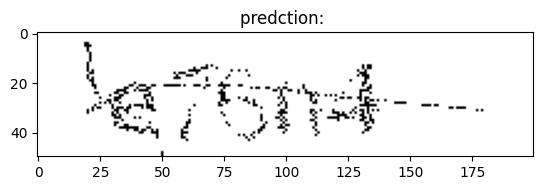

In [196]:
model.load_state_dict(torch.load('CRNN.pth',map_location=device))

with torch.no_grad():
  testset=Captcha(pth=os.path.join(path,'samples'),train=False)
  test_img,label=testset[0] #test_img = [H,W,C]

  input_tensor=torch.unsqueeze(torch.tensor(test_img),dim=0) #test_img = [1,H,W,C]
  input_tensor=input_tensor.permute(0,3,1,2).to(device) #test_img = [1,C,H,W]

  pred=torch.argmax(model(input_tensor),dim=-1) #dim=-1은 class 차원에서의 최대값의 인덱스 반환
  prev_letter=pred[0].item()
  pred_word=""
  for letter in pred:
    if letter.item() !=0 and letter.item() != prev_letter:
      pred_word += list(testset.BOW.keys())[letter.items()]
    prev_letter=letter.item()

  plt.imshow(test_img)
  plt.title('predction: ' + pred_word)
  plt.show()